# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [7]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, log_loss
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed


#### Run with GPU


In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Load

In [9]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [10]:
display(data)

Disease                                         User_input
0       Psoriasis  I have been experiencing a skin rash on my arm...
1       Psoriasis  My skin has been peeling, especially on my kne...
2       Psoriasis  I have been experiencing joint pain in my fing...
3       Psoriasis  There is a silver like dusting on my skin, esp...
4       Psoriasis  My nails have small dents or pits in them, and...
...           ...                                                ...
10329  Dermatitis  The discomfort in my skin has made it challeng...
10330  Dermatitis  The raw, sensitive skin from scratching has ma...
10331  Dermatitis  I feel like my skin is tearing apart, causing ...
10332  Dermatitis  Engaging in physical activities has become unb...
10333  Dermatitis  The pain in my skin has restricted me from enj...

[10334 rows x 2 columns]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [12]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


Psoriasis : 2113 samples
Melanoma : 2070 samples
Urticaria : 2216 samples
Lupus : 1669 samples
Dermatitis : 2266 samples


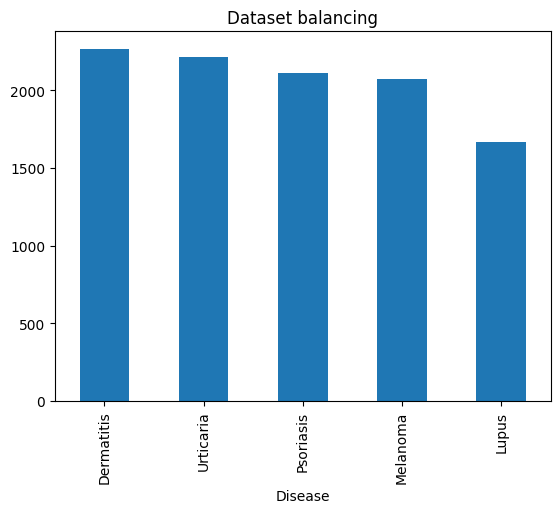

In [13]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

# Print count for each disease
for disease in data['Disease'].unique():
    print(f"{disease} : {data[data['Disease'] == disease].shape[0]} samples")

## Model Evaluation

In [14]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

    # Loss
    print("\n\033[1mLoss\033[0m")
    y_pred_proba = model.predict_proba(X_Test)
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_proba)
    print(f"Log loss: {loss}")

    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [15]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [16]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

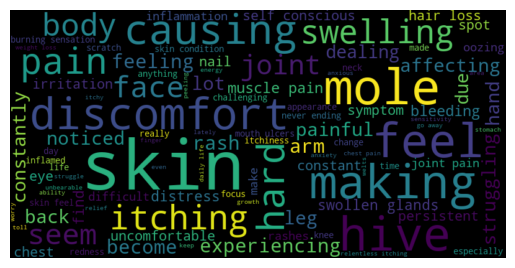

In [17]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

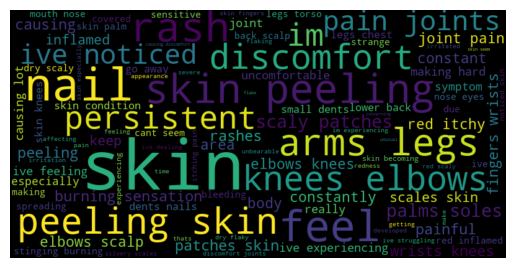

In [18]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

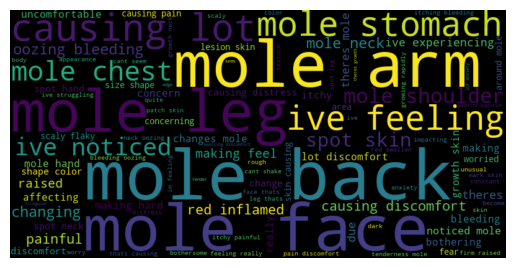

In [19]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

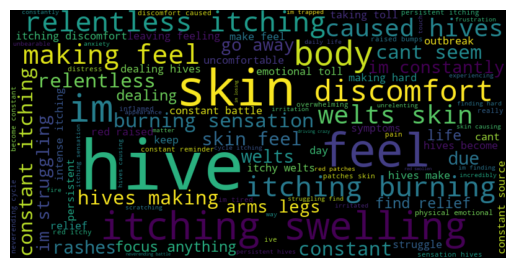

In [20]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

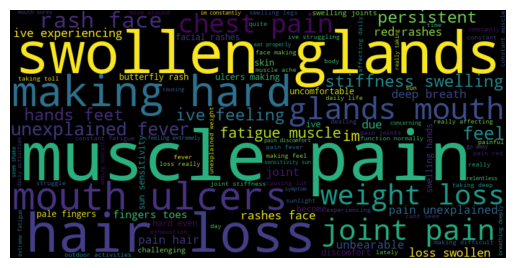

In [21]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

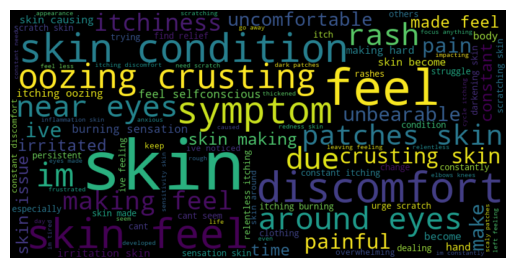

In [22]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [23]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [24]:
#nltk.download('wordnet')

In [25]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [26]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [27]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [28]:
display(data)

Disease                                         User_input  \
0       Psoriasis  [I, have, been, experiencing, a, skin, rash, o...   
1       Psoriasis  [My, skin, has, been, peeling,, especially, on...   
2       Psoriasis  [I, have, been, experiencing, joint, pain, in,...   
3       Psoriasis  [There, is, a, silver, like, dusting, on, my, ...   
4       Psoriasis  [My, nails, have, small, dents, or, pits, in, ...   
...           ...                                                ...   
10329  Dermatitis  [The, discomfort, in, my, skin, has, made, it,...   
10330  Dermatitis  [The, raw,, sensitive, skin, from, scratching,...   
10331  Dermatitis  [I, feel, like, my, skin, is, tearing, apart,,...   
10332  Dermatitis  [Engaging, in, physical, activities, has, beco...   
10333  Dermatitis  [The, pain, in, my, skin, has, restricted, me,...   

                                 User_input_preprocessed  \
0      [experiencing, skin, rash, arms, legs, torso, ...   
1      [my, skin, peeling, especially, knees, elbows,...   
2      [experiencing, joint, pain, fingers, wrists, k...   
3      [there, silver, like, dusting, skin, especiall...   
4      [my, nails, small, dents, pits, them, often, f...   
...                                                  ...   
10329  [the, discomfort, skin, made, challenging, par...   
10330  [the, raw, sensitive, skin, scratching, made, ...   
10331  [feel, like, skin, tearing, apart, causing, ex...   
10332  [engaging, physical, activities, become, unbea...   
10333  [the, pain, skin, restricted, enjoying, hobbie...   

                            User_input_preprocessed_stem  \
0      [experienc, skin, rash, arm, leg, torso, past,...   
1      [my, skin, peel, especi, knee, elbow, scalp, t...   
2      [experienc, joint, pain, finger, wrist, knee, ...   
3      [there, silver, like, dust, skin, especi, lowe...   
4      [my, nail, small, dent, pit, them, often, feel...   
...                                                  ...   
10329  [the, discomfort, skin, made, challeng, partak...   
10330  [the, raw, sensit, skin, scratch, made, unbear...   
10331  [feel, like, skin, tear, apart, caus, excruci,...   
10332  [engag, physic, activ, becom, unbear, due, sen...   
10333  [the, pain, skin, restrict, enjoy, hobbi, invo...   

                             User_input_preprocessed_lem  
0      [experiencing, skin, rash, arm, leg, torso, pa...  
1      [my, skin, peeling, especially, knee, elbow, s...  
2      [experiencing, joint, pain, finger, wrist, kne...  
3      [there, silver, like, dusting, skin, especiall...  
4      [my, nail, small, dent, pit, them, often, feel...  
...                                                  ...  
10329  [the, discomfort, skin, made, challenging, par...  
10330  [the, raw, sensitive, skin, scratching, made, ...  
10331  [feel, like, skin, tearing, apart, causing, ex...  
10332  [engaging, physical, activity, become, unbeara...  
10333  [the, pain, skin, restricted, enjoying, hobby,...  

[10334 rows x 5 columns]

## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [29]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [30]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(1,3))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [31]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))

# Save fited vectorizer
#joblib.dump(tf_idf_stem, 'Vectorizer/tfidf_stem.pkl')
joblib.dump(tf_idf_lem, 'Vectorizer/tfidf_lem.pkl')

['Vectorizer/tfidf_lem.pkl']

In [32]:
tf_idf_ngram = TfidfVectorizer(ngram_range=(1,3))

tf_idf_ngram_normal = tf_idf_ngram.fit(data['User_input'].apply(' '.join))

tf_idf_ngram_preprocessed = tf_idf_ngram.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_ngram_lem = tf_idf_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_ngram_stem = tf_idf_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [33]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 5 columns.
Test dataset contains 2067 rows and 5 columns.


In [34]:
display(train)

Disease                                         User_input  \
4880  Urticaria  [I'm, struggling, to, find, moments, of, peace...   
6651      Lupus  [My, sensitivity, to, sunlight, is, causing, m...   
6451  Urticaria  [The, hives, have, disrupted, every, aspect, o...   
4157   Melanoma  [I've, recently, noticed, this, growth, on, my...   
828   Psoriasis  [I, struggle, with, painful, swelling, in, my,...   
...         ...                                                ...   
5734  Urticaria  [The, hives, on, my, skin, have, caused, such,...   
5191  Urticaria  [The, itching, and, swelling, have, become, a,...   
5390  Urticaria  [It, feels, like, I'm, living, in, a, body, th...   
860   Psoriasis  [I'm, frustrated, by, the, visible, scales, th...   
7270      Lupus  [The, muscle, pain, and, persistent, fever, ha...   

                                User_input_preprocessed  \
4880  [im, struggling, find, moments, peace, amidst,...   
6651  [my, sensitivity, sunlight, causing, lot, disc...   
6451  [the, hives, disrupted, every, aspect, life, w...   
4157  [ive, recently, noticed, growth, leg, causing,...   
828        [struggle, painful, swelling, joints, daily]   
...                                                 ...   
5734  [the, hives, skin, caused, intense, itching, s...   
5191  [the, itching, swelling, become, constant, sou...   
5390  [it, feels, like, im, living, body, thats, hij...   
860     [im, frustrated, visible, scales, formed, body]   
7270  [the, muscle, pain, persistent, fever, really,...   

                           User_input_preprocessed_stem  \
4880  [im, struggl, find, moment, peac, amidst, chao...   
6651  [my, sensit, sunlight, caus, lot, discomfort, ...   
6451  [the, hive, disrupt, everi, aspect, life, work...   
4157  [ive, recent, notic, growth, leg, caus, lot, t...   
828                [struggl, pain, swell, joint, daili]   
...                                                 ...   
5734  [the, hive, skin, caus, intens, itch, swell, l...   
5191  [the, itch, swell, becom, constant, sourc, str...   
5390  [it, feel, like, im, live, bodi, that, hijack,...   
860           [im, frustrat, visibl, scale, form, bodi]   
7270  [the, muscl, pain, persist, fever, realli, wea...   

                            User_input_preprocessed_lem  
4880  [im, struggling, find, moment, peace, amidst, ...  
6651  [my, sensitivity, sunlight, causing, lot, disc...  
6451  [the, hive, disrupted, every, aspect, life, wo...  
4157  [ive, recently, noticed, growth, leg, causing,...  
828         [struggle, painful, swelling, joint, daily]  
...                                                 ...  
5734  [the, hive, skin, caused, intense, itching, sw...  
5191  [the, itching, swelling, become, constant, sou...  
5390  [it, feel, like, im, living, body, thats, hija...  
860      [im, frustrated, visible, scale, formed, body]  
7270  [the, muscle, pain, persistent, fever, really,...  

[8267 rows x 5 columns]

#### Define X

##### BoW

In [35]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Bow Ngram

In [36]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [37]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### TF-IDF N-gram

In [38]:
# without preprocessing
X_train_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_ngram_stem = tf_idf_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_ngram_stem = tf_idf_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_ngram_lem = tf_idf_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_ngram_lem = tf_idf_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [39]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [40]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [41]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [83]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500],
            'C': np.arange(1.0, 10.0, 1.0),
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [51]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    penalty = best_param['penalty']
    if penalty == 'elasticnet':
        lr = LogisticRegression(solver=best_param['solver'], penalty=penalty, C=best_param['C'], max_iter=best_param['max_iter'], l1_ratio=best_param['l1_ratio'])
    else:
        lr = LogisticRegression(solver=best_param['solver'], penalty=penalty, C=best_param['C'], max_iter=best_param['max_iter'])
    
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [44]:
name = "LR_withoutyproc_"

**BoW** 

100%|███████████████████████████████████████████████| 50/50 [00:13<00:00,  3.78trial/s, best loss: -0.7326709489397095]
Best hyperparameters: {'C': 2.893965183669115, 'max_iter': 20, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7797
Specificity Score: 0.7797
Precision Score: 0.7864
F1 Score: 0.7788

Testing Results
Accuracy Score: 0.7155
Specificity Score: 0.7155
Precision Score: 0.7230
F1 Score: 0.7150

Loss
Log loss: 0.673159474395258

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.72      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.77      0.57      0.66      1668
   Urticaria       0.67      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.78      0.78      8267
weighted avg       0.79      0.78      0.78      8267


Classifica

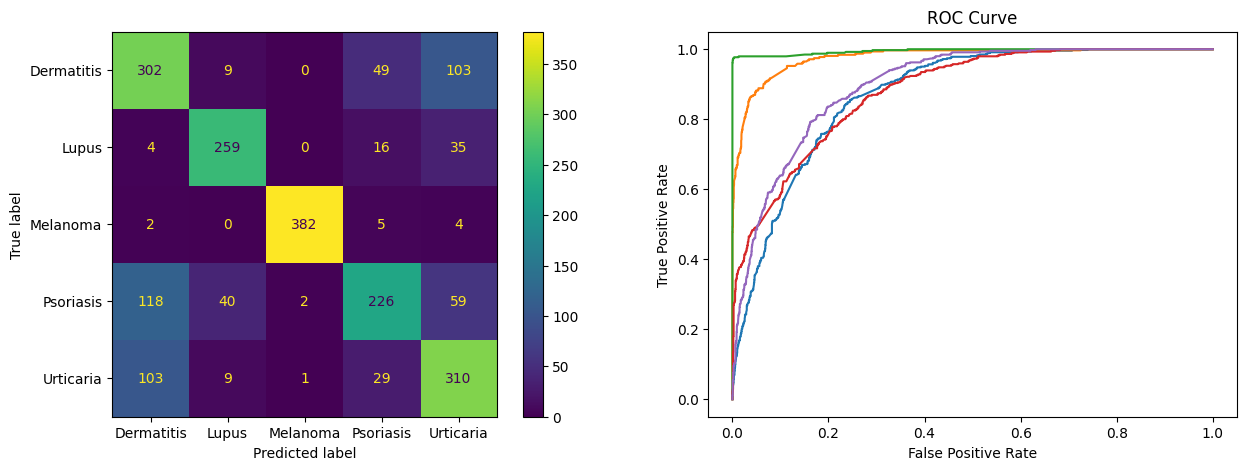

In [45]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

Best parameters: {'C': 4.0, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.7744
Specificity Score: 0.7744
Precision Score: 0.7749
F1 Score: 0.7739

Testing Results
Accuracy Score: 0.7121
Specificity Score: 0.7121
Precision Score: 0.7126
F1 Score: 0.7117

Loss
Log loss: 0.6748367787976846

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.68      0.62      0.65      1803
       Lupus       0.87      0.88      0.88      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.68      0.67      0.67      1668
   Urticaria       0.68      0.75      0.71      1764

    accuracy                           0.77      8267
   macro avg       0.78      0.78      0.78      8267
weighted avg       0.77      0.77      0.77      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.56      0.57       463
       Lupus    

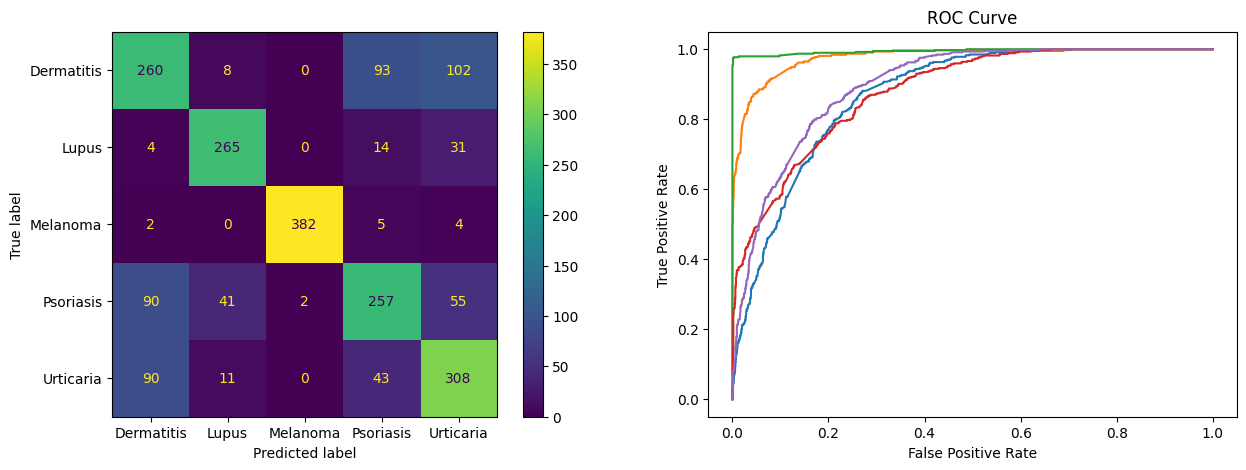

In [46]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**BoW n-grams**

100%|███████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/trial, best loss: -0.7399298187093051]
Best hyperparameters: {'C': 1.3577779025220764, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.8129
Specificity Score: 0.8129
Precision Score: 0.8204
F1 Score: 0.8124

Testing Results
Accuracy Score: 0.7300
Specificity Score: 0.7300
Precision Score: 0.7380
F1 Score: 0.7301

Loss
Log loss: 0.6563395824591048

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.76      0.73      1803
       Lupus       0.90      0.89      0.90      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.83      0.62      0.71      1668
   Urticaria       0.70      0.82      0.76      1764

    accuracy                           0.81      8267
   macro avg       0.83      0.82      0.82      8267
weighted avg       0.82      0.81      0.81      8267


Classificat

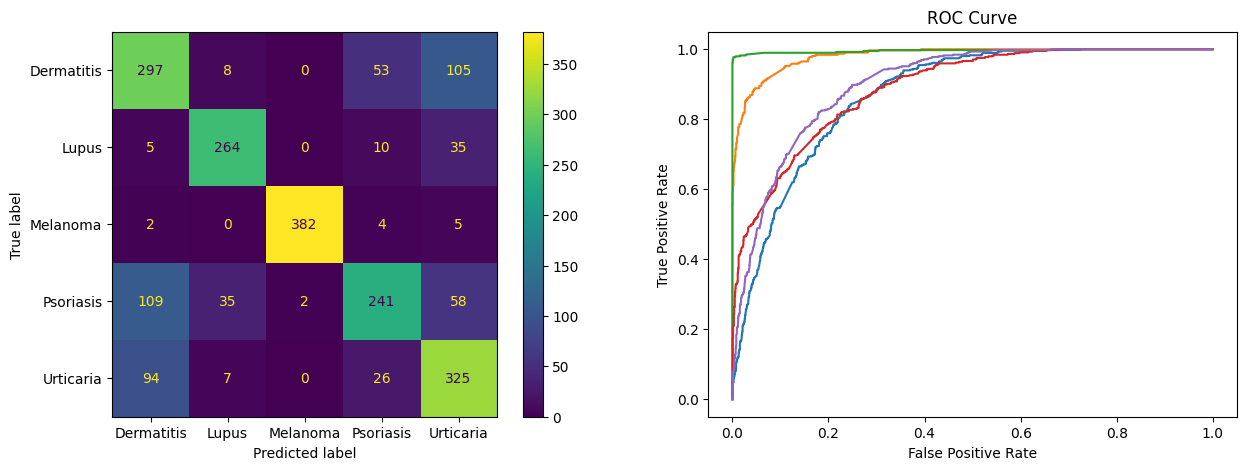

In [47]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

Best parameters: {'C': 2.0, 'max_iter': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.8167
Specificity Score: 0.8167
Precision Score: 0.8237
F1 Score: 0.8164

Testing Results
Accuracy Score: 0.7291
Specificity Score: 0.7291
Precision Score: 0.7367
F1 Score: 0.7291

Loss
Log loss: 0.6579328644869709

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.71      0.77      0.74      1803
       Lupus       0.91      0.89      0.90      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.83      0.63      0.71      1668
   Urticaria       0.71      0.82      0.76      1764

    accuracy                           0.82      8267
   macro avg       0.83      0.82      0.82      8267
weighted avg       0.82      0.82      0.82      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.64      0.61       463
       Lupus 

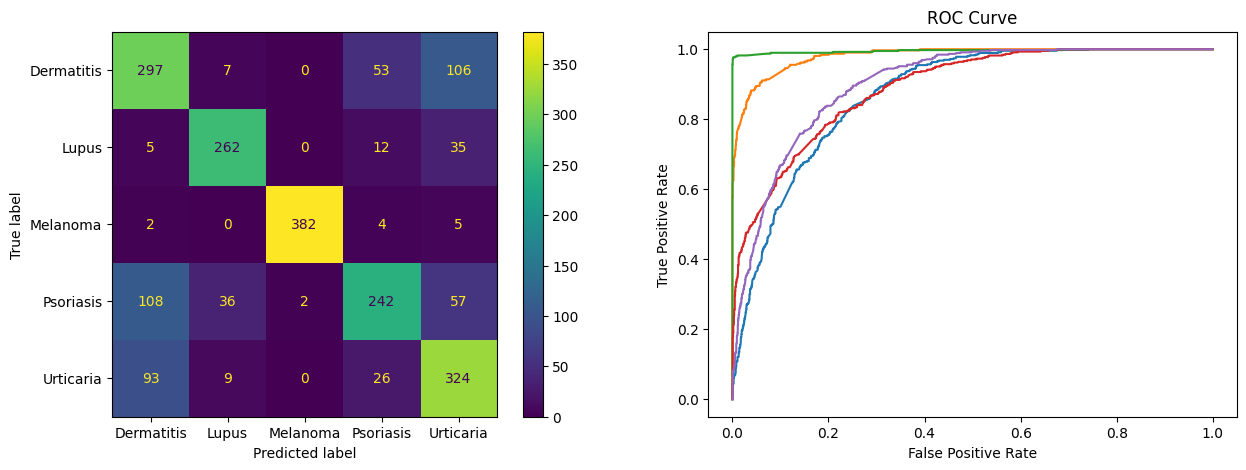

In [48]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

100%|███████████████████████████████████████████████| 50/50 [00:15<00:00,  3.20trial/s, best loss: -0.7837170481137591]
Best hyperparameters: {'C': 6.873701204594029, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.8316
Specificity Score: 0.8316
Precision Score: 0.8329
F1 Score: 0.8313

Testing Results
Accuracy Score: 0.7654
Specificity Score: 0.7654
Precision Score: 0.7694
F1 Score: 0.7663

Loss
Log loss: 0.5906359573254424

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.77      0.74      1803
       Lupus       0.90      0.90      0.90      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.79      0.69      0.74      1668
   Urticaria       0.79      0.83      0.81      1764

    accuracy                           0.83      8267
   macro avg       0.84      0.84      0.84      8267
weighted avg       0.83      0.83      0.83      8267


Classificati

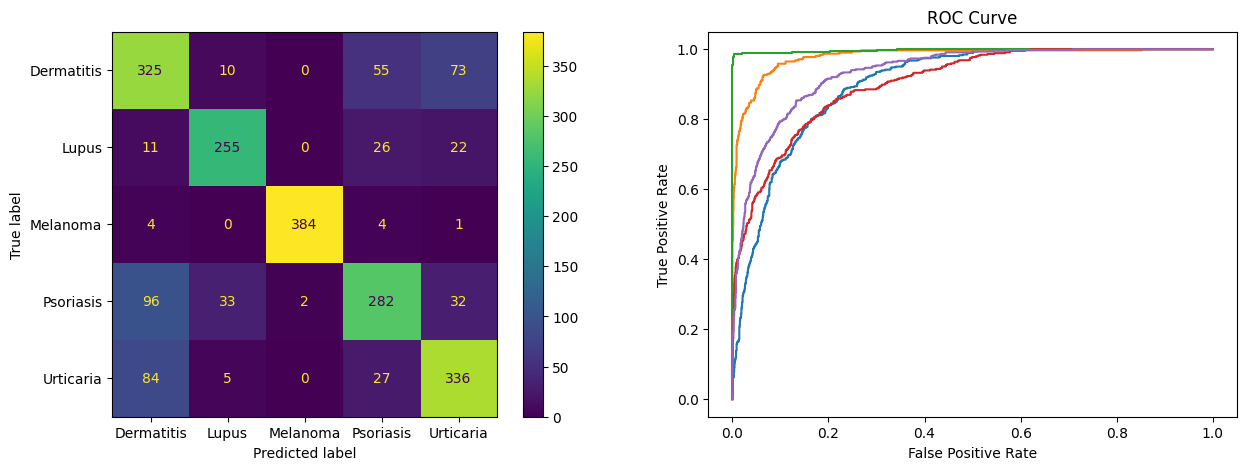

In [49]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

Best parameters: {'C': 9.0, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8282
Specificity Score: 0.8282
Precision Score: 0.8300
F1 Score: 0.8278

Testing Results
Accuracy Score: 0.7610
Specificity Score: 0.7610
Precision Score: 0.7655
F1 Score: 0.7615

Loss
Log loss: 0.6070930892711957

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.77      0.74      1803
       Lupus       0.90      0.90      0.90      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.79      0.68      0.73      1668
   Urticaria       0.77      0.83      0.80      1764

    accuracy                           0.83      8267
   macro avg       0.83      0.83      0.83      8267
weighted avg       0.83      0.83      0.83      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.62      0.70      0.66       463
       Lupus

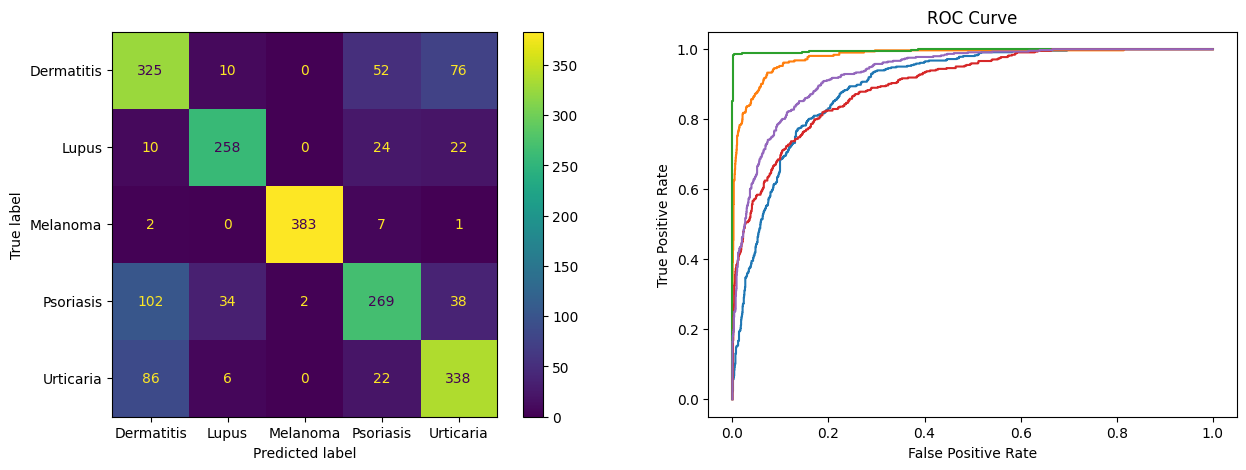

In [52]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

100%|███████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/trial, best loss: -0.8037969146273932]
Best hyperparameters: {'C': 7.572739485955213, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8637
Specificity Score: 0.8637
Precision Score: 0.8659
F1 Score: 0.8637

Testing Results
Accuracy Score: 0.7866
Specificity Score: 0.7866
Precision Score: 0.7887
F1 Score: 0.7871

Loss
Log loss: 0.5744053307491568

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.77      0.82      0.79      1803
       Lupus       0.92      0.92      0.92      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.86      0.75      0.80      1668
   Urticaria       0.81      0.86      0.83      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.86      0.86      8267


Classific

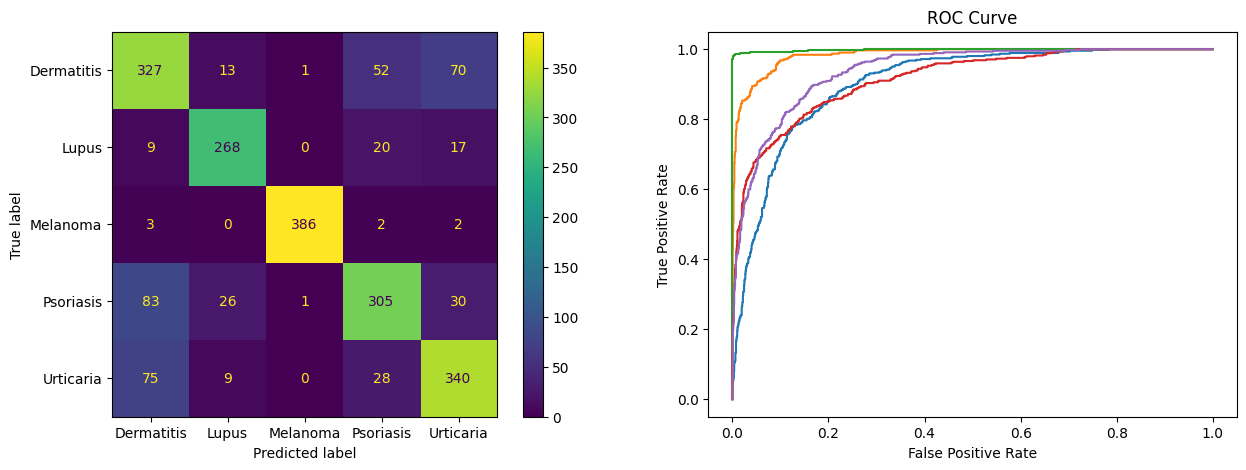

In [53]:
best_params = hyperopt_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

Best parameters: {'C': 9.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8645
Specificity Score: 0.8645
Precision Score: 0.8666
F1 Score: 0.8646

Testing Results
Accuracy Score: 0.7896
Specificity Score: 0.7896
Precision Score: 0.7921
F1 Score: 0.7902

Loss
Log loss: 0.5702229204916945

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.77      0.82      0.79      1803
       Lupus       0.93      0.92      0.92      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.86      0.75      0.80      1668
   Urticaria       0.81      0.86      0.83      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.66      0.71      0.69       463
       Lupus

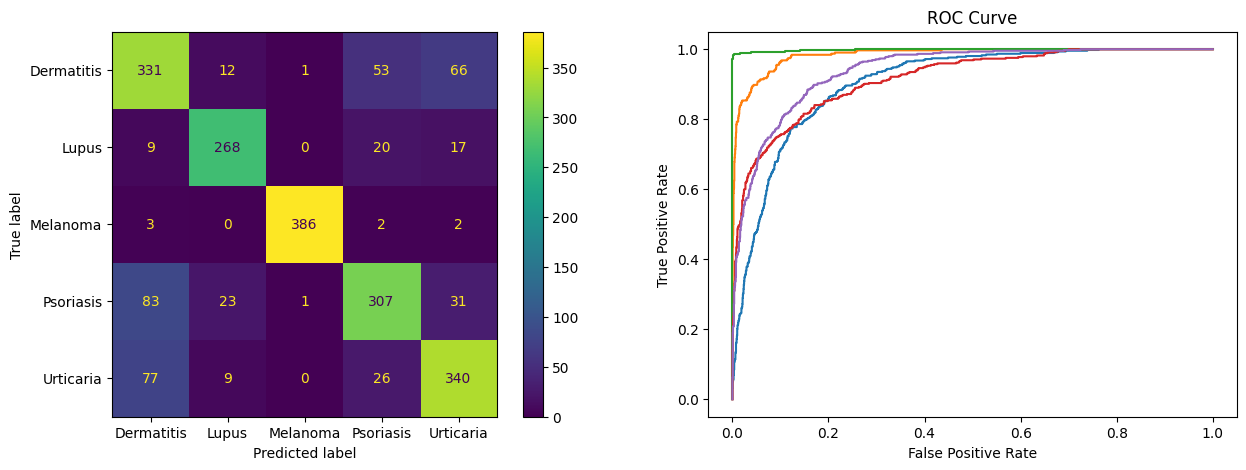

In [54]:
best_params = grid_search_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [55]:
name = "LR_withproc_"

**BoW** 

100%|███████████████████████████████████████████████| 50/50 [00:14<00:00,  3.45trial/s, best loss: -0.7361791356596886]
Best hyperparameters: {'C': 4.003453913563645, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.7797
Specificity Score: 0.7797
Precision Score: 0.7833
F1 Score: 0.7790

Testing Results
Accuracy Score: 0.7155
Specificity Score: 0.7155
Precision Score: 0.7194
F1 Score: 0.7148

Loss
Log loss: 0.686637352770612

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.69      0.68      1803
       Lupus       0.88      0.87      0.87      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.74      0.59      0.66      1668
   Urticaria       0.67      0.78      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.78      0.78      8267
weighted avg       0.78      0.78      0.78      8267


Classifica

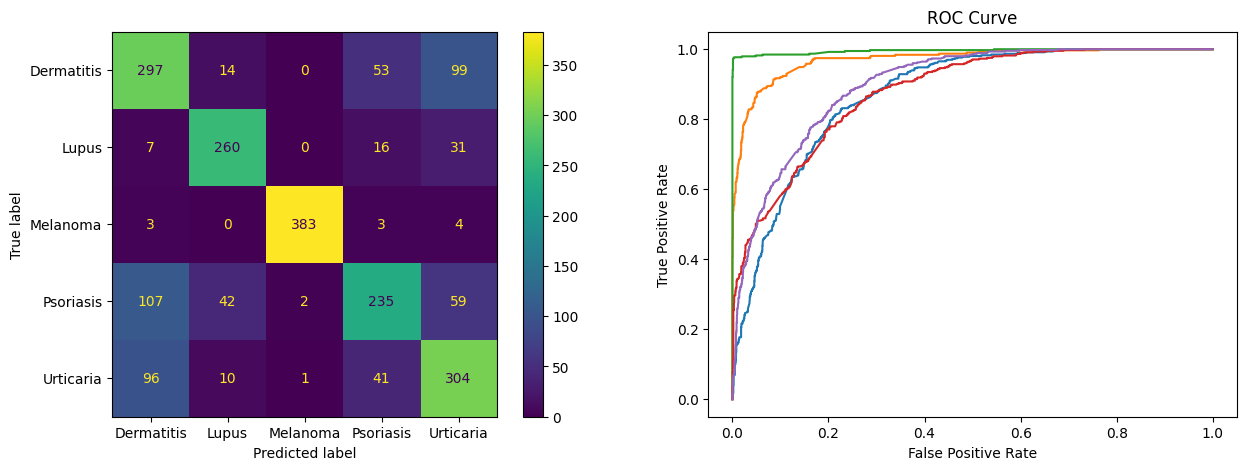

In [56]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

Best parameters: {'C': 2.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7812
Specificity Score: 0.7812
Precision Score: 0.7841
F1 Score: 0.7806

Testing Results
Accuracy Score: 0.7170
Specificity Score: 0.7170
Precision Score: 0.7204
F1 Score: 0.7161

Loss
Log loss: 0.6821481821138746

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.69      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.73      0.60      0.66      1668
   Urticaria       0.68      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.79      0.79      8267
weighted avg       0.78      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.64      0.61       463
       Lupus

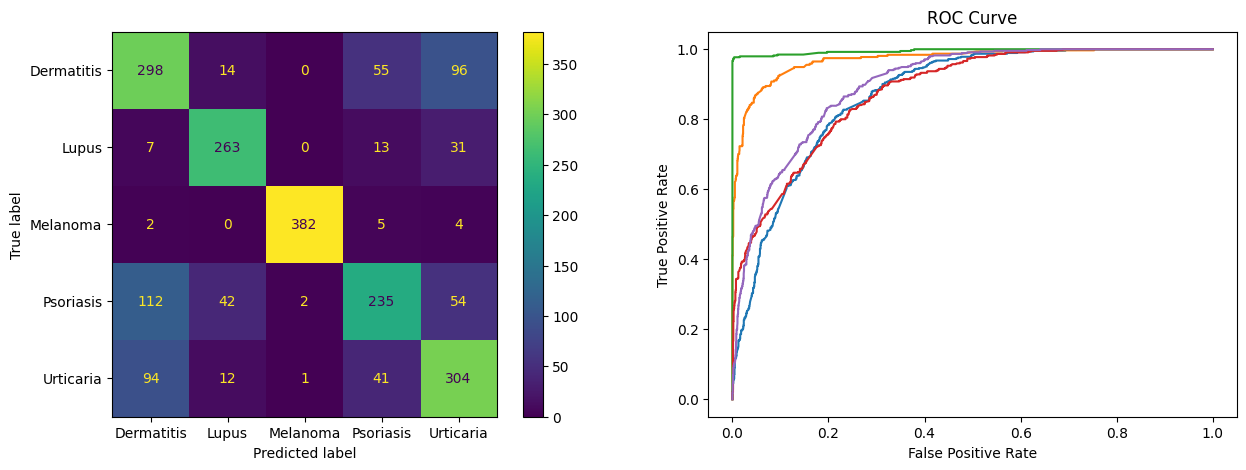

In [57]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

100%|███████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/trial, best loss: -0.7392034269888539]
Best hyperparameters: {'C': 2.3036317926592975, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8155
Specificity Score: 0.8155
Precision Score: 0.8189
F1 Score: 0.8152

Testing Results
Accuracy Score: 0.7238
Specificity Score: 0.7238
Precision Score: 0.7282
F1 Score: 0.7235

Loss
Log loss: 0.6653697770457588

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.74      0.73      1803
       Lupus       0.90      0.89      0.90      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.79      0.66      0.72      1668
   Urticaria       0.72      0.82      0.77      1764

    accuracy                           0.82      8267
   macro avg       0.82      0.82      0.82      8267
weighted avg       0.82      0.82      0.82      8267


Classifi

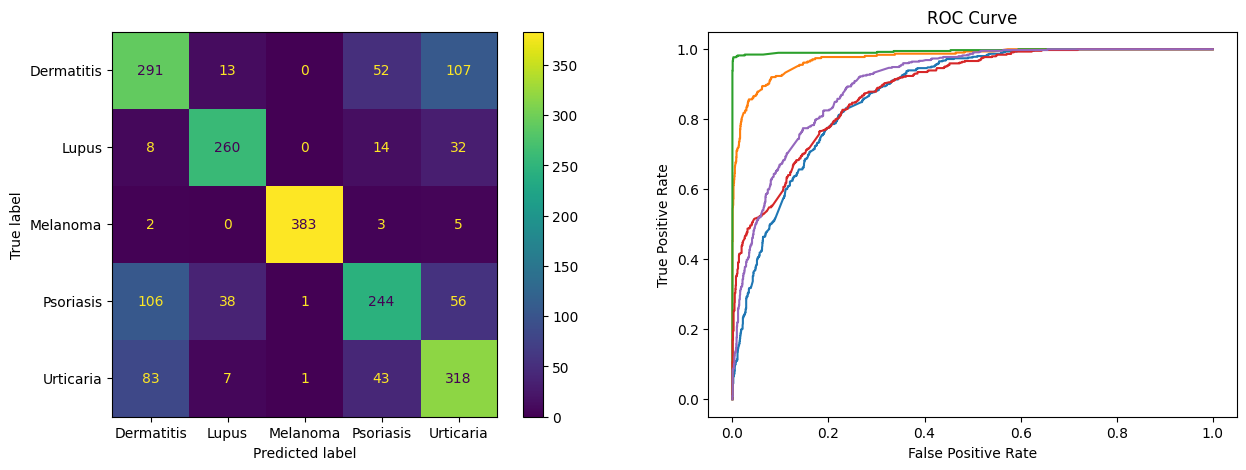

In [58]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

Best parameters: {'C': 1.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8017
Specificity Score: 0.8017
Precision Score: 0.8057
F1 Score: 0.8012

Testing Results
Accuracy Score: 0.7199
Specificity Score: 0.7199
Precision Score: 0.7251
F1 Score: 0.7193

Loss
Log loss: 0.676725764332978

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.73      0.71      1803
       Lupus       0.89      0.88      0.89      1355
    Melanoma       1.00      0.98      0.99      1677
   Psoriasis       0.78      0.62      0.69      1668
   Urticaria       0.70      0.81      0.75      1764

    accuracy                           0.80      8267
   macro avg       0.81      0.81      0.81      8267
weighted avg       0.81      0.80      0.80      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.62      0.60       463
       Lupus 

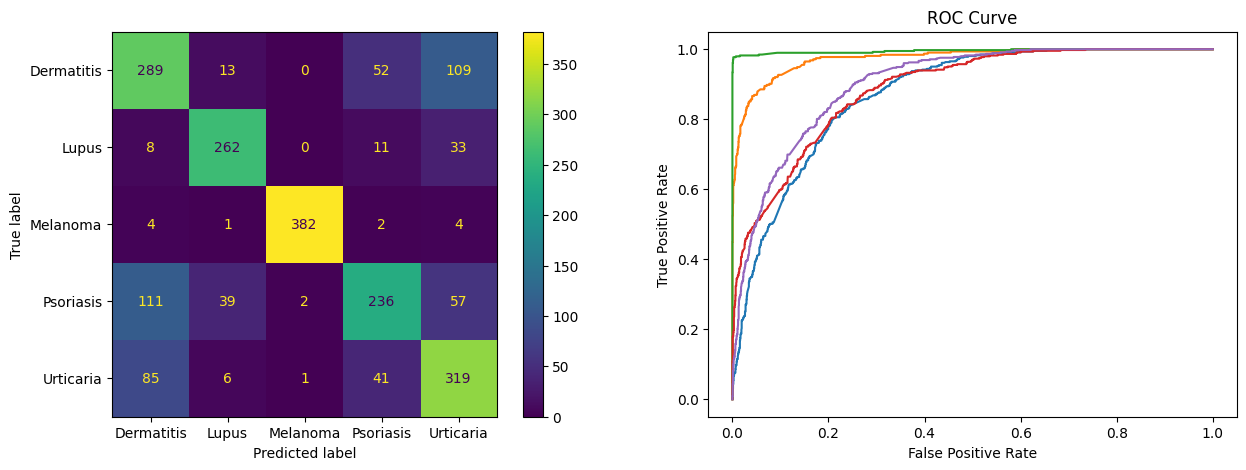

In [59]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

**TF-IDF**

100%|███████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76trial/s, best loss: -0.7482755694640428]
Best hyperparameters: {'C': 5.131562385290788, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Training Results
Accuracy Score: 0.8025
Specificity Score: 0.8025
Precision Score: 0.8041
F1 Score: 0.8020

Testing Results
Accuracy Score: 0.7233
Specificity Score: 0.7233
Precision Score: 0.7251
F1 Score: 0.7229

Loss
Log loss: 0.6681893195062213

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.69      0.70      1803
       Lupus       0.88      0.90      0.89      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.77      0.67      0.71      1668
   Urticaria       0.70      0.79      0.74      1764

    accuracy                           0.80      8267
   macro avg       0.81      0.81      0.81      8267
weighted avg       0.80      0.80      0.80      8267


Classification

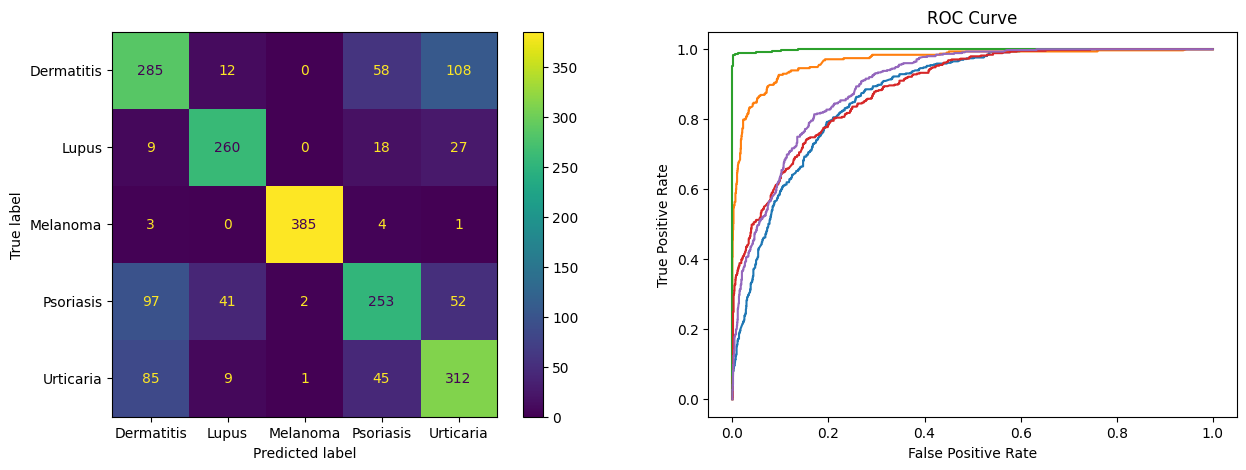

In [60]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

Best parameters: {'C': 1.0, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.7887
Specificity Score: 0.7887
Precision Score: 0.7921
F1 Score: 0.7887

Testing Results
Accuracy Score: 0.7286
Specificity Score: 0.7286
Precision Score: 0.7315
F1 Score: 0.7286

Loss
Log loss: 0.6939015010108875

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.69      0.69      1803
       Lupus       0.88      0.86      0.87      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.75      0.64      0.69      1668
   Urticaria       0.68      0.79      0.73      1764

    accuracy                           0.79      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.79      0.79      0.79      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.62      0.61       463
       Lupus    

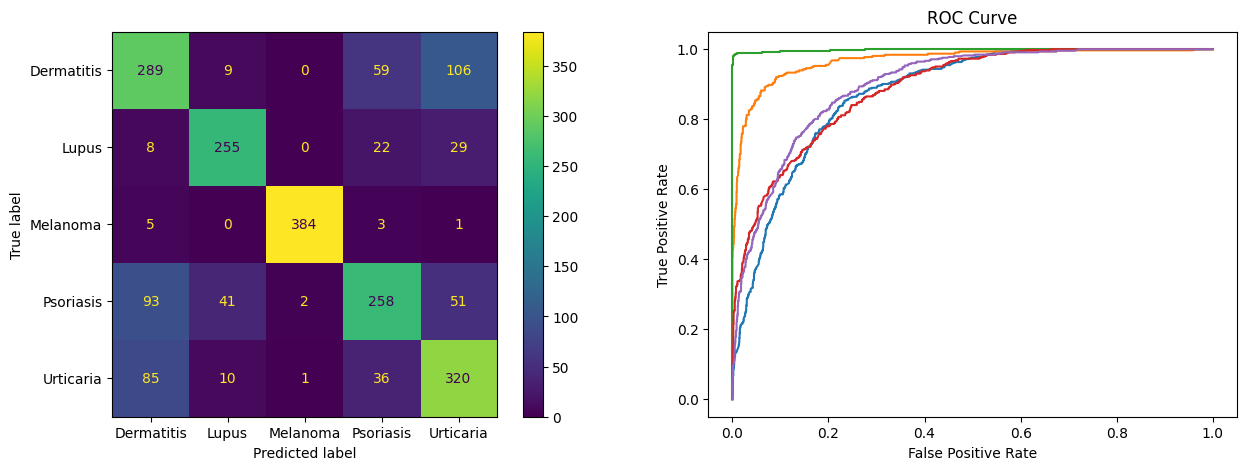

In [61]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

100%|███████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/trial, best loss: -0.7602519620988843]
Best hyperparameters: {'C': 1.8623047052276478, 'max_iter': 5, 'penalty': 'l2', 'solver': 'sag'}
Training Results
Accuracy Score: 0.8427
Specificity Score: 0.8427
Precision Score: 0.8458
F1 Score: 0.8428

Testing Results
Accuracy Score: 0.7397
Specificity Score: 0.7397
Precision Score: 0.7446
F1 Score: 0.7403

Loss
Log loss: 0.6735197079494376

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.76      0.75      0.76      1803
       Lupus       0.92      0.91      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.84      0.73      0.78      1668
   Urticaria       0.74      0.85      0.79      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.85      0.85      8267
weighted avg       0.85      0.84      0.84      8267


Classification 

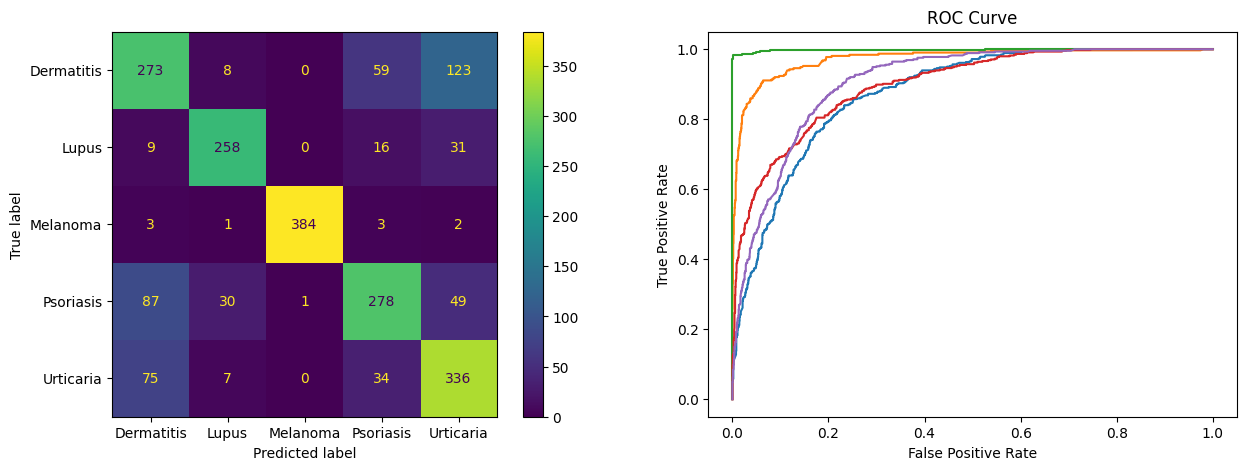

In [62]:
best_params = hyperopt_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

Best parameters: {'C': 2.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8369
Specificity Score: 0.8369
Precision Score: 0.8410
F1 Score: 0.8372

Testing Results
Accuracy Score: 0.7392
Specificity Score: 0.7392
Precision Score: 0.7443
F1 Score: 0.7398

Loss
Log loss: 0.6900664866428098

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.75      0.74      0.75      1803
       Lupus       0.92      0.89      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.83      0.72      0.77      1668
   Urticaria       0.73      0.85      0.79      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.84      0.84      8267
weighted avg       0.84      0.84      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.61      0.60      0.60       463
       Lupus

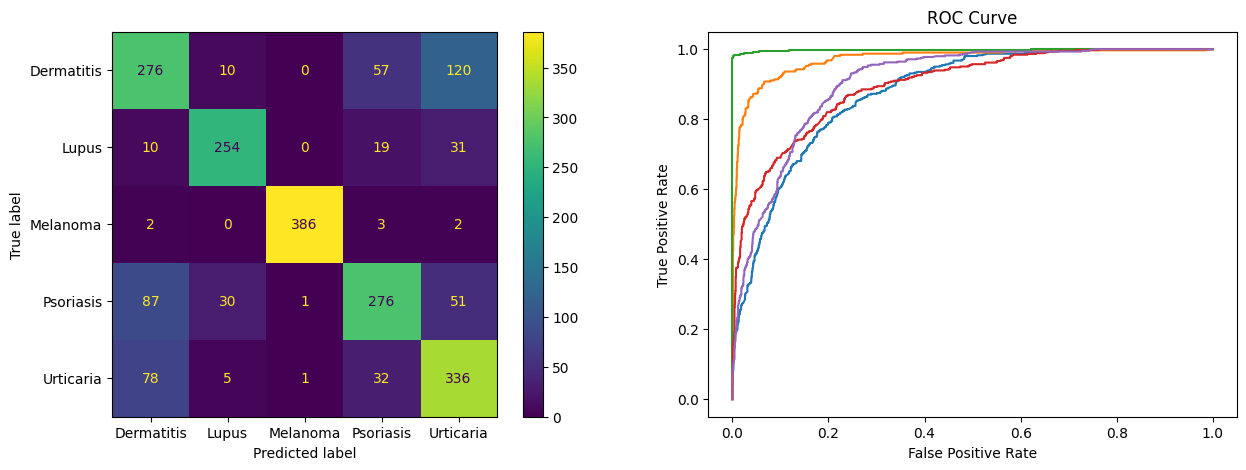

In [63]:
best_params = grid_search_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [64]:
name = "LR_lem_"

**BoW** 

100%|████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.08trial/s, best loss: -0.826901438226346]
Best hyperparameters: {'C': 6.486106228319215, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8680
Specificity Score: 0.8680
Precision Score: 0.8743
F1 Score: 0.8686

Testing Results
Accuracy Score: 0.8355
Specificity Score: 0.8355
Precision Score: 0.8412
F1 Score: 0.8360

Loss
Log loss: 0.44436293022652285

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.88      0.80      1803
       Lupus       0.89      0.92      0.91      1355
    Melanoma       0.99      0.97      0.98      1677
   Psoriasis       0.84      0.74      0.78      1668
   Urticaria       0.93      0.84      0.88      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classif

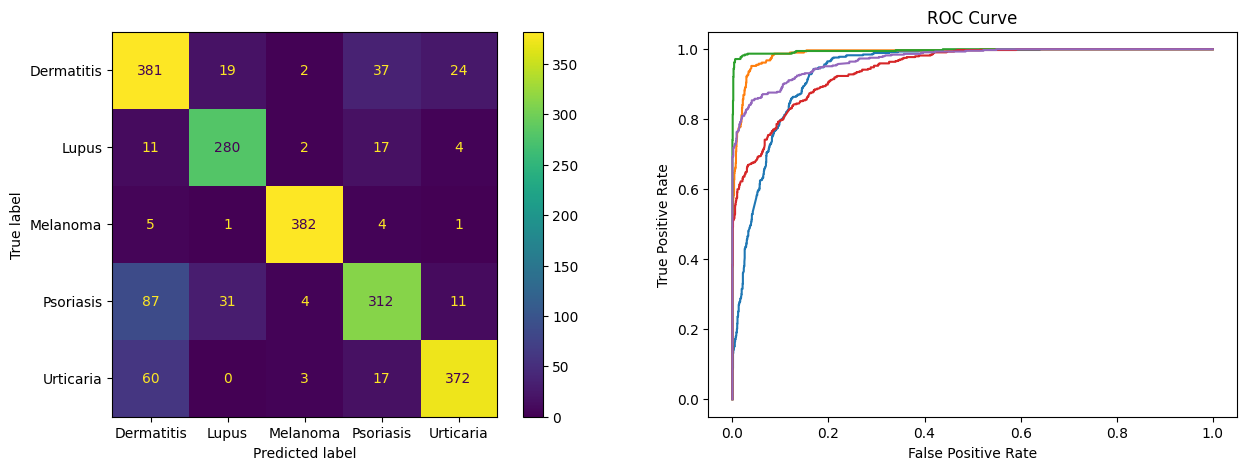

In [65]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

Best parameters: {'C': 2.0, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8610
Specificity Score: 0.8610
Precision Score: 0.8680
F1 Score: 0.8616

Testing Results
Accuracy Score: 0.8321
Specificity Score: 0.8321
Precision Score: 0.8391
F1 Score: 0.8328

Loss
Log loss: 0.4422827264376821

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.87      0.79      1803
       Lupus       0.89      0.92      0.90      1355
    Melanoma       0.99      0.97      0.98      1677
   Psoriasis       0.83      0.72      0.77      1668
   Urticaria       0.92      0.84      0.88      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.86      0.86      8267
weighted avg       0.87      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.83      0.75       463
       Lupus

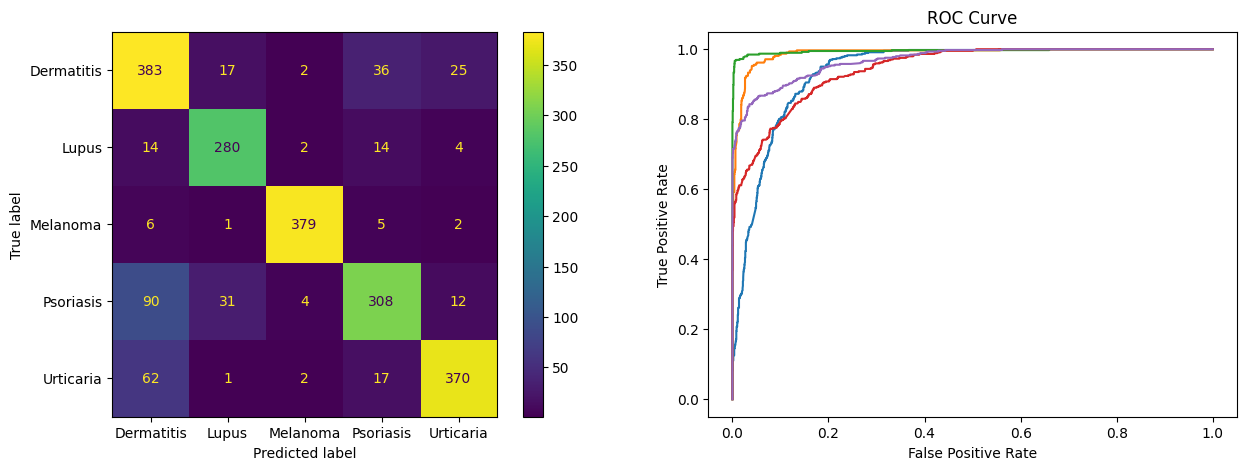

In [66]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

100%|███████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/trial, best loss: -0.8417792281228443]
Best hyperparameters: {'C': 1.6154709496676443, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9052
Specificity Score: 0.9052
Precision Score: 0.9111
F1 Score: 0.9060

Testing Results
Accuracy Score: 0.8345
Specificity Score: 0.8345
Precision Score: 0.8425
F1 Score: 0.8362

Loss
Log loss: 0.4258018246725052

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.78      0.92      0.84      1803
       Lupus       0.95      0.95      0.95      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.90      0.80      0.85      1668
   Urticaria       0.95      0.88      0.92      1764

    accuracy                           0.91      8267
   macro avg       0.91      0.91      0.91      8267
weighted avg       0.91      0.91      0.91      8267


Classif

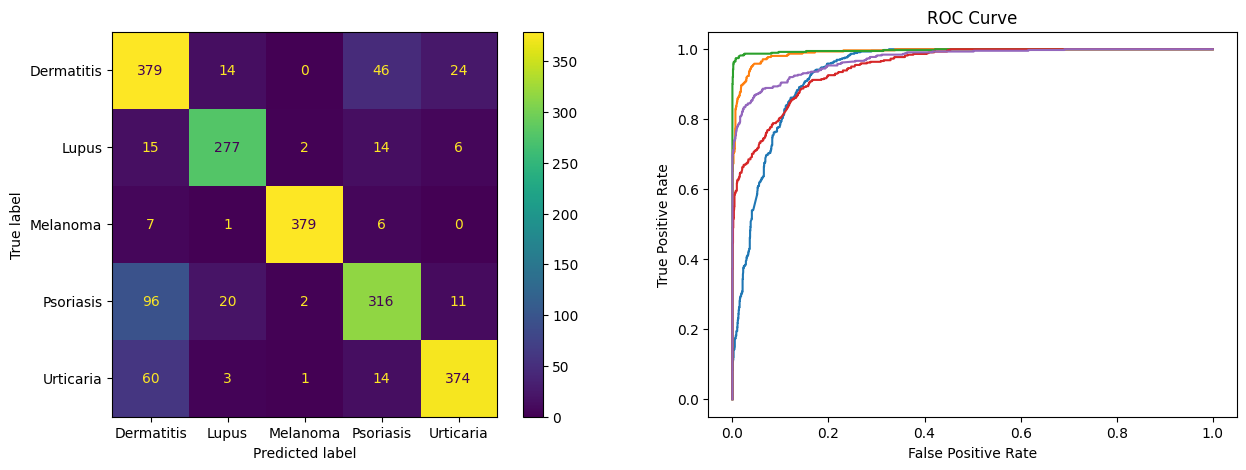

In [67]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

Best parameters: {'C': 4.0, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9167
Specificity Score: 0.9167
Precision Score: 0.9215
F1 Score: 0.9174

Testing Results
Accuracy Score: 0.8355
Specificity Score: 0.8355
Precision Score: 0.8426
F1 Score: 0.8371

Loss
Log loss: 0.44247417665044747

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.80      0.93      0.86      1803
       Lupus       0.96      0.96      0.96      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.91      0.82      0.87      1668
   Urticaria       0.96      0.90      0.93      1764

    accuracy                           0.92      8267
   macro avg       0.92      0.92      0.92      8267
weighted avg       0.92      0.92      0.92      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.68      0.81      0.74       463
       Lupu

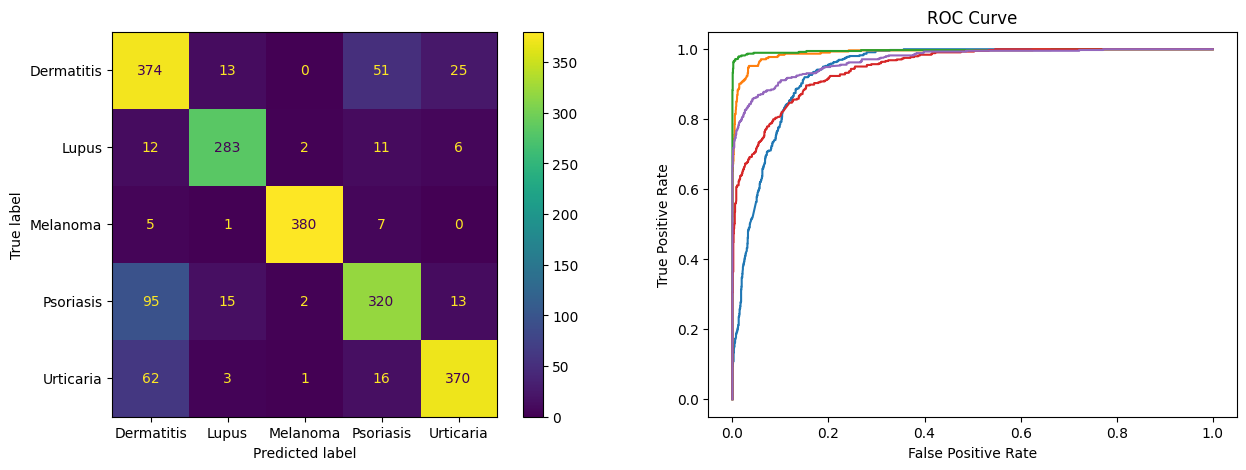

In [68]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

**TF-IDF**

100%|███████████████████████████████████████████████| 50/50 [00:10<00:00,  4.81trial/s, best loss: -0.8296844767967952]
Best hyperparameters: {'C': 1.6946350011825217, 'max_iter': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.8679
Specificity Score: 0.8679
Precision Score: 0.8721
F1 Score: 0.8684

Testing Results
Accuracy Score: 0.8287
Specificity Score: 0.8287
Precision Score: 0.8361
F1 Score: 0.8297

Loss
Log loss: 0.46083710941458167

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.75      0.86      0.80      1803
       Lupus       0.89      0.92      0.91      1355
    Melanoma       0.98      0.97      0.98      1677
   Psoriasis       0.83      0.74      0.78      1668
   Urticaria       0.92      0.86      0.89      1764

    accuracy                           0.87      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classifi

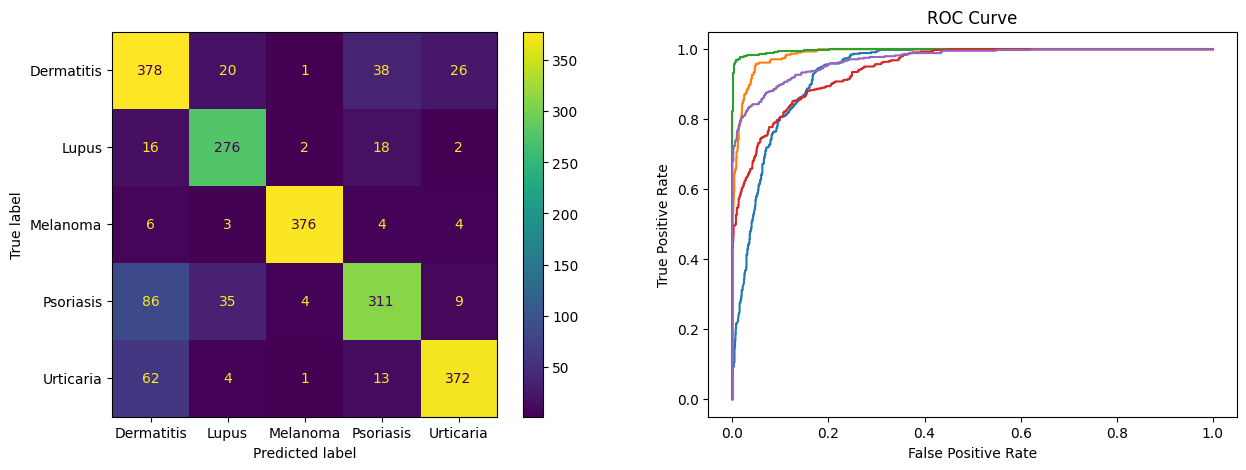

In [69]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

Best parameters: {'C': 3.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Training Results
Accuracy Score: 0.8761
Specificity Score: 0.8761
Precision Score: 0.8792
F1 Score: 0.8765

Testing Results
Accuracy Score: 0.8258
Specificity Score: 0.8258
Precision Score: 0.8312
F1 Score: 0.8267

Loss
Log loss: 0.44728423295090264

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.76      0.86      0.81      1803
       Lupus       0.90      0.93      0.92      1355
    Melanoma       0.98      0.97      0.98      1677
   Psoriasis       0.83      0.76      0.80      1668
   Urticaria       0.92      0.87      0.89      1764

    accuracy                           0.88      8267
   macro avg       0.88      0.88      0.88      8267
weighted avg       0.88      0.88      0.88      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.79      0.74       463
       Lupus    

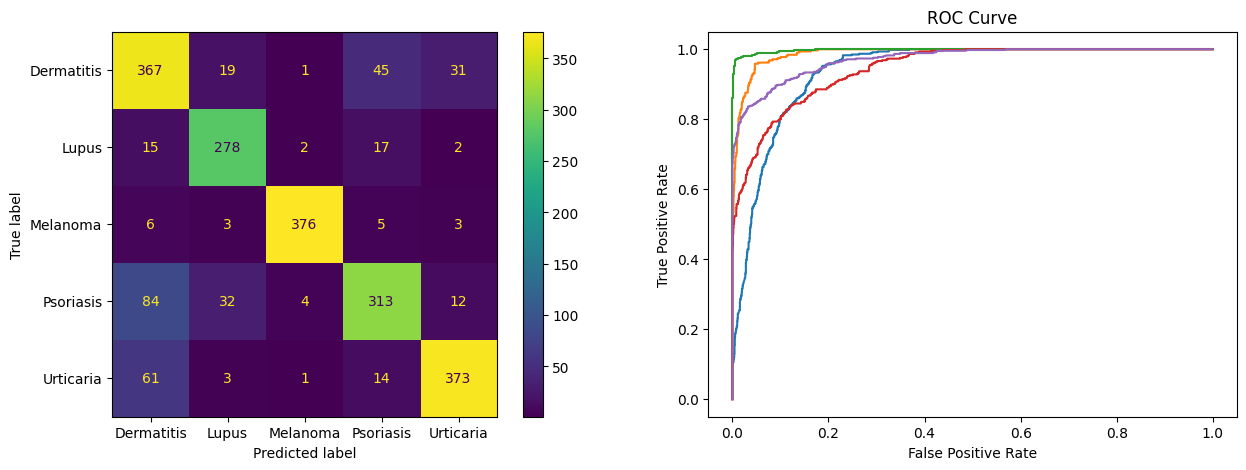

In [70]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

100%|███████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/trial, best loss: -0.8506113614102386]
Best hyperparameters: {'C': 3.058649900501603, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Training Results
Accuracy Score: 0.9291
Specificity Score: 0.9291
Precision Score: 0.9315
F1 Score: 0.9296

Testing Results
Accuracy Score: 0.8403
Specificity Score: 0.8403
Precision Score: 0.8471
F1 Score: 0.8419

Loss
Log loss: 0.4454653817557342

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.83      0.92      0.88      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.92      0.87      0.89      1668
   Urticaria       0.96      0.91      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification

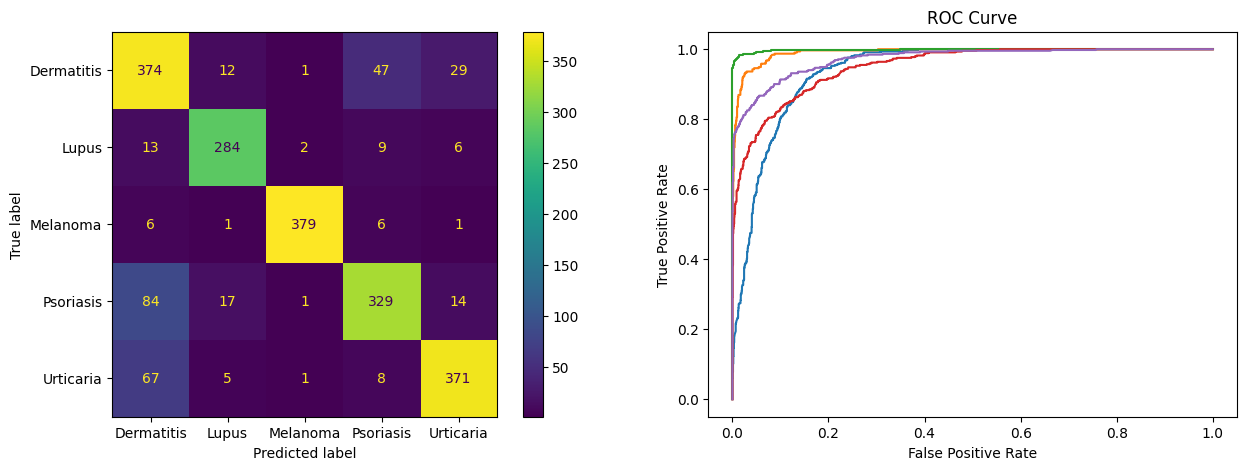

In [71]:
best_params = hyperopt_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

Best parameters: {'C': 4.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9265
Specificity Score: 0.9265
Precision Score: 0.9292
F1 Score: 0.9269

Testing Results
Accuracy Score: 0.8418
Specificity Score: 0.8418
Precision Score: 0.8482
F1 Score: 0.8432

Loss
Log loss: 0.45114836628738947

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.83      0.92      0.87      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.92      0.86      0.89      1668
   Urticaria       0.96      0.90      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.81      0.75       463
       Lupu

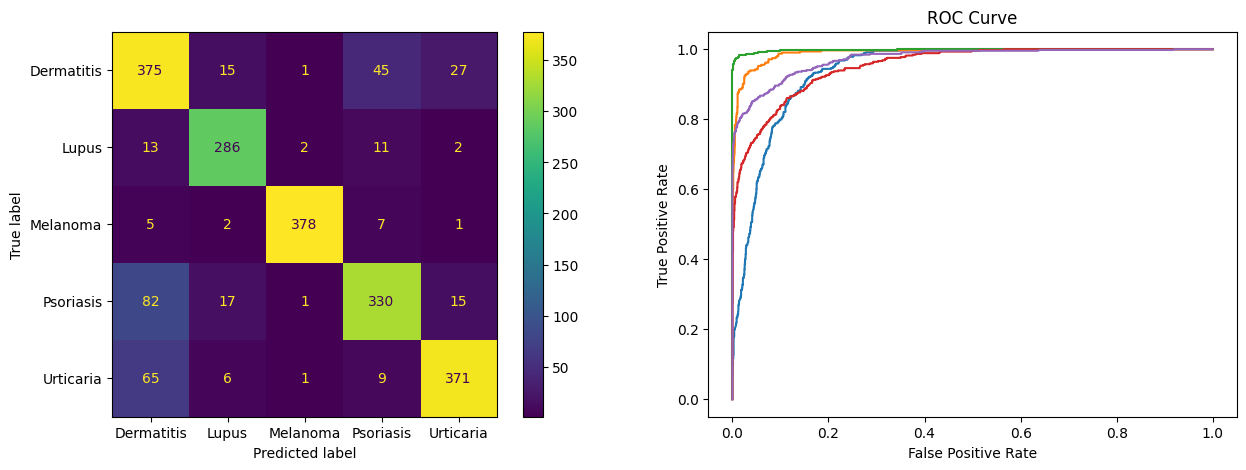

In [72]:
best_params = grid_search_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### With stemming

In [73]:
name = "LR_stem_"

**BoW** 

100%|███████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05trial/s, best loss: -0.8729892006838178]
Best hyperparameters: {'C': 1.4216577646369921, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9249
Specificity Score: 0.9249
Precision Score: 0.9272
F1 Score: 0.9253

Testing Results
Accuracy Score: 0.8708
Specificity Score: 0.8708
Precision Score: 0.8752
F1 Score: 0.8714

Loss
Log loss: 0.3427603372297637

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.83      0.92      0.87      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.91      0.85      0.88      1668
   Urticaria       0.96      0.92      0.94      1764

    accuracy                           0.92      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.92      0.93      8267


Classif

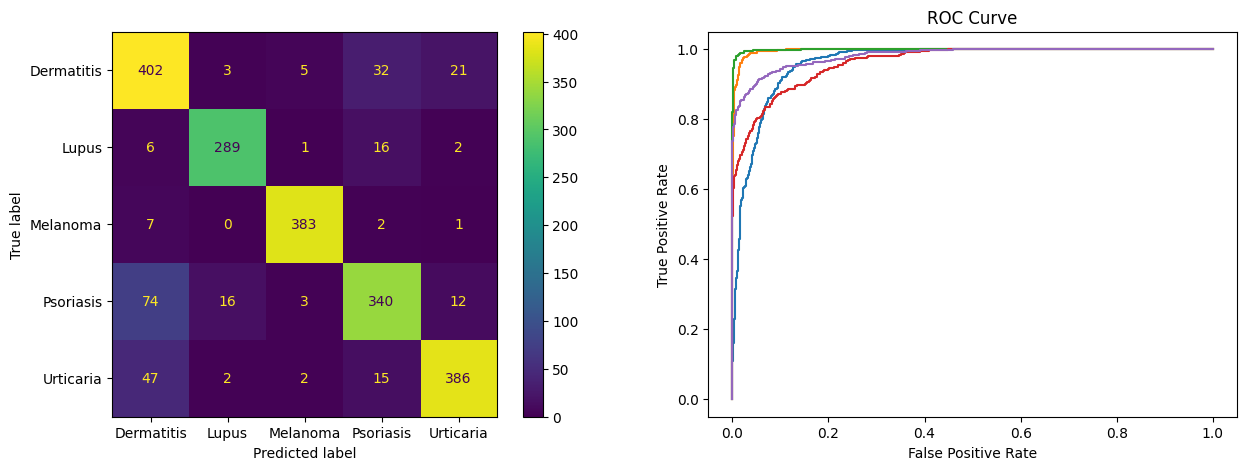

In [74]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

Best parameters: {'C': 1.0, 'max_iter': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.9265
Specificity Score: 0.9265
Precision Score: 0.9285
F1 Score: 0.9268

Testing Results
Accuracy Score: 0.8708
Specificity Score: 0.8708
Precision Score: 0.8752
F1 Score: 0.8716

Loss
Log loss: 0.33238060351738435

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.84      0.92      0.87      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.91      0.86      0.88      1668
   Urticaria       0.95      0.91      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.75      0.86      0.80       463
       Lupus

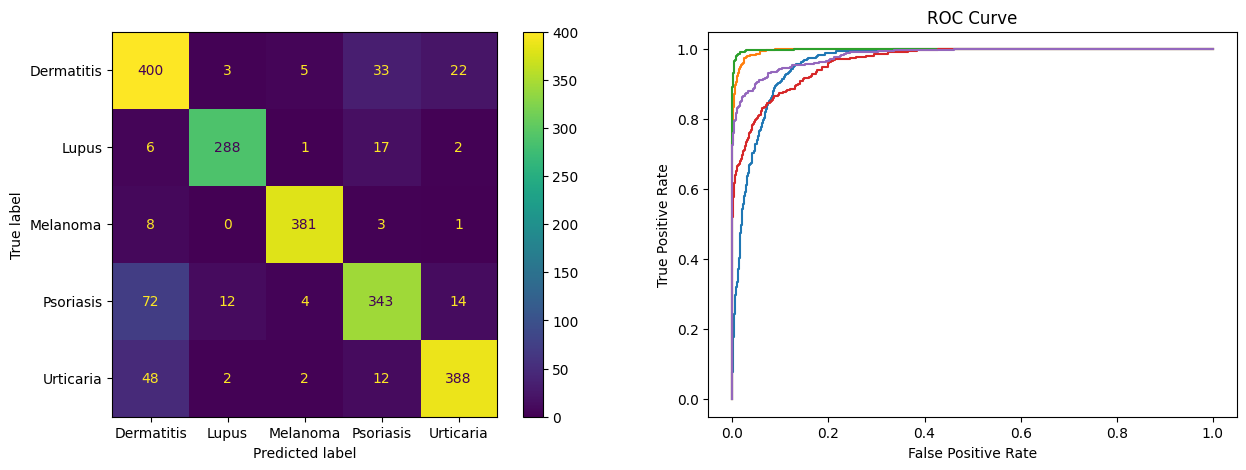

In [75]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

100%|███████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/trial, best loss: -0.8844812590204612]
Best hyperparameters: {'C': 5.499088639371885, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9988
Specificity Score: 0.9988
Precision Score: 0.9988
F1 Score: 0.9988

Testing Results
Accuracy Score: 0.8887
Specificity Score: 0.8887
Precision Score: 0.8923
F1 Score: 0.8894

Loss
Log loss: 0.3253274750802984

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classific

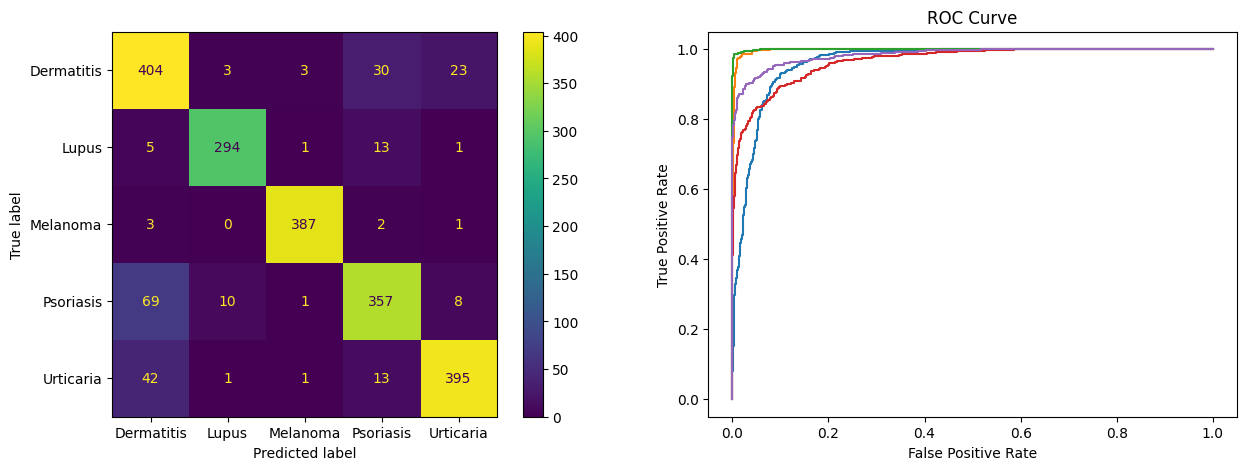

In [76]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

Best parameters: {'C': 2.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9984
Specificity Score: 0.9984
Precision Score: 0.9984
F1 Score: 0.9984

Testing Results
Accuracy Score: 0.8858
Specificity Score: 0.8858
Precision Score: 0.8898
F1 Score: 0.8866

Loss
Log loss: 0.3128649762186178

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.77      0.87      0.82       463
       Lupus

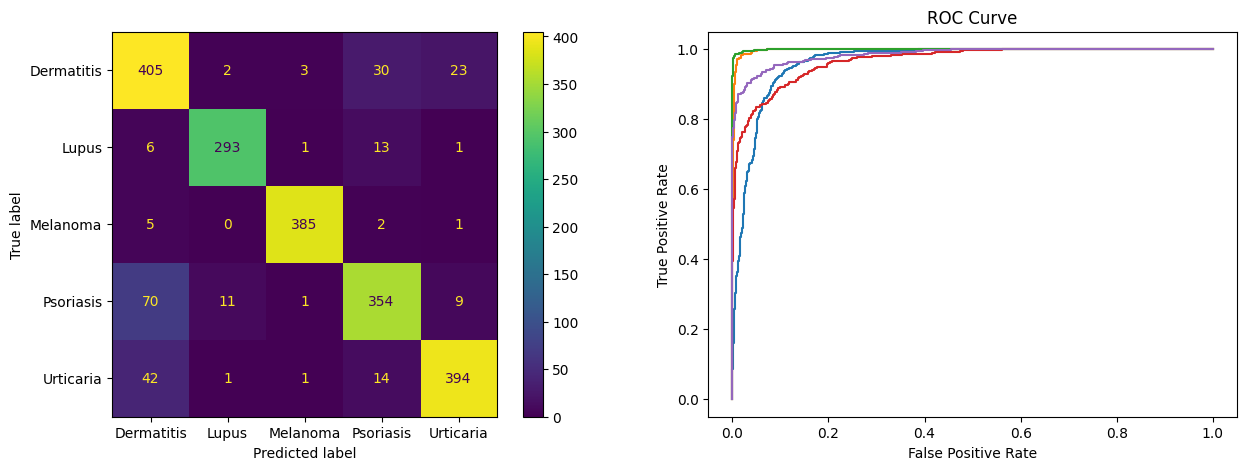

In [77]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

**TF-IDF**

100%|████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28trial/s, best loss: -0.877344186049914]
Best hyperparameters: {'C': 5.888693062432358, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9369
Specificity Score: 0.9369
Precision Score: 0.9383
F1 Score: 0.9370

Testing Results
Accuracy Score: 0.8708
Specificity Score: 0.8708
Precision Score: 0.8741
F1 Score: 0.8713

Loss
Log loss: 0.35279832825008917

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.86      0.93      0.89      1803
       Lupus       0.97      0.98      0.97      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.92      0.87      0.90      1668
   Urticaria       0.96      0.93      0.94      1764

    accuracy                           0.94      8267
   macro avg       0.94      0.94      0.94      8267
weighted avg       0.94      0.94      0.94      8267


Classif

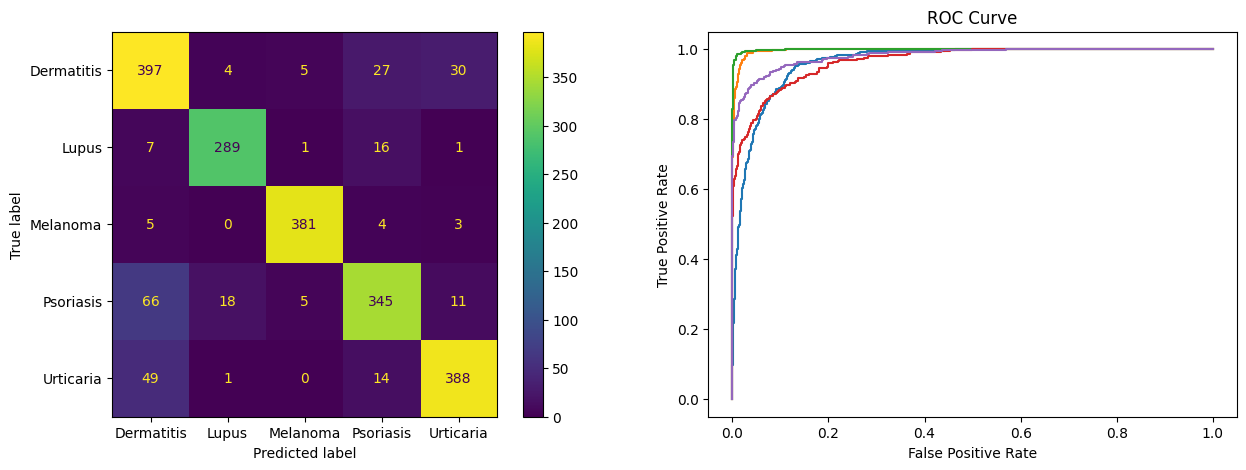

In [78]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

Best parameters: {'C': 3.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9257
Specificity Score: 0.9257
Precision Score: 0.9277
F1 Score: 0.9260

Testing Results
Accuracy Score: 0.8728
Specificity Score: 0.8728
Precision Score: 0.8761
F1 Score: 0.8731

Loss
Log loss: 0.3779857837913622

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.84      0.92      0.88      1803
       Lupus       0.96      0.97      0.96      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.91      0.85      0.88      1668
   Urticaria       0.95      0.91      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.86      0.81       463
       Lupus

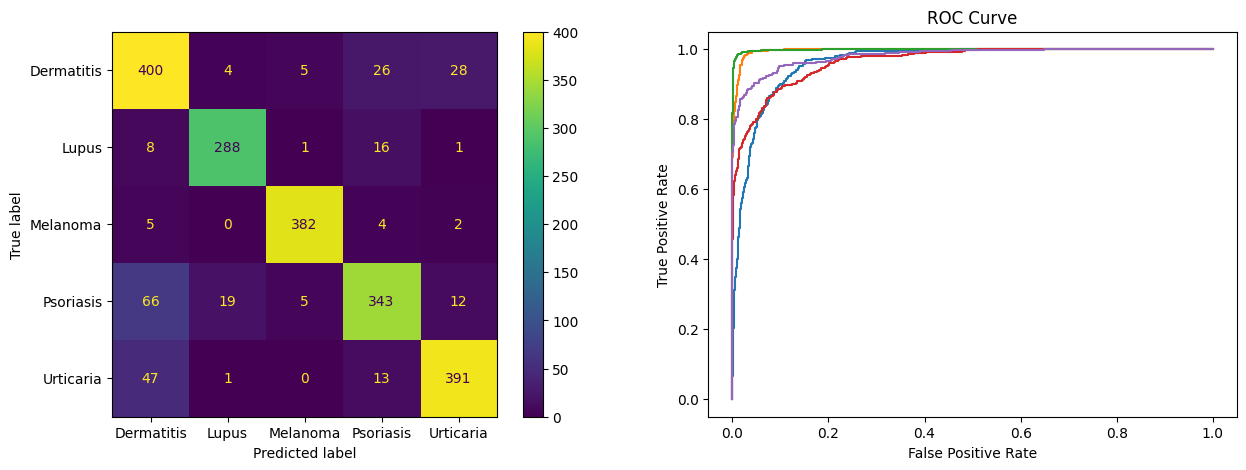

In [79]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

100%|███████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/trial, best loss: -0.8873852165751911]
Best hyperparameters: {'C': 9.705298074327454, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Training Results
Accuracy Score: 0.9988
Specificity Score: 0.9988
Precision Score: 0.9988
F1 Score: 0.9988

Testing Results
Accuracy Score: 0.8907
Specificity Score: 0.8907
Precision Score: 0.8944
F1 Score: 0.8915

Loss
Log loss: 0.35256976438889176

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classificati

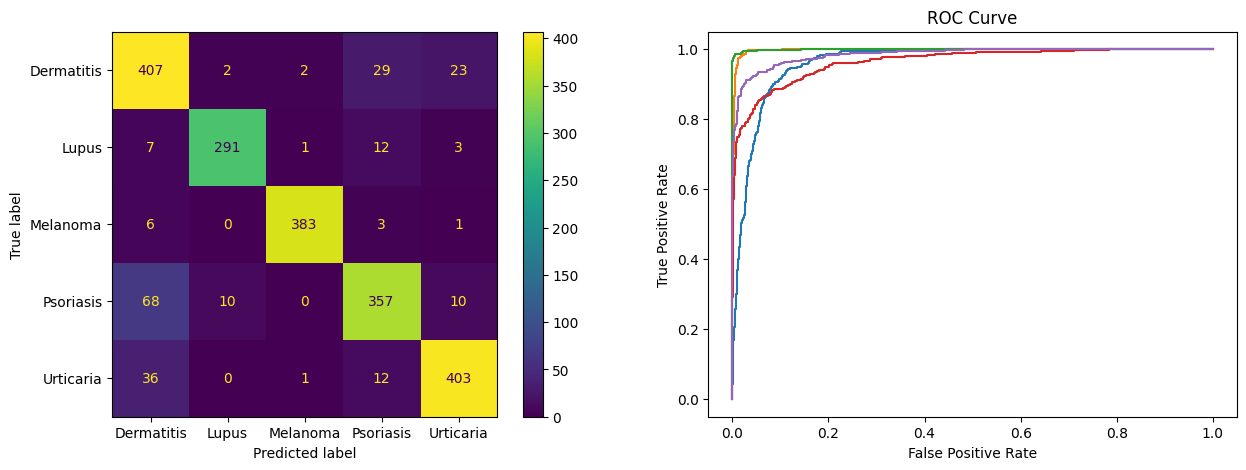

In [80]:
best_params = hyperopt_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

Best parameters: {'C': 9.0, 'max_iter': 100, 'penalty': None, 'solver': 'saga'}
Training Results
Accuracy Score: 0.9989
Specificity Score: 0.9989
Precision Score: 0.9989
F1 Score: 0.9989

Testing Results
Accuracy Score: 0.8931
Specificity Score: 0.8931
Precision Score: 0.8955
F1 Score: 0.8936

Loss
Log loss: 0.3563906935358779

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.79      0.87      0.83       463
       Lupus    

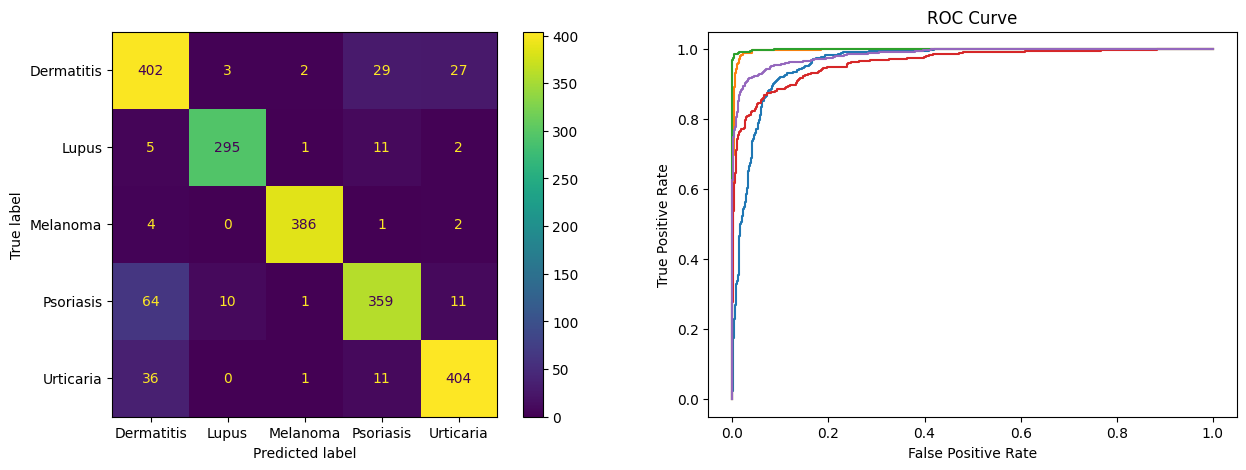

In [86]:
best_params = grid_search_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [87]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

0.8935548826264128


#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [34]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Random Search ####

In [35]:
def random_search_nb(X_train):
    param_grid = {
        'alpha': np.random.uniform(0.0, 2.0, 50),
        'fit_prior': [True, False],
        'class_prior': [None] + [np.random.dirichlet(np.ones(np.unique(y_train).shape[0])) for _ in range(50)]
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return score

    num_iterations = 50
    for _ in range(num_iterations):
        params = {k: np.random.choice(v) if k != 'class_prior' else v[np.random.randint(len(v))] for k, v in param_grid.items()}
        score = evaluate_params(params)
        if score > best_score:
            best_score = score
            best_params = params
    
    print("Best hyperparameters:", best_params)
    return best_params


##### Run Model

In [36]:
def model_nb(best_param, X_train, X_test, model_type):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [37]:
name = "NB_withoutyproc_"

**BoW** 

Best hyperparameters: {'alpha': 0.7044559937296238, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7376
Specificity Score: 0.7376
Precision Score: 0.7442
F1 Score: 0.7345

Testing Results
Accuracy Score: 0.6817
Specificity Score: 0.6817
Precision Score: 0.6892
F1 Score: 0.6786

Loss
Log loss: 0.7594235320445649

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.57      0.70      0.62      1803
       Lupus       0.83      0.85      0.84      1355
    Melanoma       0.93      0.98      0.95      1677
   Psoriasis       0.74      0.50      0.60      1668
   Urticaria       0.69      0.69      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.75      0.74      0.74      8267
weighted avg       0.74      0.74      0.73      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.51      0.63      0.56       463
    

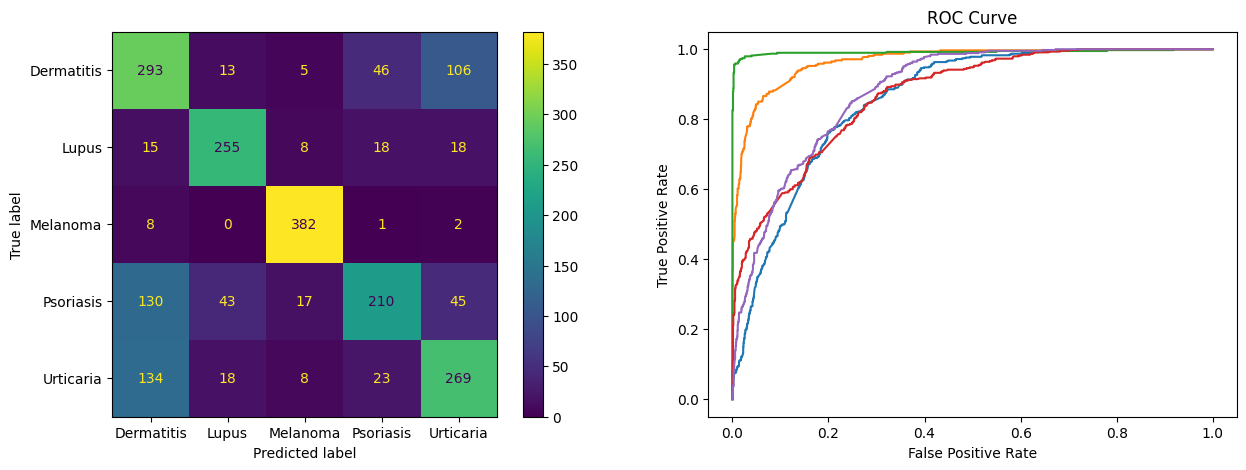

In [38]:
best_params = random_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 1.2859201522941381, 'fit_prior': False, 'class_prior': array([0.26022705, 0.18083391, 0.09753381, 0.18545709, 0.27594814])}
Training Results
Accuracy Score: 0.7581
Specificity Score: 0.7581
Precision Score: 0.7739
F1 Score: 0.7524

Testing Results
Accuracy Score: 0.7015
Specificity Score: 0.7015
Precision Score: 0.7162
F1 Score: 0.6973

Loss
Log loss: 0.796928094905649

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.63      0.72      0.67      1803
       Lupus       0.82      0.87      0.85      1355
    Melanoma       0.96      0.98      0.97      1677
   Psoriasis       0.85      0.46      0.60      1668
   Urticaria       0.64      0.78      0.70      1764

    accuracy                           0.76      8267
   macro avg       0.78      0.76      0.76      8267
weighted avg       0.77      0.76      0.75      8267


Classification Report Test
              precision    recall  f1-score   supp

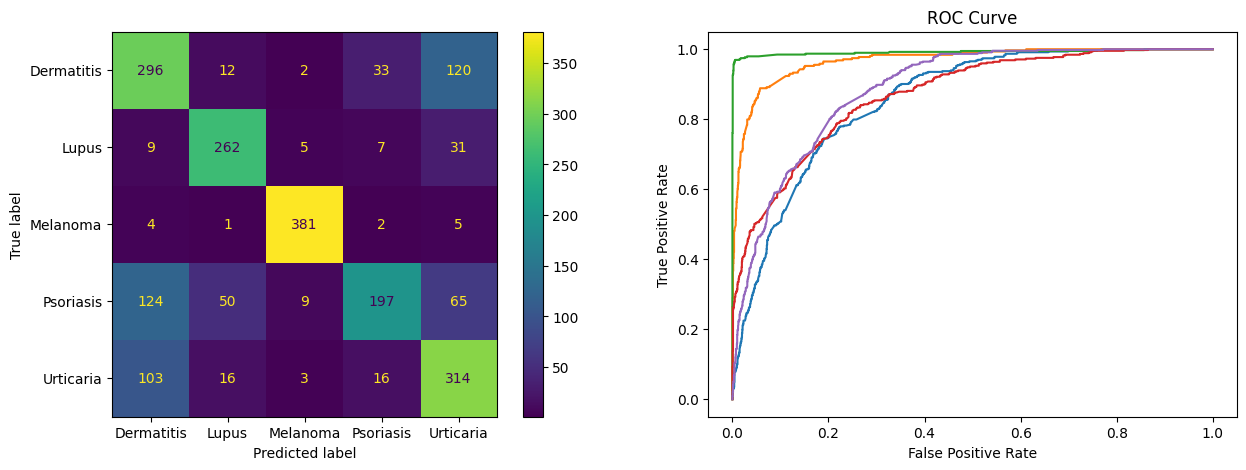

In [39]:
best_params = random_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 0.1231882264146662, 'fit_prior': False, 'class_prior': array([0.27582764, 0.34423144, 0.03861587, 0.09502644, 0.24629861])}
Training Results
Accuracy Score: 0.7091
Specificity Score: 0.7091
Precision Score: 0.7710
F1 Score: 0.6983

Testing Results
Accuracy Score: 0.6628
Specificity Score: 0.6628
Precision Score: 0.7329
F1 Score: 0.6553

Loss
Log loss: 0.9312120207435084

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.55      0.78      0.65      1803
       Lupus       0.64      0.94      0.76      1355
    Melanoma       1.00      0.80      0.89      1677
   Psoriasis       0.95      0.32      0.48      1668
   Urticaria       0.71      0.74      0.72      1764

    accuracy                           0.71      8267
   macro avg       0.77      0.72      0.70      8267
weighted avg       0.77      0.71      0.70      8267


Classification Report Test
              precision    recall  f1-score   sup

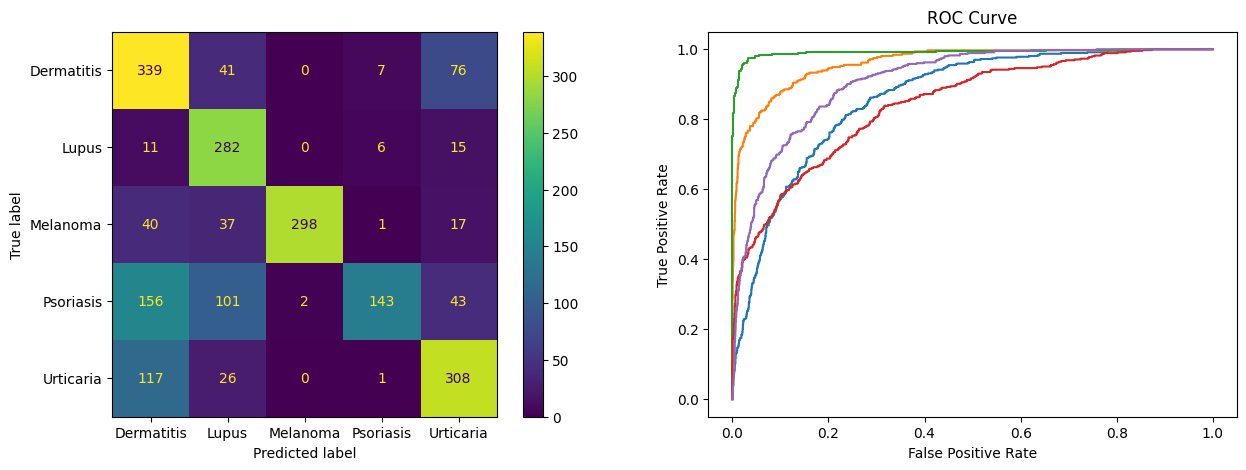

In [40]:
best_params = random_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.2848309400913609, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7864
Specificity Score: 0.7864
Precision Score: 0.7991
F1 Score: 0.7848

Testing Results
Accuracy Score: 0.7315
Specificity Score: 0.7315
Precision Score: 0.7464
F1 Score: 0.7310

Loss
Log loss: 0.7356287746986518

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.68      0.77      0.72      1803
       Lupus       0.95      0.74      0.83      1355
    Melanoma       0.88      0.98      0.93      1677
   Psoriasis       0.83      0.60      0.70      1668
   Urticaria       0.70      0.83      0.76      1764

    accuracy                           0.79      8267
   macro avg       0.81      0.78      0.79      8267
weighted avg       0.80      0.79      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.70      0.64       463
    

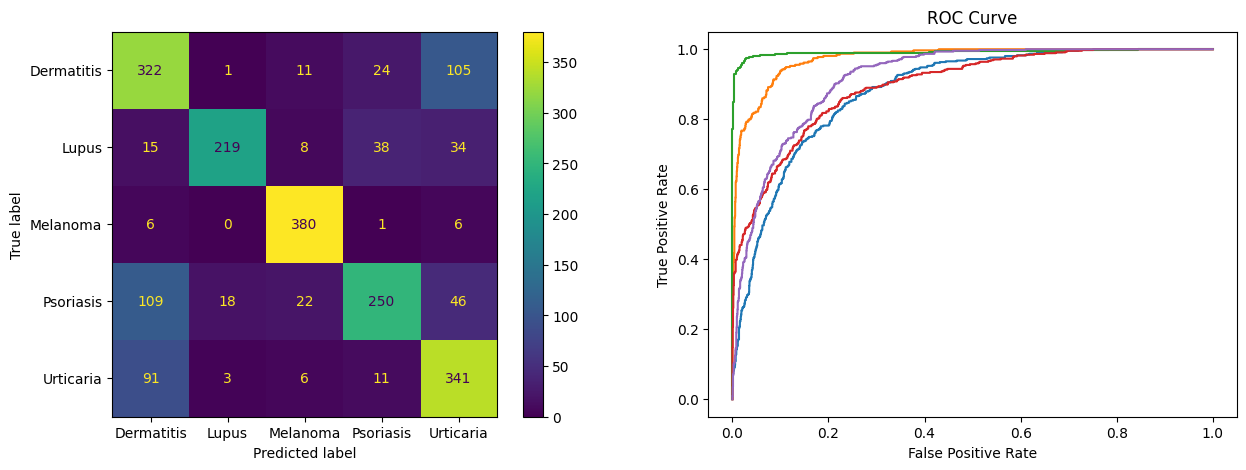

In [41]:
best_params = random_search_nb(X_train_tfidf_ngram_noproc)
model_nb(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [42]:
name = "NB_withproc_"

**BoW** 

Best hyperparameters: {'alpha': 0.3920460146462119, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7398
Specificity Score: 0.7398
Precision Score: 0.7394
F1 Score: 0.7364

Testing Results
Accuracy Score: 0.6909
Specificity Score: 0.6909
Precision Score: 0.6925
F1 Score: 0.6878

Loss
Log loss: 0.7691362710953173

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.60      0.67      0.63      1803
       Lupus       0.83      0.84      0.83      1355
    Melanoma       0.90      0.98      0.94      1677
   Psoriasis       0.71      0.54      0.61      1668
   Urticaria       0.69      0.70      0.70      1764

    accuracy                           0.74      8267
   macro avg       0.75      0.74      0.74      8267
weighted avg       0.74      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.53      0.63      0.58       463
    

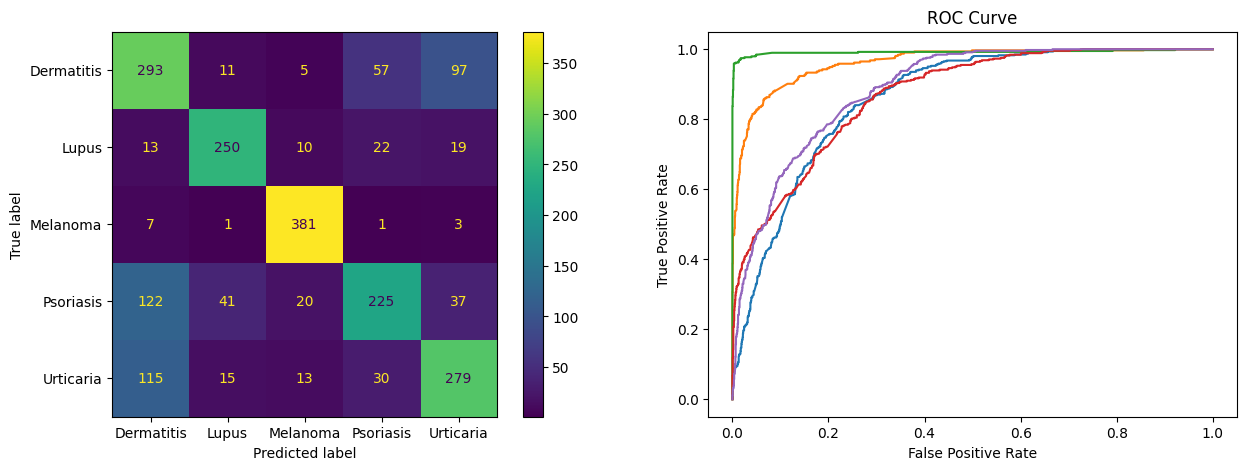

In [43]:
best_params = random_search_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.017140015477458803, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7850
Specificity Score: 0.7850
Precision Score: 0.7848
F1 Score: 0.7834

Testing Results
Accuracy Score: 0.6991
Specificity Score: 0.6991
Precision Score: 0.6994
F1 Score: 0.6976

Loss
Log loss: 1.062861946546504

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.72      0.69      1803
       Lupus       0.85      0.88      0.86      1355
    Melanoma       0.95      0.99      0.97      1677
   Psoriasis       0.75      0.63      0.68      1668
   Urticaria       0.75      0.73      0.74      1764

    accuracy                           0.79      8267
   macro avg       0.79      0.79      0.79      8267
weighted avg       0.78      0.79      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.53      0.61      0.57       463
  

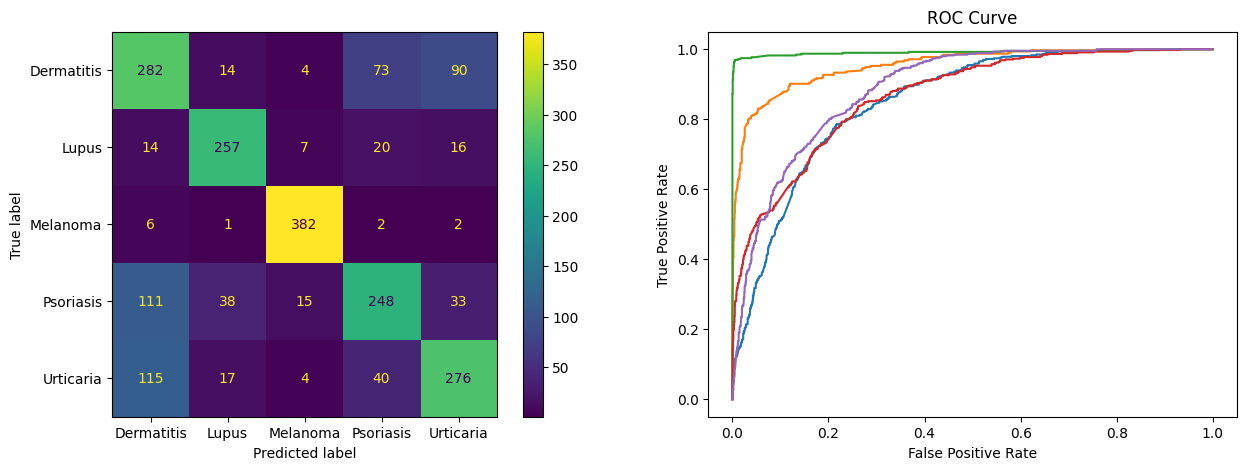

In [44]:
best_params = random_search_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.5827481928149039, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7437
Specificity Score: 0.7437
Precision Score: 0.7421
F1 Score: 0.7399

Testing Results
Accuracy Score: 0.7030
Specificity Score: 0.7030
Precision Score: 0.7025
F1 Score: 0.6987

Loss
Log loss: 0.8256073620165968

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.64      0.61      0.63      1803
       Lupus       0.81      0.84      0.82      1355
    Melanoma       0.90      0.98      0.94      1677
   Psoriasis       0.74      0.58      0.65      1668
   Urticaria       0.65      0.74      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.75      0.75      0.75      8267
weighted avg       0.74      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.58      0.58       463
   

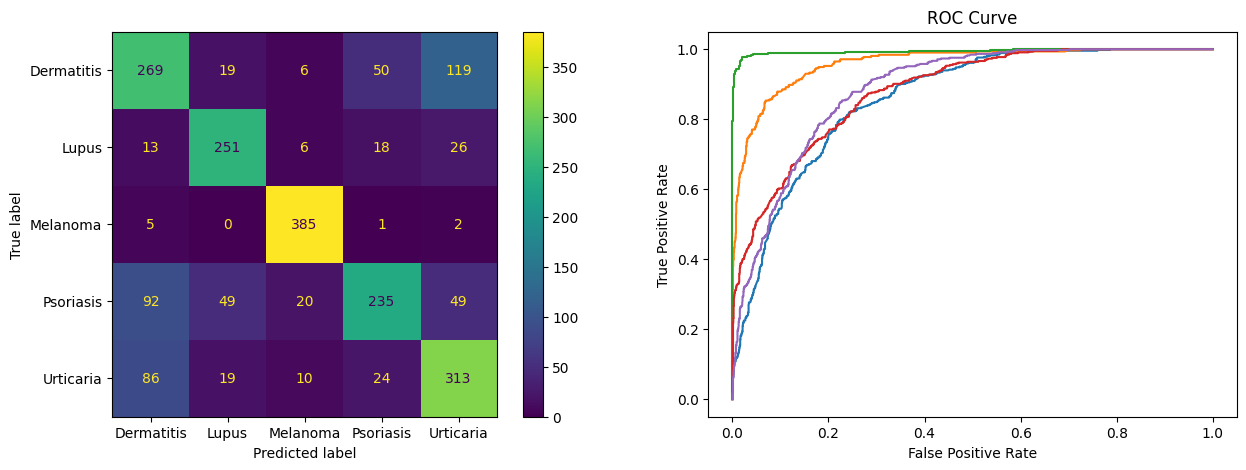

In [45]:
best_params = random_search_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 1.462893132055172, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7890
Specificity Score: 0.7890
Precision Score: 0.7967
F1 Score: 0.7896

Testing Results
Accuracy Score: 0.7092
Specificity Score: 0.7092
Precision Score: 0.7188
F1 Score: 0.7101

Loss
Log loss: 0.8051275454231327

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.67      0.72      0.70      1803
       Lupus       0.91      0.80      0.85      1355
    Melanoma       0.95      0.99      0.97      1677
   Psoriasis       0.81      0.66      0.73      1668
   Urticaria       0.68      0.78      0.73      1764

    accuracy                           0.79      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.80      0.79      0.79      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.55      0.62      0.58       463
     

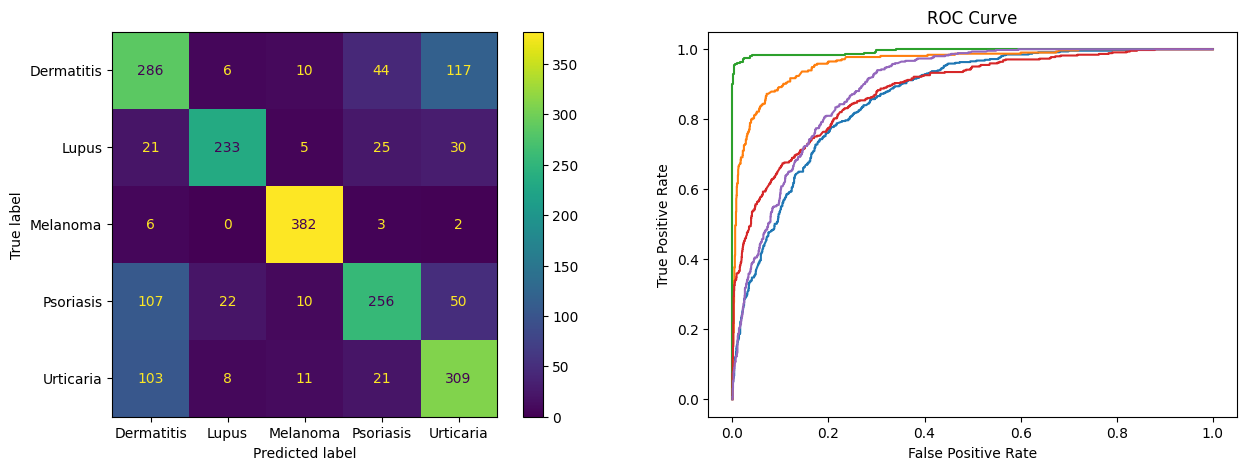

In [46]:
best_params = random_search_nb(X_train_tfidf_ngram_proc)
model_nb(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lematization

In [47]:
name = "NB_lem_"

**BoW** 

Best hyperparameters: {'alpha': 0.9797863913446936, 'fit_prior': True, 'class_prior': array([0.24379365, 0.25257986, 0.14447813, 0.18948913, 0.16965923])}
Training Results
Accuracy Score: 0.8262
Specificity Score: 0.8262
Precision Score: 0.8317
F1 Score: 0.8253

Testing Results
Accuracy Score: 0.7987
Specificity Score: 0.7987
Precision Score: 0.8050
F1 Score: 0.7976

Loss
Log loss: 0.5368956612557911

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.80      0.74      1803
       Lupus       0.82      0.92      0.86      1355
    Melanoma       0.95      0.95      0.95      1677
   Psoriasis       0.83      0.65      0.73      1668
   Urticaria       0.88      0.83      0.85      1764

    accuracy                           0.83      8267
   macro avg       0.83      0.83      0.83      8267
weighted avg       0.83      0.83      0.83      8267


Classification Report Test
              precision    recall  f1-score   supp

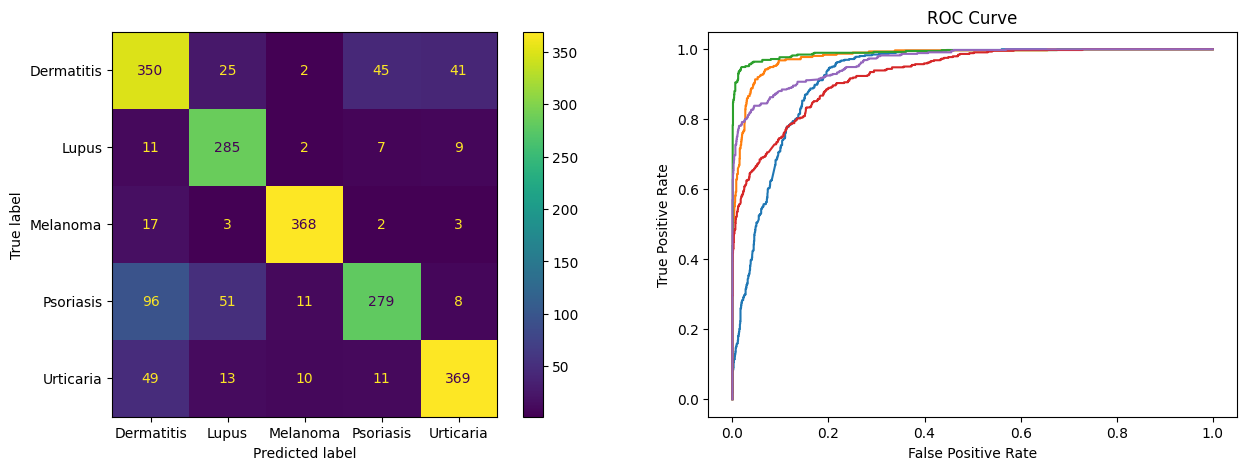

In [48]:
best_params = random_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.10604597478075117, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8690
Specificity Score: 0.8690
Precision Score: 0.8693
F1 Score: 0.8682

Testing Results
Accuracy Score: 0.8021
Specificity Score: 0.8021
Precision Score: 0.8016
F1 Score: 0.8007

Loss
Log loss: 0.7192285190422543

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.78      0.80      0.79      1803
       Lupus       0.91      0.92      0.92      1355
    Melanoma       0.95      0.98      0.96      1677
   Psoriasis       0.87      0.76      0.81      1668
   Urticaria       0.85      0.90      0.87      1764

    accuracy                           0.87      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.70      0.69       463
   

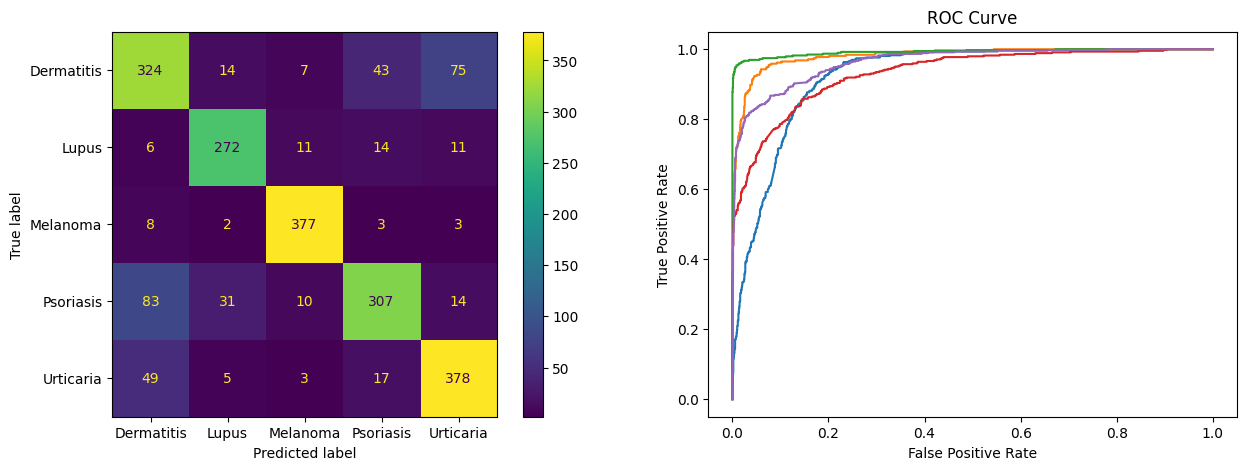

In [49]:
best_params = random_search_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.0045350449766937, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.8173
Specificity Score: 0.8173
Precision Score: 0.8151
F1 Score: 0.8139

Testing Results
Accuracy Score: 0.7808
Specificity Score: 0.7808
Precision Score: 0.7787
F1 Score: 0.7770

Loss
Log loss: 0.615491974896903

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.76      0.69      0.72      1803
       Lupus       0.85      0.88      0.87      1355
    Melanoma       0.90      0.97      0.93      1677
   Psoriasis       0.80      0.68      0.73      1668
   Urticaria       0.78      0.88      0.83      1764

    accuracy                           0.82      8267
   macro avg       0.82      0.82      0.82      8267
weighted avg       0.82      0.82      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.65      0.67       463
    

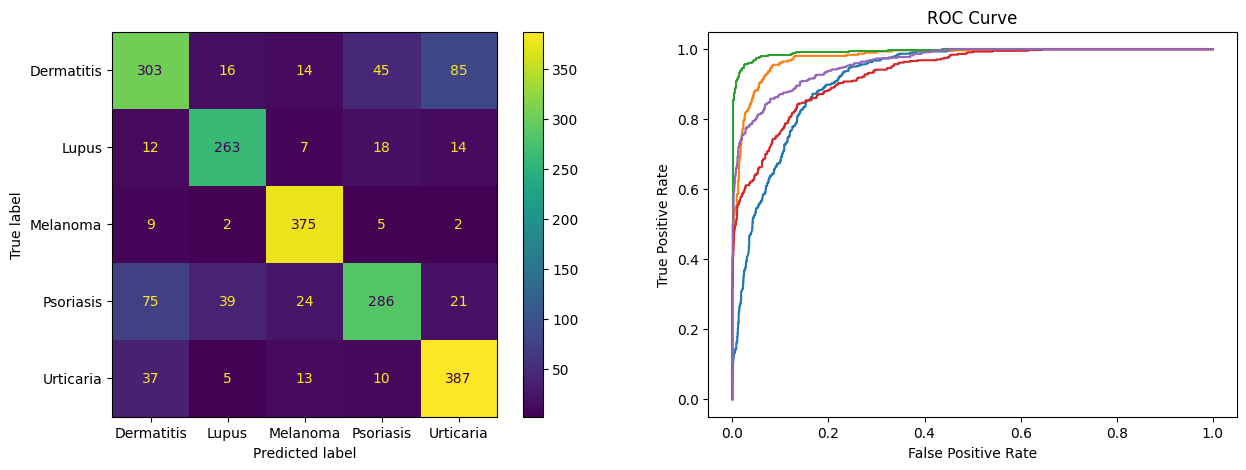

In [50]:
best_params = random_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 1.4058041156867522, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8613
Specificity Score: 0.8613
Precision Score: 0.8646
F1 Score: 0.8613

Testing Results
Accuracy Score: 0.8079
Specificity Score: 0.8079
Precision Score: 0.8121
F1 Score: 0.8073

Loss
Log loss: 0.6121269945157776

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.77      0.81      0.79      1803
       Lupus       0.95      0.86      0.90      1355
    Melanoma       0.96      0.97      0.97      1677
   Psoriasis       0.87      0.76      0.81      1668
   Urticaria       0.81      0.90      0.85      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.86      0.86      8267
weighted avg       0.86      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.71       463
    

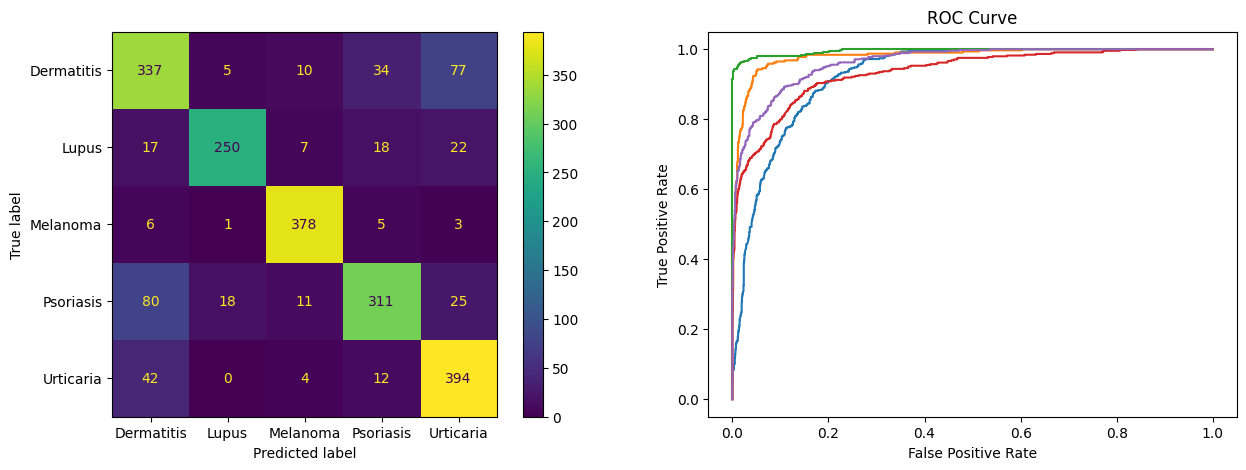

In [51]:
best_params = random_search_nb(X_train_tfidf_ngram_lem)
model_nb(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [52]:
name = "NB_stem_"

**BoW** 

Best hyperparameters: {'alpha': 0.3915768055076294, 'fit_prior': True, 'class_prior': array([0.40007782, 0.10827058, 0.09226798, 0.35436861, 0.04501501])}
Training Results
Accuracy Score: 0.8648
Specificity Score: 0.8648
Precision Score: 0.8719
F1 Score: 0.8662

Testing Results
Accuracy Score: 0.8350
Specificity Score: 0.8350
Precision Score: 0.8432
F1 Score: 0.8370

Loss
Log loss: 0.5036595818626867

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.86      0.79      1803
       Lupus       0.92      0.93      0.93      1355
    Melanoma       0.98      0.96      0.97      1677
   Psoriasis       0.80      0.79      0.80      1668
   Urticaria       0.94      0.81      0.87      1764

    accuracy                           0.86      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.86      0.87      8267


Classification Report Test
              precision    recall  f1-score   supp

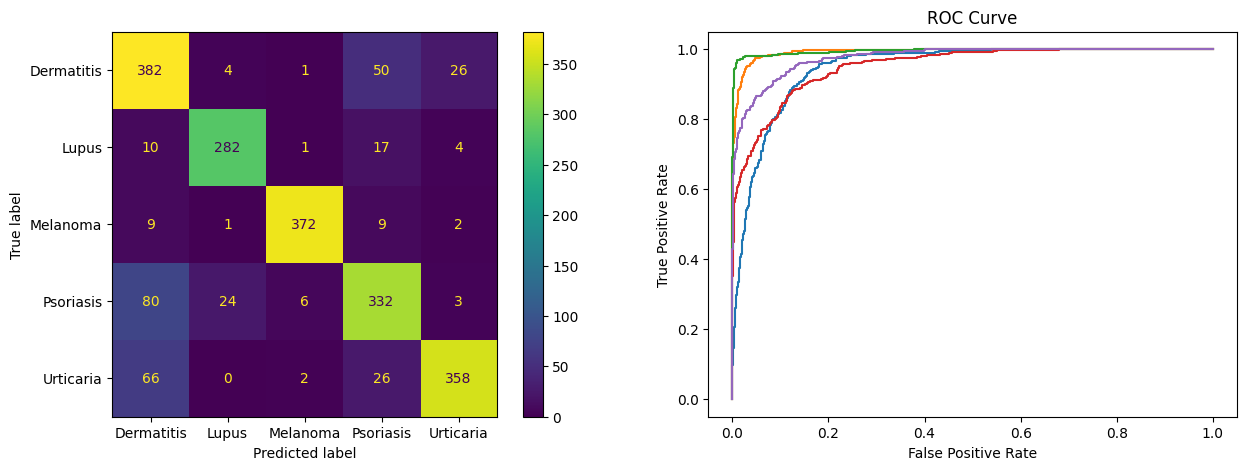

In [53]:
best_params = random_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.15425048904127503, 'fit_prior': False, 'class_prior': array([0.2324646 , 0.14370749, 0.52203058, 0.03892938, 0.06286795])}
Training Results
Accuracy Score: 0.9763
Specificity Score: 0.9763
Precision Score: 0.9766
F1 Score: 0.9762

Testing Results
Accuracy Score: 0.8626
Specificity Score: 0.8626
Precision Score: 0.8655
F1 Score: 0.8620

Loss
Log loss: 1.0932068186975425

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.95      0.97      0.96      1803
       Lupus       0.98      1.00      0.99      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.99      0.93      0.96      1668
   Urticaria       0.97      0.98      0.98      1764

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267


Classification Report Test
              precision    recall  f1-score   su

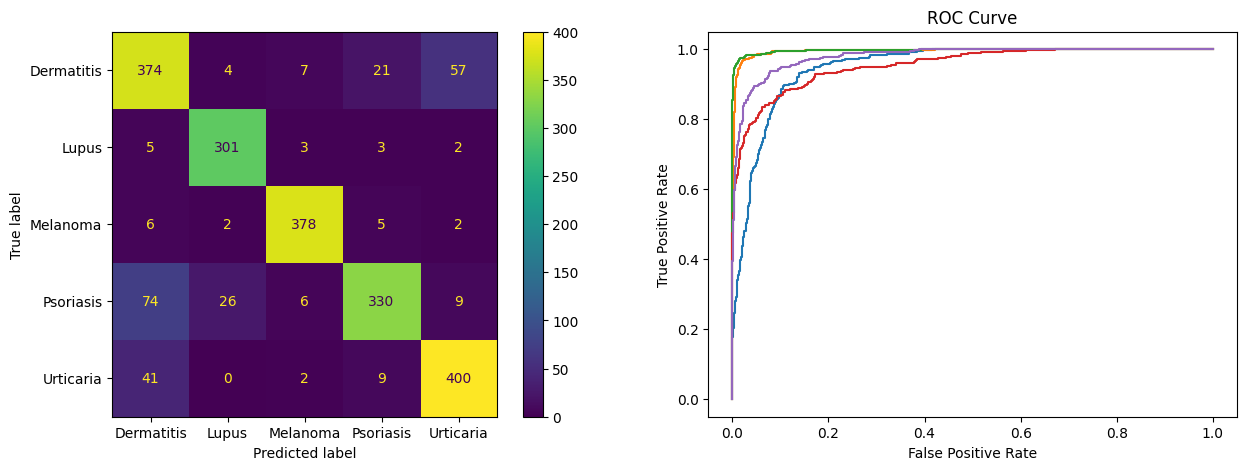

In [54]:
best_params = random_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.7647562268338013, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8479
Specificity Score: 0.8479
Precision Score: 0.8489
F1 Score: 0.8458

Testing Results
Accuracy Score: 0.8186
Specificity Score: 0.8186
Precision Score: 0.8199
F1 Score: 0.8158

Loss
Log loss: 0.5934976551749357

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.81      0.70      0.75      1803
       Lupus       0.91      0.91      0.91      1355
    Melanoma       0.93      0.97      0.95      1677
   Psoriasis       0.84      0.76      0.80      1668
   Urticaria       0.77      0.91      0.84      1764

    accuracy                           0.85      8267
   macro avg       0.85      0.85      0.85      8267
weighted avg       0.85      0.85      0.85      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.65      0.70       463
    

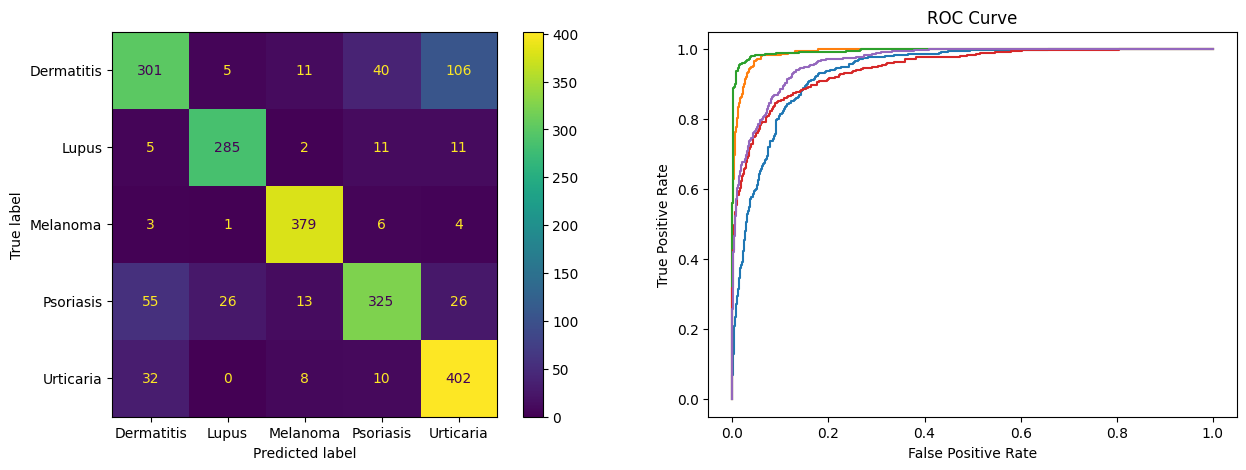

In [55]:
best_params = random_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.5553767041912949, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.9613
Specificity Score: 0.9613
Precision Score: 0.9619
F1 Score: 0.9612

Testing Results
Accuracy Score: 0.8592
Specificity Score: 0.8592
Precision Score: 0.8613
F1 Score: 0.8585

Loss
Log loss: 0.5147580582252423

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.94      0.94      0.94      1803
       Lupus       0.98      0.99      0.98      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.98      0.91      0.94      1668
   Urticaria       0.93      0.98      0.95      1764

    accuracy                           0.96      8267
   macro avg       0.96      0.96      0.96      8267
weighted avg       0.96      0.96      0.96      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.78      0.76      0.77       463
    

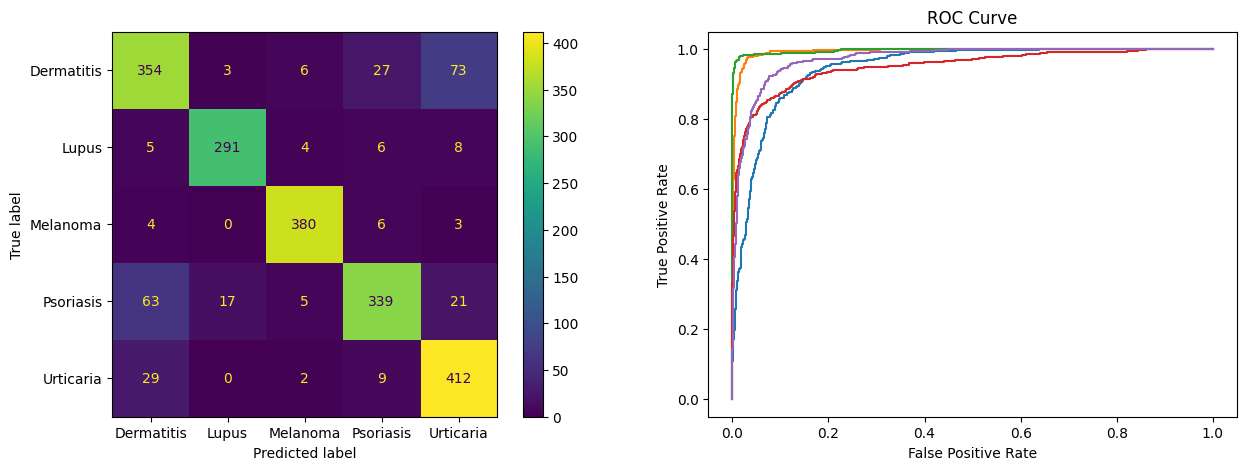

In [56]:
best_params = random_search_nb(X_train_tfidf_ngram_stem)
model_nb(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [57]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

0.8620219174436214


#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [58]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

In [59]:
def train_and_evaluate(params, X_train, y_train):
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

##### Random Search #####

In [60]:
def random_search_svm(X_train):
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        score = train_and_evaluate(params, X_train, y_train)
        return score

    num_iterations = 50
    num_jobs = 4  # Número de trabalhos em paralelo
    results = Parallel(n_jobs=num_jobs)(delayed(evaluate_params)({k: np.random.choice(v) for k, v in param_grid.items()}) for _ in range(num_iterations))
    
    best_index = np.argmax(results)
    best_params = {k: np.random.choice(v) for k, v in param_grid.items()}
    best_score = results[best_index]
    
    print("Best hyperparameters:", best_params)
    return best_params

##### Run Model

In [61]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(probability=True,C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['kernel'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [62]:
name = "SVM_withoutyproc_"

**BoW** 

Best hyperparameters: {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.7390
Specificity Score: 0.7390
Precision Score: 0.7582
F1 Score: 0.7380

Testing Results
Accuracy Score: 0.6976
Specificity Score: 0.6976
Precision Score: 0.7165
F1 Score: 0.6959

Loss
Log loss: 0.7190441601863627

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.58      0.69      0.63      1803
       Lupus       0.86      0.84      0.85      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.81      0.48      0.60      1668
   Urticaria       0.60      0.72      0.65      1764

    accuracy                           0.74      8267
   macro avg       0.77      0.74      0.74      8267
weighted avg       0.76      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.54      0.66      0.59       463
       Lupus       0.82   

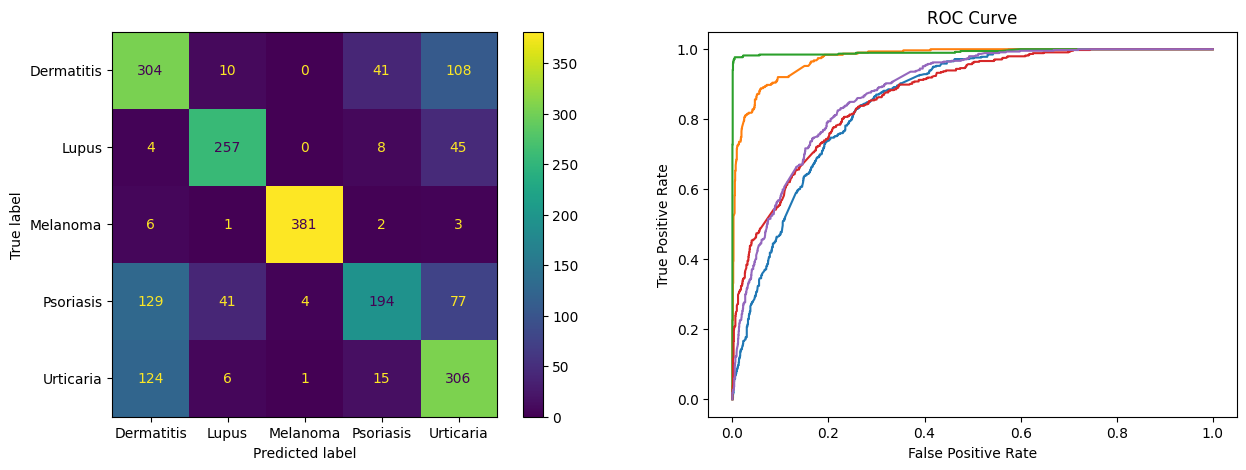

In [63]:
best_params = random_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.7640
Specificity Score: 0.7640
Precision Score: 0.7855
F1 Score: 0.7636

Testing Results
Accuracy Score: 0.7107
Specificity Score: 0.7107
Precision Score: 0.7322
F1 Score: 0.7085

Loss
Log loss: 0.7083265079906299

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.62      0.71      0.66      1803
       Lupus       0.88      0.86      0.87      1355
    Melanoma       1.00      0.98      0.99      1677
   Psoriasis       0.86      0.52      0.64      1668
   Urticaria       0.61      0.77      0.68      1764

    accuracy                           0.76      8267
   macro avg       0.79      0.77      0.77      8267
weighted avg       0.79      0.76      0.76      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.56      0.67      0.61       463
       Lupus       0.84      0

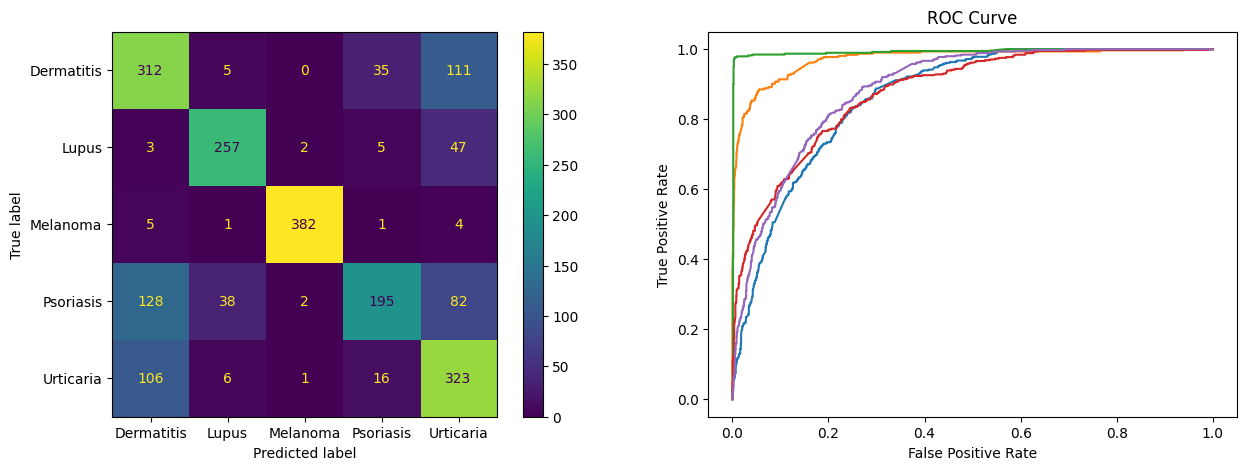

In [64]:
best_params = random_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8628
Specificity Score: 0.8628
Precision Score: 0.8662
F1 Score: 0.8629

Testing Results
Accuracy Score: 0.7644
Specificity Score: 0.7644
Precision Score: 0.7724
F1 Score: 0.7654

Loss
Log loss: 0.5999120678706503

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.73      0.83      0.78      1803
       Lupus       0.93      0.93      0.93      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.85      0.73      0.78      1668
   Urticaria       0.84      0.84      0.84      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.75      0.67       463
       Lupus       0.85  

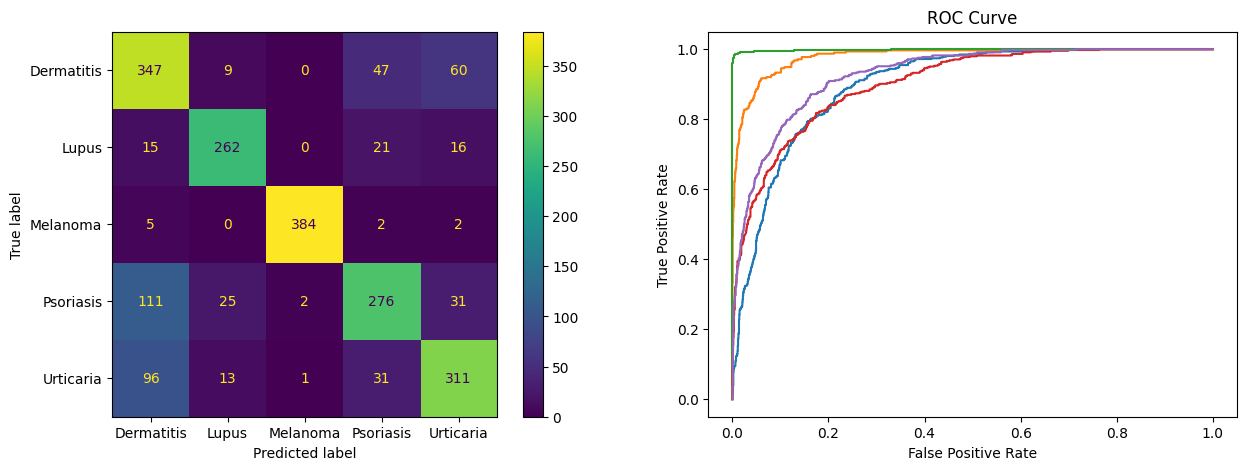

In [65]:
best_params = random_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2191
Specificity Score: 0.2191
Precision Score: 0.2036
F1 Score: 0.0805

Testing Results
Accuracy Score: 0.2264
Specificity Score: 0.2264
Precision Score: 0.2404
F1 Score: 0.0869

Loss
Log loss: 1.2279285936879005

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.77      0.01      0.01      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.20      0.20      0.07      8267
weighted avg       0.20      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      0.

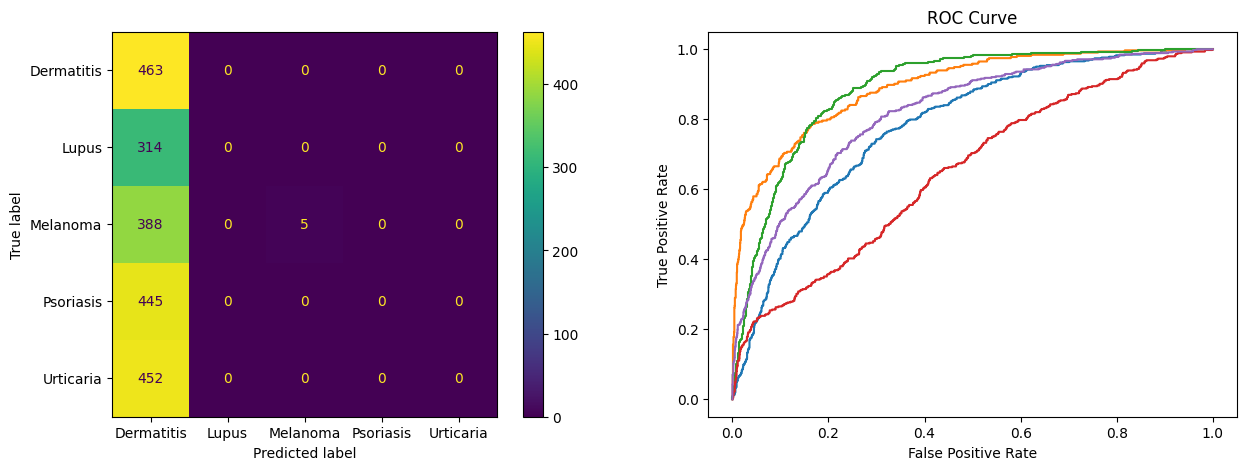

In [66]:
best_params = random_search_svm(X_train_tfidf_ngram_noproc)
model_svm(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [67]:
name = "SVM_withproc_"

**BoW** 

Best hyperparameters: {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.8850
Specificity Score: 0.8850
Precision Score: 0.8865
F1 Score: 0.8853

Testing Results
Accuracy Score: 0.6942
Specificity Score: 0.6942
Precision Score: 0.7012
F1 Score: 0.6959

Loss
Log loss: 0.858353105279769

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.79      0.86      0.82      1803
       Lupus       0.96      0.94      0.95      1355
    Melanoma       1.00      0.99      1.00      1677
   Psoriasis       0.83      0.80      0.81      1668
   Urticaria       0.88      0.85      0.86      1764

    accuracy                           0.88      8267
   macro avg       0.89      0.89      0.89      8267
weighted avg       0.89      0.88      0.89      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.63      0.60       463
       Lupus       0.79      0

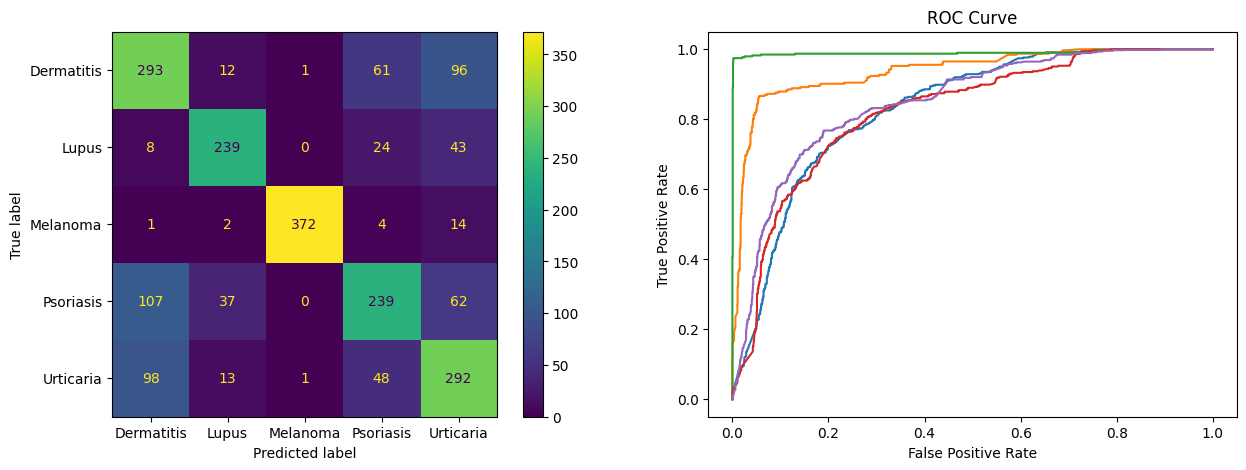

In [68]:
best_params = random_search_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.1, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8360
Specificity Score: 0.8360
Precision Score: 0.8416
F1 Score: 0.8362

Testing Results
Accuracy Score: 0.6942
Specificity Score: 0.6942
Precision Score: 0.7057
F1 Score: 0.6951

Loss
Log loss: 0.7338307166918759

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.81      0.74      1803
       Lupus       0.92      0.92      0.92      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.82      0.68      0.74      1668
   Urticaria       0.81      0.81      0.81      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.84      0.84      8267
weighted avg       0.84      0.84      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.51      0.66      0.57       463
       Lupus       0.77   

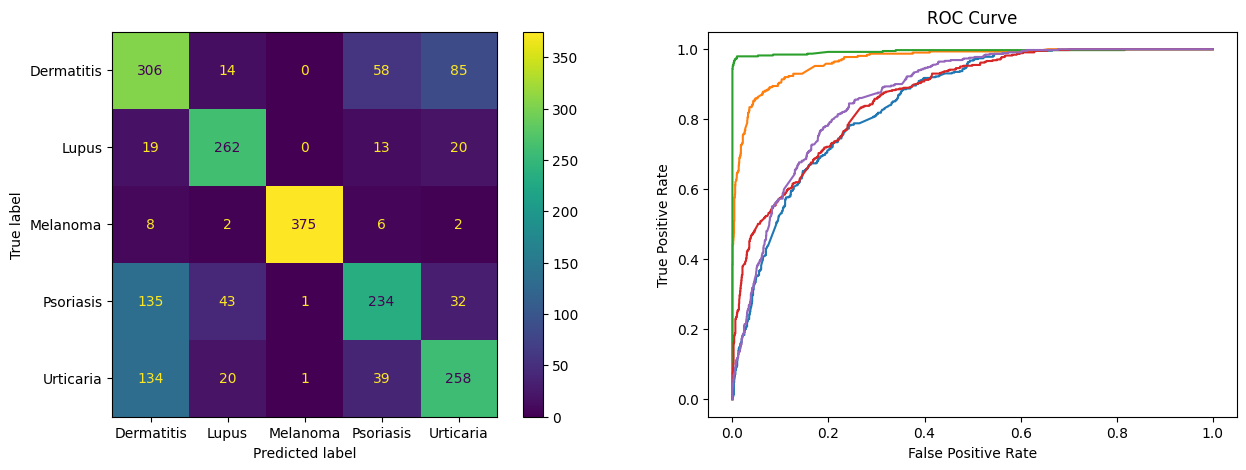

In [69]:
best_params = random_search_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8194
Specificity Score: 0.8194
Precision Score: 0.8207
F1 Score: 0.8192

Testing Results
Accuracy Score: 0.7131
Specificity Score: 0.7131
Precision Score: 0.7139
F1 Score: 0.7131

Loss
Log loss: 0.6918789053958677

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.72      1803
       Lupus       0.90      0.91      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.79      0.69      0.74      1668
   Urticaria       0.75      0.79      0.77      1764

    accuracy                           0.82      8267
   macro avg       0.83      0.82      0.82      8267
weighted avg       0.82      0.82      0.82      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.62      0.60       463
       Lupus       0.80  

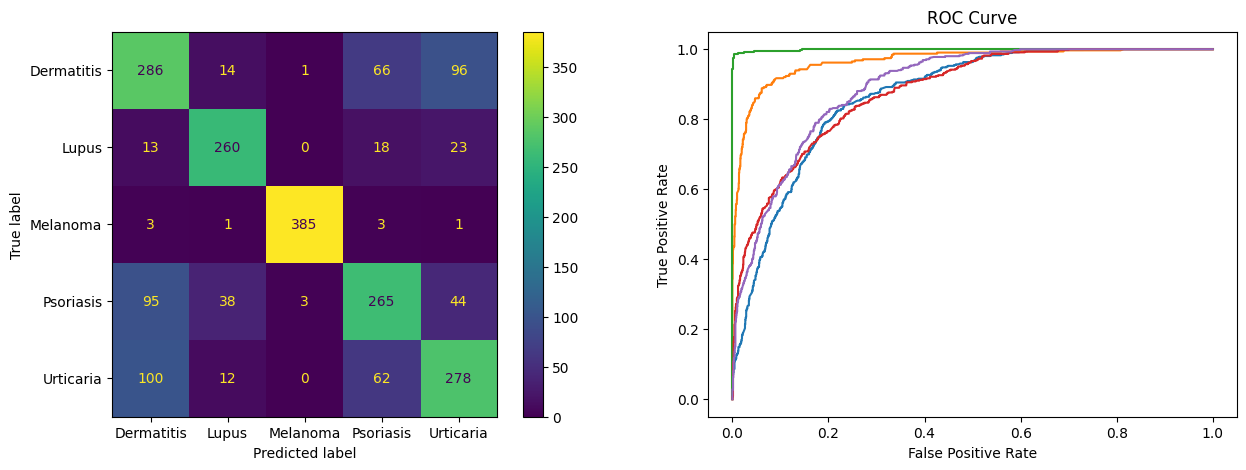

In [70]:
best_params = random_search_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8407
Specificity Score: 0.8407
Precision Score: 0.8451
F1 Score: 0.8410

Testing Results
Accuracy Score: 0.7412
Specificity Score: 0.7412
Precision Score: 0.7483
F1 Score: 0.7425

Loss
Log loss: 0.6524126919786686

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.75      0.76      0.76      1803
       Lupus       0.93      0.90      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.84      0.72      0.77      1668
   Urticaria       0.74      0.85      0.79      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.84      0.85      8267
weighted avg       0.85      0.84      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.62      0.61       463
       Lupus       0.87   

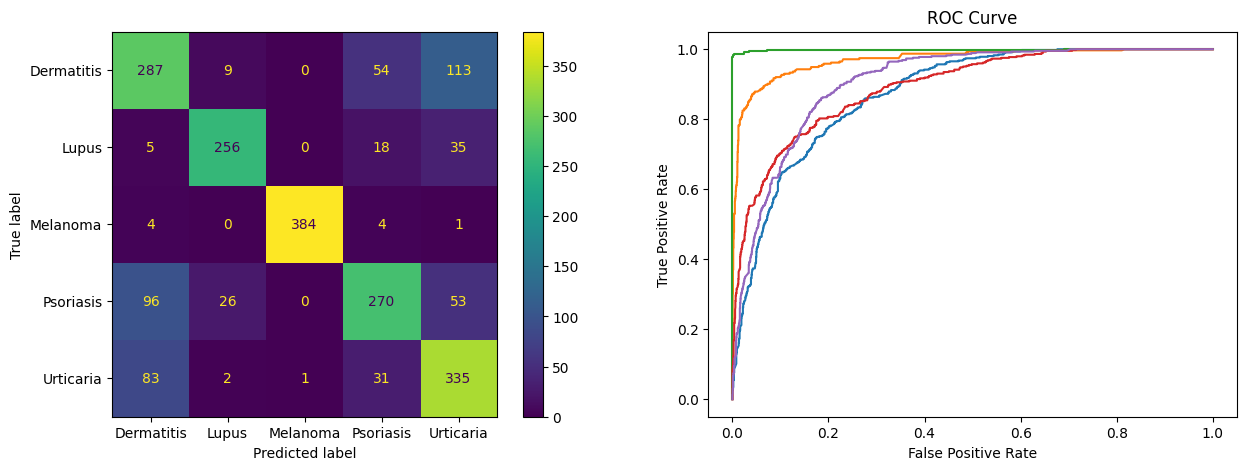

In [71]:
best_params = random_search_svm(X_train_tfidf_ngram_proc)
model_svm(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [72]:
name = "SVM_lem_"

**BoW** 

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.0622423606563065

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      

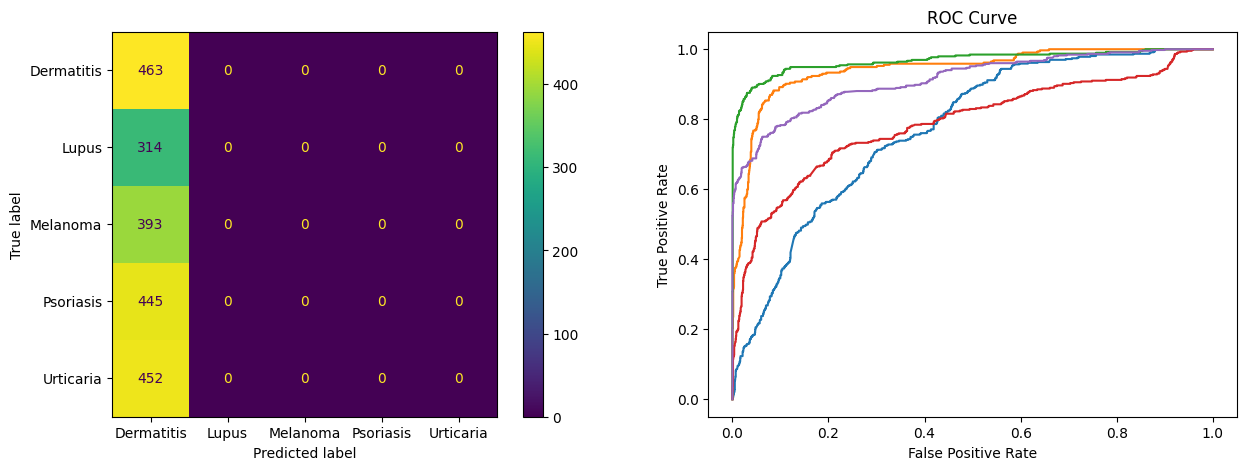

In [73]:
best_params = random_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.0435183660731786

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      

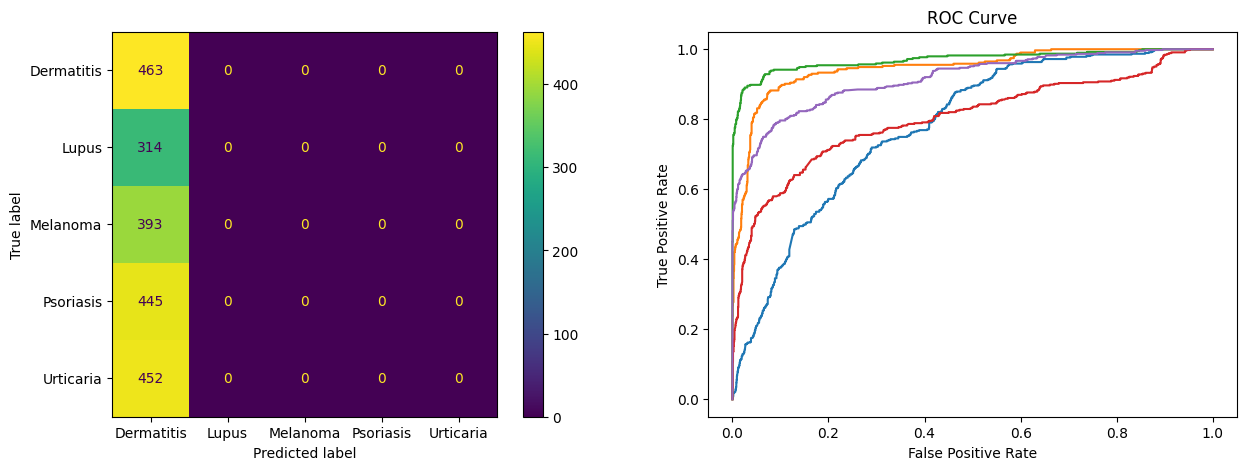

In [74]:
best_params = random_search_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8114
Specificity Score: 0.8114
Precision Score: 0.8459
F1 Score: 0.8146

Testing Results
Accuracy Score: 0.8021
Specificity Score: 0.8021
Precision Score: 0.8369
F1 Score: 0.8050

Loss
Log loss: 0.49379208644441225

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.60      0.91      0.73      1803
       Lupus       0.86      0.88      0.87      1355
    Melanoma       0.98      0.93      0.96      1677
   Psoriasis       0.82      0.61      0.70      1668
   Urticaria       0.98      0.73      0.83      1764

    accuracy                           0.81      8267
   macro avg       0.85      0.81      0.82      8267
weighted avg       0.85      0.81      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.89      0.72       463
       Lupus       0.84  

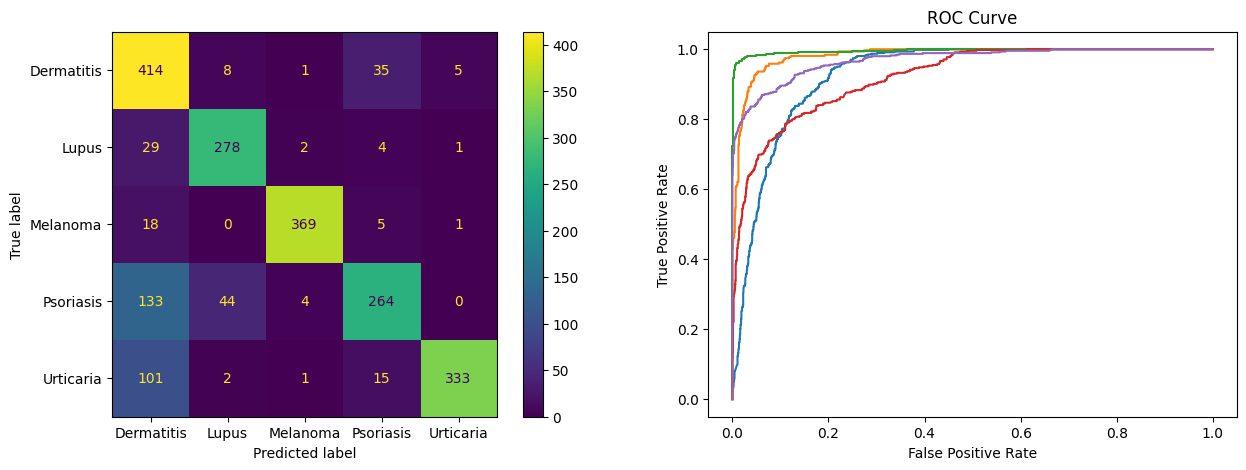

In [75]:
best_params = random_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9139
Specificity Score: 0.9139
Precision Score: 0.9197
F1 Score: 0.9148

Testing Results
Accuracy Score: 0.8399
Specificity Score: 0.8399
Precision Score: 0.8526
F1 Score: 0.8422

Loss
Log loss: 0.43327985531627977

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.79      0.93      0.85      1803
       Lupus       0.96      0.96      0.96      1355
    Melanoma       0.99      0.98      0.98      1677
   Psoriasis       0.91      0.84      0.87      1668
   Urticaria       0.96      0.88      0.92      1764

    accuracy                           0.91      8267
   macro avg       0.92      0.92      0.92      8267
weighted avg       0.92      0.91      0.91      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.67      0.85      0.75       463
       Lupus       0.90  

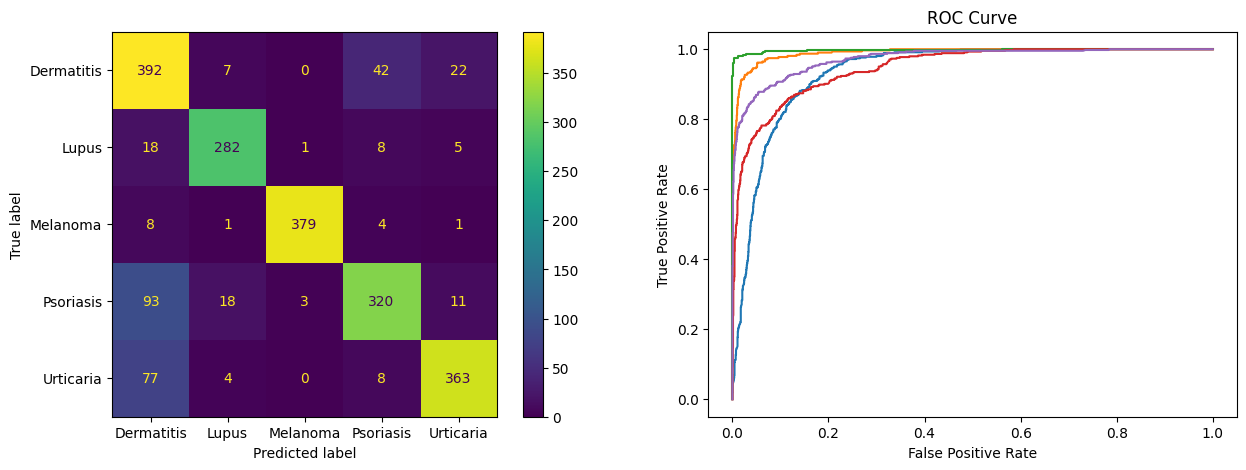

In [76]:
best_params = random_search_svm(X_train_tfidf_ngram_lem)
model_svm(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [77]:
name = "SVM_stem_"

**BoW** 

Best hyperparameters: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9987
Specificity Score: 0.9987
Precision Score: 0.9987
F1 Score: 0.9987

Testing Results
Accuracy Score: 0.5520
Specificity Score: 0.5520
Precision Score: 0.7257
F1 Score: 0.5357

Loss
Log loss: 0.8379932891349245

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.52      0.76      0.61       463
       Lupus       0.95      0.2

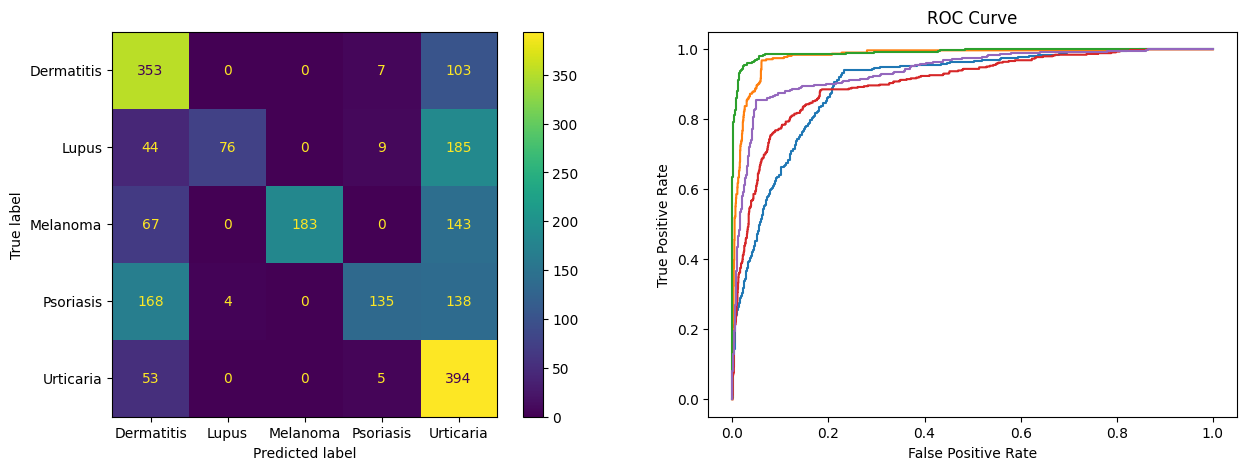

In [78]:
best_params = random_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.544246889096158

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      0.00

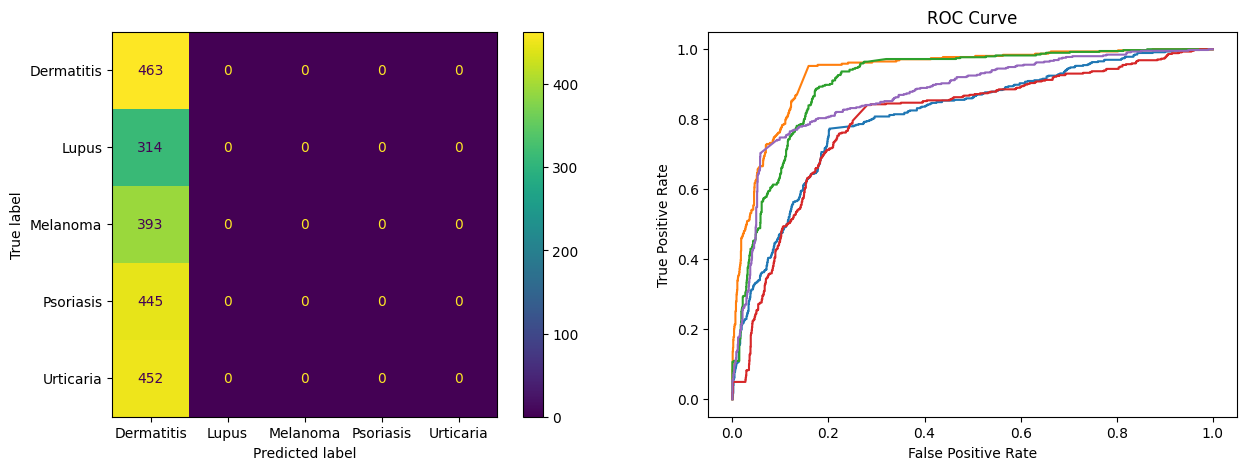

In [79]:
best_params = random_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9376
Specificity Score: 0.9376
Precision Score: 0.9400
F1 Score: 0.9379

Testing Results
Accuracy Score: 0.8805
Specificity Score: 0.8805
Precision Score: 0.8852
F1 Score: 0.8811

Loss
Log loss: 0.32529040986663604

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.85      0.94      0.89      1803
       Lupus       0.97      0.98      0.98      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.93      0.87      0.90      1668
   Urticaria       0.97      0.92      0.94      1764

    accuracy                           0.94      8267
   macro avg       0.94      0.94      0.94      8267
weighted avg       0.94      0.94      0.94      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.89      0.82       463
       Lupus       0.94   

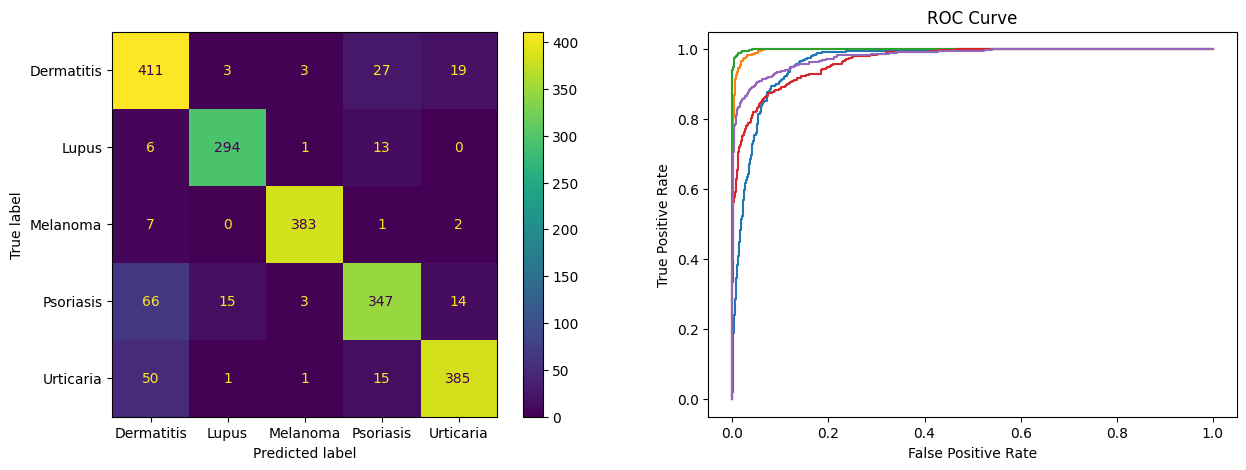

In [80]:
best_params = random_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9047
Specificity Score: 0.9047
Precision Score: 0.9198
F1 Score: 0.9070

Testing Results
Accuracy Score: 0.8505
Specificity Score: 0.8505
Precision Score: 0.8759
F1 Score: 0.8539

Loss
Log loss: 0.36739176019184555

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.96      0.83      1803
       Lupus       0.98      0.93      0.96      1355
    Melanoma       1.00      0.96      0.98      1677
   Psoriasis       0.94      0.79      0.86      1668
   Urticaria       0.97      0.87      0.92      1764

    accuracy                           0.90      8267
   macro avg       0.92      0.91      0.91      8267
weighted avg       0.92      0.90      0.91      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.66      0.94      0.77       463
       Lupus       0.95      

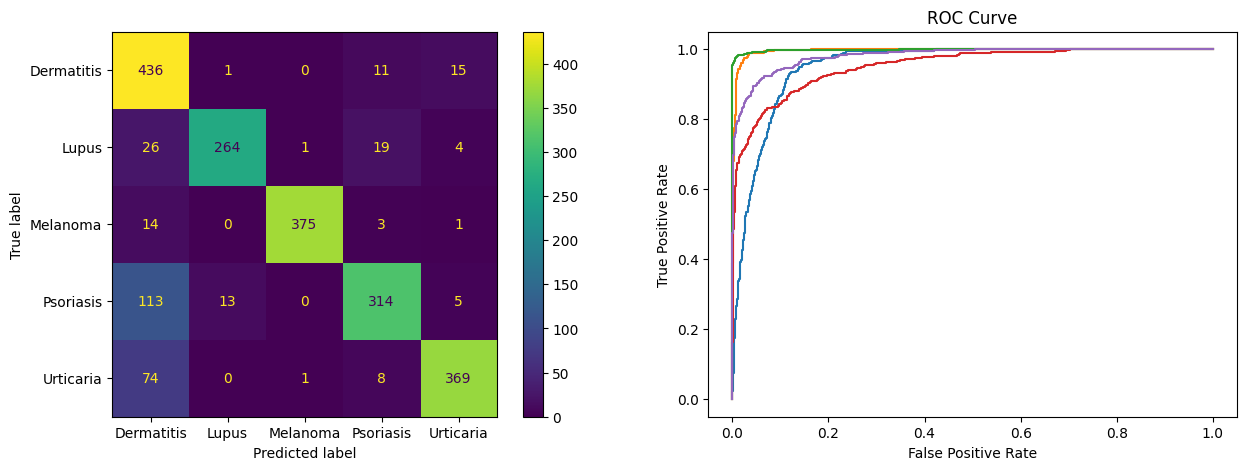

In [81]:
best_params = random_search_svm(X_train_tfidf_ngram_stem)
model_svm(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [82]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

0.8810877399557137


### Deep Learning

In [98]:
def preprocessing_dl(tokenizer, vocab_size, mean_length, X_train, X_test):
    #tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences
    seq_train = tokenizer.texts_to_sequences(X_train)
    seq_test = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to the same size
    pad_train = pad_sequences(seq_train, maxlen = mean_length)
    pad_test = pad_sequences(seq_test, maxlen = mean_length)

    word_index = tokenizer.word_index
    print(len(word_index))
    return pad_train, pad_test


In [99]:
# Convert labels into numeric
diseases = {
    'Dermatitis': 0,
    'Lupus': 1,
    'Melanoma': 2,
    'Psoriasis': 3,
    'Urticaria': 4
}

# Create array with numeric diseases
train_labels = np.array(
    [diseases[label] for label in train['Disease']])
test_labels = np.array(
    [diseases[label] for label in test['Disease']])


In [100]:
def analyse_data(data):
    words = set()

    for sentence in data:
        for word in sentence:
            words.add(word)

    num_unique_words = len(words)
    print(f"Number of unique words: {num_unique_words}")

    mean_length = int(data.apply(' '.join).str.len().mean())
    print(f"Mean length: {mean_length}")

    return num_unique_words, mean_length

#### Recurrent Neural Network

##### Model

In [68]:
def RNN_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    rnn = Sequential(name="Basic_RNN")
    rnn.add(Embedding(vocab_size, embedding_dim))
    #rnn.add(SimpleRNN(128, activation='tanh', return_sequences= True))
    #rnn.add(SimpleRNN(64, activation='tanh', return_sequences = False))
    #rnn.add(Dense(32, activation='relu'))
    #rnn.add(Dense(5, activation='softmax'))
    rnn.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
    rnn.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
    rnn.add(SimpleRNN(32, activation='tanh'))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(5, activation='softmax'))

    rnn.build(input_shape=(None, pad_train.shape[1]))

    print(rnn.summary())

    rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = rnn.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(rnn, history, pad_test, test_labels)
    rnn.save('Models/RNN/rnn_'+ proc_type + '.pkl')

##### Without Preprocessing

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 90, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,881 (1.24 MB)

 Trainable params: 323,881 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.2655 - loss: 1.6244 - val_accuracy: 0.4664 - val_loss: 1.2924
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.5318 - loss: 1.1751 - val_accuracy: 0.5602 - val_loss: 1.1063
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6781 - loss: 0.8554 - val_accuracy: 0.7354 - val_loss: 0.6697
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.8104 - loss: 0.5198 - val_accuracy: 0.7586 - val_loss: 0.6481
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8772 - loss: 0.3606 - val_accuracy: 0.7712 - val_loss: 0.6076
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9013 - loss: 0.2932 - val_accuracy: 0.8016 - val_loss: 0.5907
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9152 - loss: 0.2353 - val_accuracy: 0.8128 - val_loss: 0.5631
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9312 - loss: 0.20

Loss:  0.6461209654808044
Accuracy:  0.8272859454154968


ValueError: Unable to synchronously create dataset (name already exists)

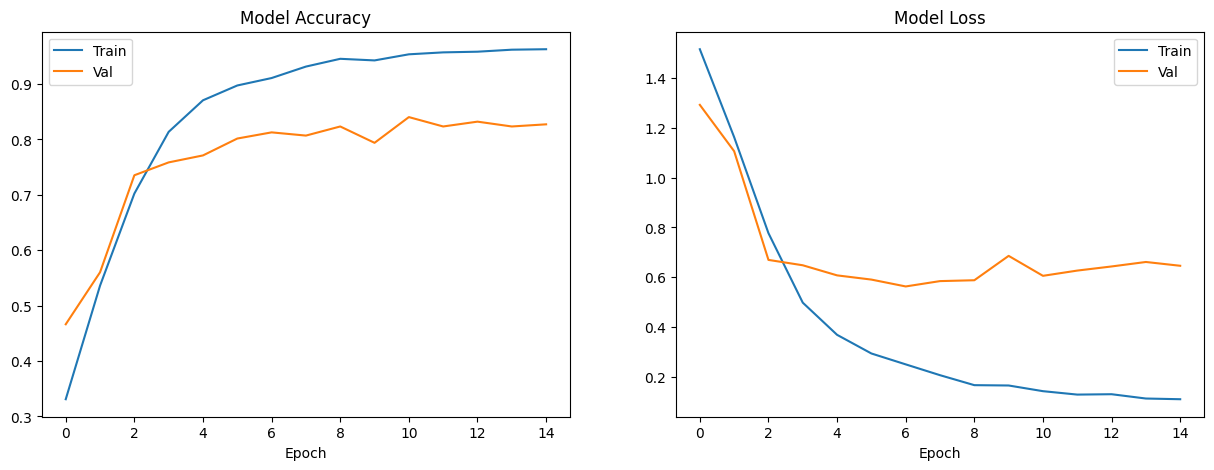

In [70]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

RNN_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 62, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_45 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,221 (875.86 KB)

 Trainable params: 224,221 (875.86 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.2604 - loss: 1.6517 - val_accuracy: 0.6343 - val_loss: 0.9674
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7089 - loss: 0.7794 - val_accuracy: 0.8471 - val_loss: 0.4477
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8772 - loss: 0.3688 - val_accuracy: 0.8587 - val_loss: 0.3960
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9068 - loss: 0.2705 - val_accuracy: 0.8679 - val_loss: 0.3840
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9304 - loss: 0.2123 - val_accuracy: 0.8728 - val_loss: 0.3985
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9451 - loss: 0.1692 - val_accuracy: 0.8597 - val_loss: 0.4500
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9517 - loss: 0.1519 - val_accuracy: 0.8626 - val_loss: 0.4523
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9571 - loss: 0.13

Loss:  0.5873551964759827
Accuracy:  0.8505079746246338


ValueError: Unable to synchronously create dataset (name already exists)

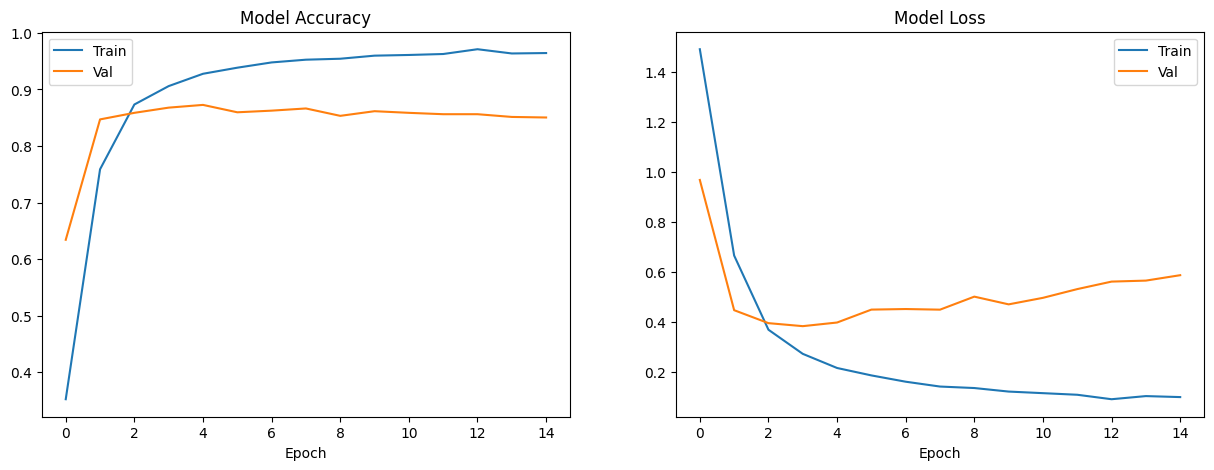

In [71]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 61, 128)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_48 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,081 (824.54 KB)

 Trainable params: 211,081 (824.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.2931 - loss: 1.5832 - val_accuracy: 0.6425 - val_loss: 0.8741
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7235 - loss: 0.7319 - val_accuracy: 0.8312 - val_loss: 0.4698
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8534 - loss: 0.4174 - val_accuracy: 0.8292 - val_loss: 0.4676
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9024 - loss: 0.2927 - val_accuracy: 0.8481 - val_loss: 0.4398
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9255 - loss: 0.2249 - val_accuracy: 0.8563 - val_loss: 0.4480
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9324 - loss: 0.2026 - val_accuracy: 0.8515 - val_loss: 0.5018
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9469 - loss: 0.1616 - val_accuracy: 0.8418 - val_loss: 0.5213
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9516 - loss: 0.15

Loss:  0.6217363476753235
Accuracy:  0.8413159251213074


ValueError: Unable to synchronously create dataset (name already exists)

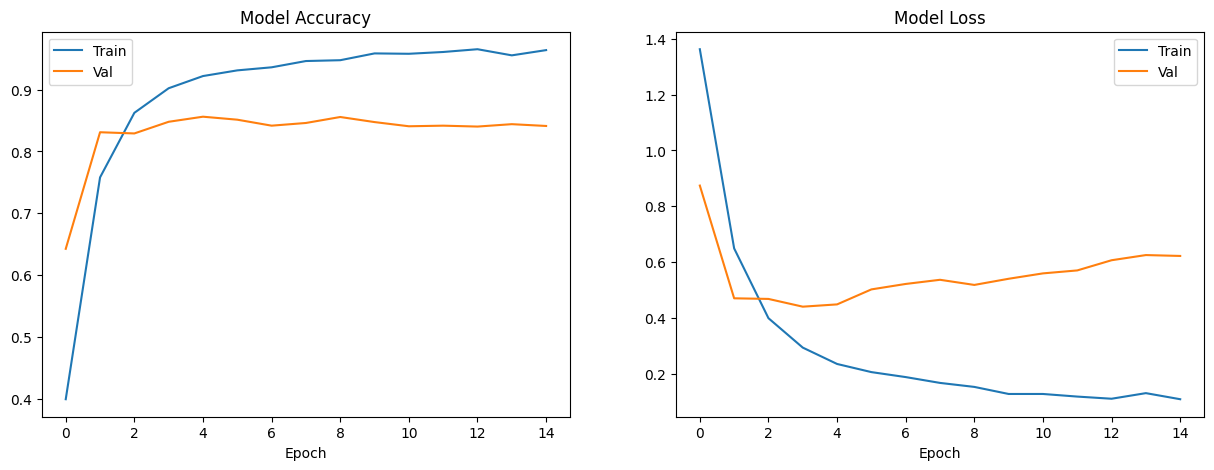

In [72]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 52, 128)        │        16,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 52, 128)        │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_51 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,981 (652.27 KB)

 Trainable params: 166,981 (652.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.2667 - loss: 1.6275 - val_accuracy: 0.7417 - val_loss: 0.6894
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7553 - loss: 0.6499 - val_accuracy: 0.8360 - val_loss: 0.4320
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8642 - loss: 0.3932 - val_accuracy: 0.8520 - val_loss: 0.4180
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8889 - loss: 0.3116 - val_accuracy: 0.8471 - val_loss: 0.4156
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9124 - loss: 0.2584 - val_accuracy: 0.8553 - val_loss: 0.4468
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9237 - loss: 0.2184 - val_accuracy: 0.8645 - val_loss: 0.4470
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9255 - loss: 0.2116 - val_accuracy: 0.8447 - val_loss: 0.4693
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9346 - loss: 0.19

Loss:  0.5517308115959167
Accuracy:  0.8471214175224304


ValueError: Unable to synchronously create dataset (name already exists)

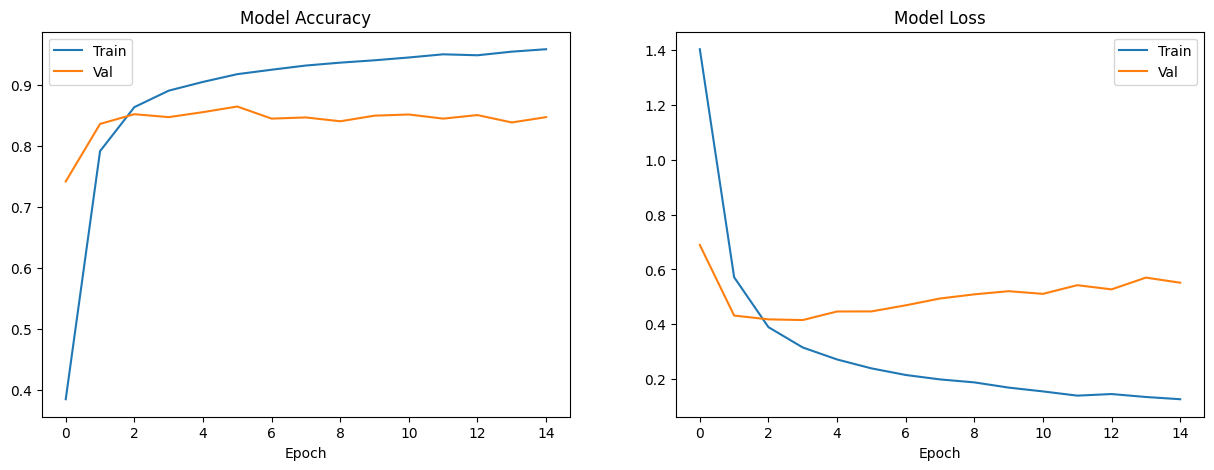

In [73]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### Conv 1D

In [110]:
def Conv1D_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create Conv1D model for text classification
    conv1d = Sequential(name="Conv1D")
    conv1d.add(Embedding(vocab_size, embedding_dim))
    conv1d.add(Conv1D(128, 5))
    conv1d.add(GlobalMaxPooling1D())
    conv1d.add(Dense(64, activation='relu'))
    conv1d.add(Dense(5, activation='softmax'))

    conv1d.build(input_shape=(None, pad_train.shape[1]))

    print(conv1d.summary())

    conv1d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = conv1d.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(conv1d, history, pad_test, test_labels)
    conv1d.save('Models/Conv1D/conv_'+ proc_type + '.pkl')


**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 86, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,969 (1.24 MB)

 Trainable params: 324,969 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5615 - loss: 1.1218 - val_accuracy: 0.8684 - val_loss: 0.3501
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9165 - loss: 0.2436 - val_accuracy: 0.8950 - val_loss: 0.2864
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9543 - loss: 0.1338 - val_accuracy: 0.8892 - val_loss: 0.2937
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0768 - val_accuracy: 0.9028 - val_loss: 0.2952
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9873 - loss: 0.0445 - val_accuracy: 0.8950 - val_loss: 0.3253
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9941 - loss: 0.0246 - val_accuracy: 0.8897 - val_loss: 0.3670
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9961 - loss: 0.0155 - val_accuracy: 0.8926 - val_loss: 0.3896
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9973 - loss: 0.0124 - val

Loss:  0.6070443391799927
Accuracy:  0.8921141624450684


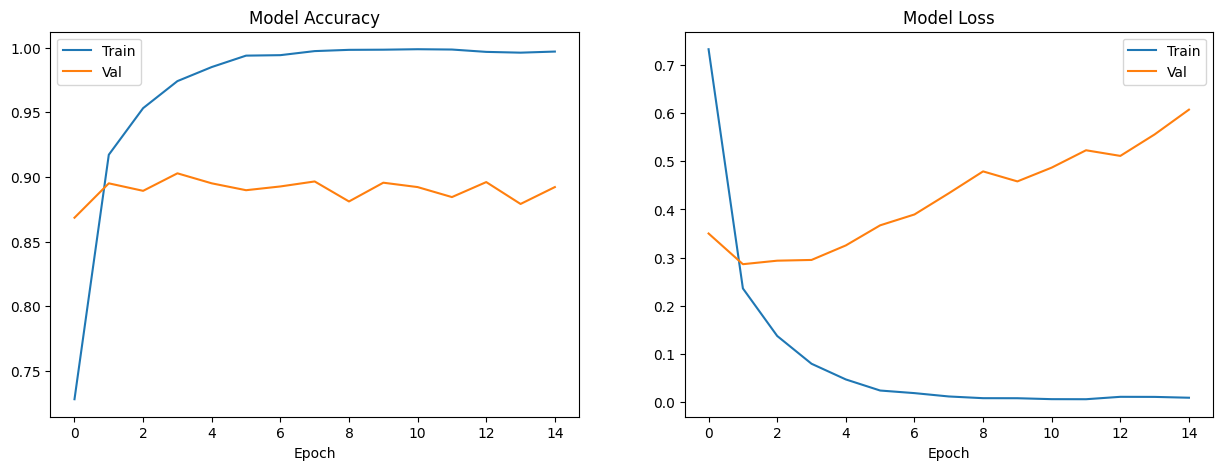

In [111]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 58, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,309 (880.11 KB)

 Trainable params: 225,309 (880.11 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5939 - loss: 1.0687 - val_accuracy: 0.8703 - val_loss: 0.3289
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9147 - loss: 0.2383 - val_accuracy: 0.8926 - val_loss: 0.2956
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9498 - loss: 0.1538 - val_accuracy: 0.8897 - val_loss: 0.3014
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9651 - loss: 0.1008 - val_accuracy: 0.8931 - val_loss: 0.3391
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9846 - loss: 0.0574 - val_accuracy: 0.8810 - val_loss: 0.3683
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9859 - loss: 0.0425 - val_accuracy: 0.8911 - val_loss: 0.4183
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.8824 - val_loss: 0.4615
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9940 - loss: 0.0202 - val_ac

Loss:  0.6556001901626587
Accuracy:  0.8814707398414612


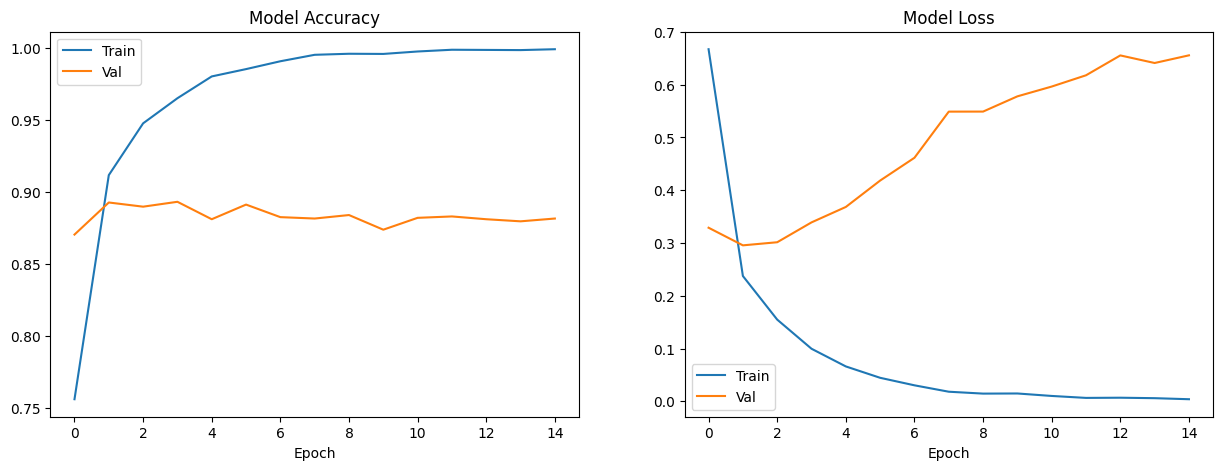

In [112]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 57, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,169 (828.79 KB)

 Trainable params: 212,169 (828.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5940 - loss: 1.0878 - val_accuracy: 0.8602 - val_loss: 0.3579
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9076 - loss: 0.2549 - val_accuracy: 0.8747 - val_loss: 0.3215
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9449 - loss: 0.1615 - val_accuracy: 0.8810 - val_loss: 0.3378
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9646 - loss: 0.1083 - val_accuracy: 0.8810 - val_loss: 0.3654
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9809 - loss: 0.0671 - val_accuracy: 0.8829 - val_loss: 0.3794
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9856 - loss: 0.0448 - val_accuracy: 0.8766 - val_loss: 0.4444
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9911 - loss: 0.0331 - val_accuracy: 0.8761 - val_loss: 0.4826
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9951 - loss: 0.0180 - val_

Loss:  0.7303935289382935
Accuracy:  0.8684083223342896


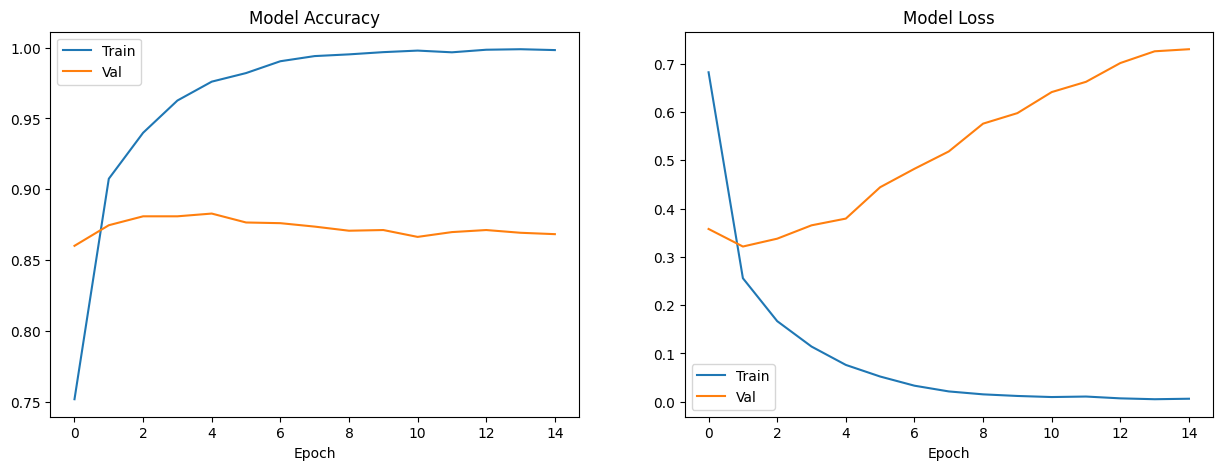

In [113]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 48, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,069 (656.52 KB)

 Trainable params: 168,069 (656.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5938 - loss: 1.0932 - val_accuracy: 0.8423 - val_loss: 0.3728
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8977 - loss: 0.2702 - val_accuracy: 0.8747 - val_loss: 0.3245
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9450 - loss: 0.1661 - val_accuracy: 0.8761 - val_loss: 0.3237
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9573 - loss: 0.1239 - val_accuracy: 0.8752 - val_loss: 0.3496
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9773 - loss: 0.0782 - val_accuracy: 0.8786 - val_loss: 0.3972
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9826 - loss: 0.0555 - val_accuracy: 0.8791 - val_loss: 0.4159
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9910 - loss: 0.0339 - val_accuracy: 0.8776 - val_loss: 0.4721
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9922 - loss: 0.0270 - val_a

Loss:  0.670488715171814
Accuracy:  0.8761489987373352


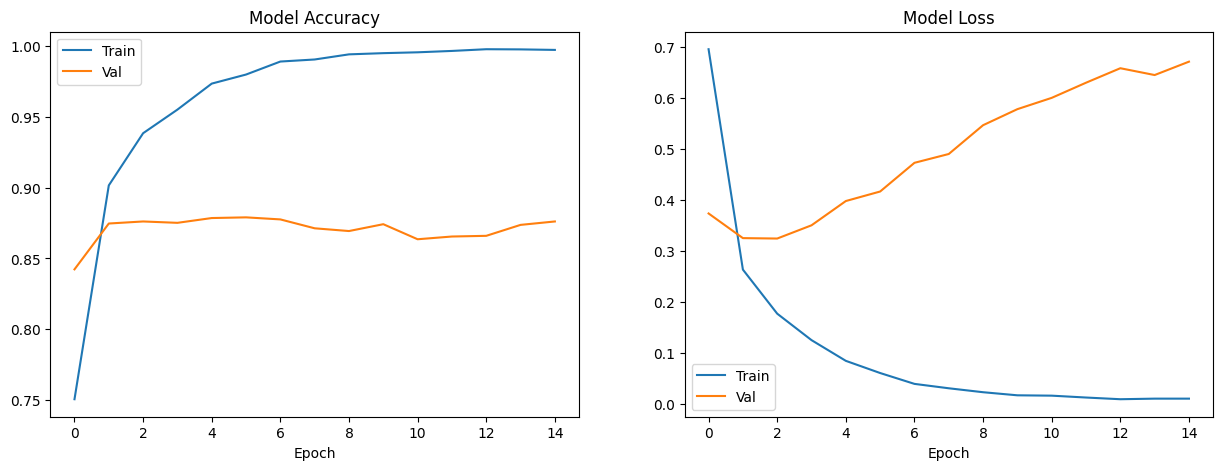

In [114]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### LSTM

In [117]:
def LSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    lstm = Sequential(name="LSTM")
    lstm.add(Embedding(vocab_size, embedding_dim))
    lstm.add(LSTM(32))
    lstm.add(Dropout(0.4))
    lstm.add(Dense(5, activation='softmax'))

    lstm.build(input_shape=(None, pad_train.shape[1]))

    print(lstm.summary())

    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = lstm.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(lstm, history, pad_test, test_labels)
    lstm.save('Models/LSTM/LSTM_'+ proc_type + '.pkl')

**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,929 (1.11 MB)

 Trainable params: 289,929 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4369 - loss: 1.3102 - val_accuracy: 0.8079 - val_loss: 0.5298
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8473 - loss: 0.4224 - val_accuracy: 0.8573 - val_loss: 0.3840
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9159 - loss: 0.2614 - val_accuracy: 0.8684 - val_loss: 0.3458
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9397 - loss: 0.1954 - val_accuracy: 0.8737 - val_loss: 0.3569
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9544 - loss: 0.1599 - val_accuracy: 0.8703 - val_loss: 0.3824
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9625 - loss: 0.1243 - val_accuracy: 0.8771 - val_loss: 0.3557
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9681 - loss: 0.1112 - val_accuracy: 0.8791 - val_loss: 0.3866
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9739 - loss: 0.0913 - va

Loss:  0.5451188683509827
Accuracy:  0.8761489987373352


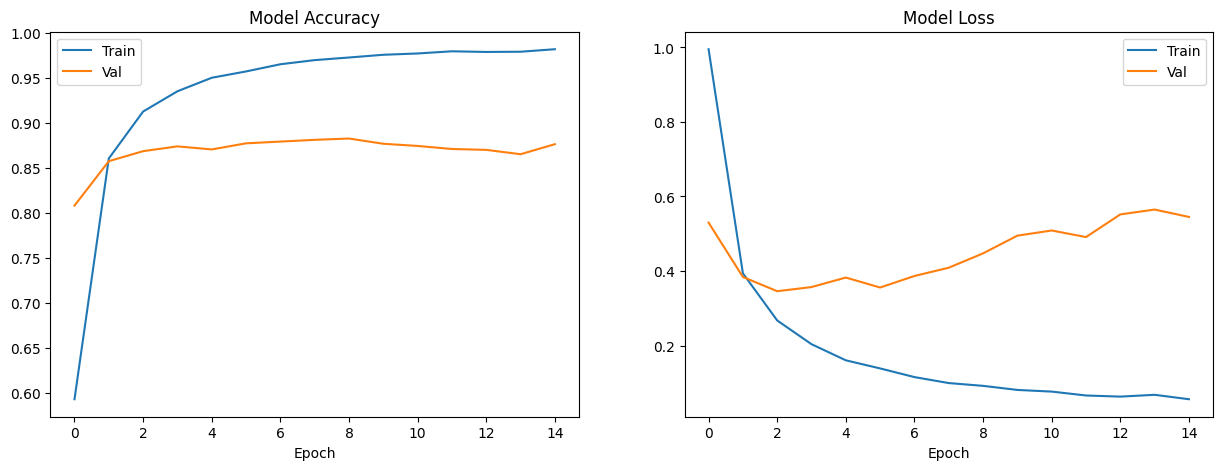

In [118]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

LSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,269 (743.24 KB)

 Trainable params: 190,269 (743.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4528 - loss: 1.3037 - val_accuracy: 0.7789 - val_loss: 0.5507
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8425 - loss: 0.4359 - val_accuracy: 0.8732 - val_loss: 0.3448
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9113 - loss: 0.2700 - val_accuracy: 0.8868 - val_loss: 0.3200
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9240 - loss: 0.2254 - val_accuracy: 0.8868 - val_loss: 0.3144
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9481 - loss: 0.1716 - val_accuracy: 0.8921 - val_loss: 0.3094
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9440 - loss: 0.1654 - val_accuracy: 0.8849 - val_loss: 0.3232
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9574 - loss: 0.1408 - val_accuracy: 0.8853 - val_loss: 0.3624
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9570 - loss: 0.1317 - val

Loss:  0.5103368759155273
Accuracy:  0.8688921332359314


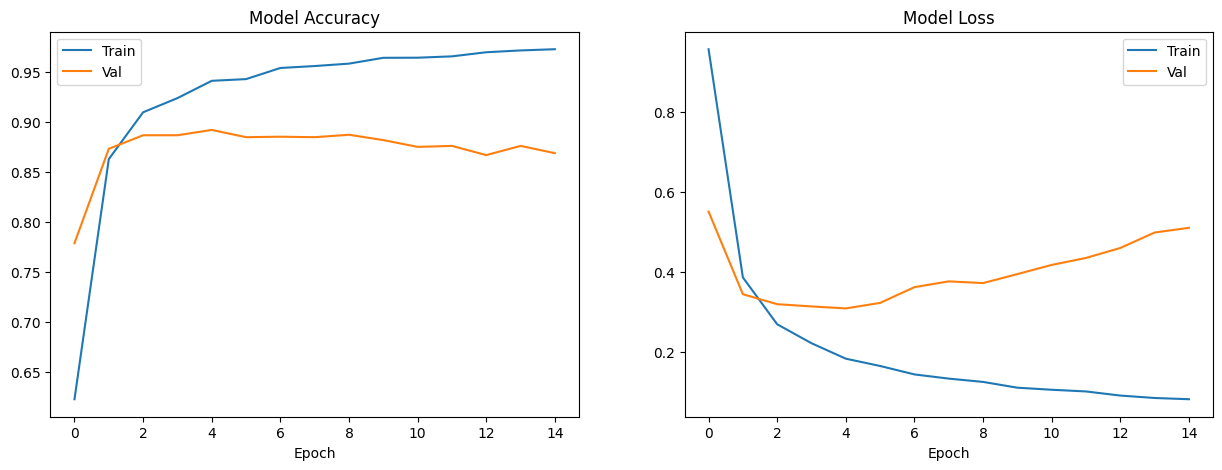

In [119]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,129 (691.91 KB)

 Trainable params: 177,129 (691.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4726 - loss: 1.2937 - val_accuracy: 0.8326 - val_loss: 0.4524
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8699 - loss: 0.3880 - val_accuracy: 0.8747 - val_loss: 0.3444
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9057 - loss: 0.2785 - val_accuracy: 0.8800 - val_loss: 0.3218
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9264 - loss: 0.2167 - val_accuracy: 0.8791 - val_loss: 0.3308
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9375 - loss: 0.1851 - val_accuracy: 0.8776 - val_loss: 0.3677
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9452 - loss: 0.1672 - val_accuracy: 0.8791 - val_loss: 0.3647
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9513 - loss: 0.1470 - val_accuracy: 0.8742 - val_loss: 0.4205
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9524 - loss: 0.1414 - val

Loss:  0.5820496082305908
Accuracy:  0.8558297157287598


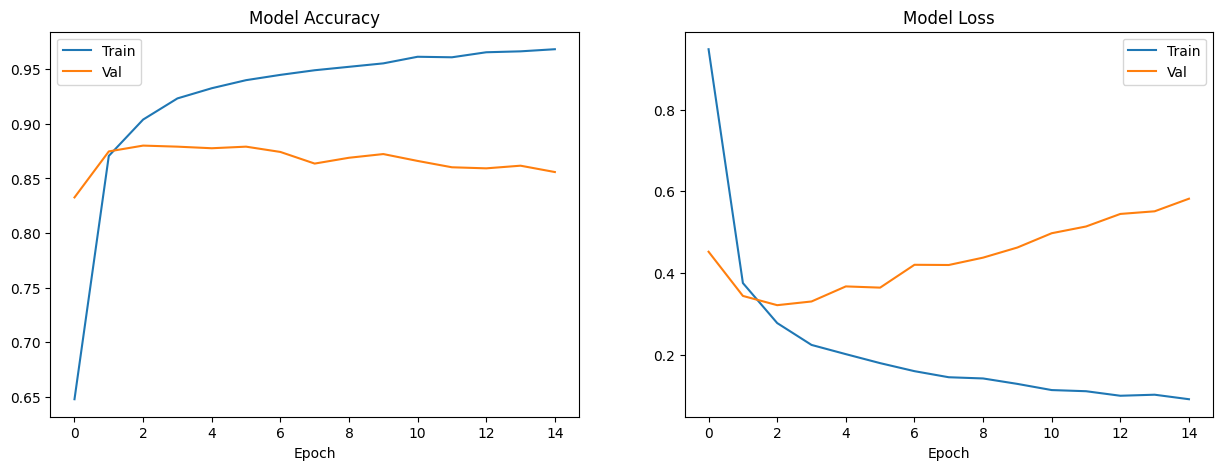

In [120]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,029 (519.64 KB)

 Trainable params: 133,029 (519.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4531 - loss: 1.3407 - val_accuracy: 0.8283 - val_loss: 0.4963
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8517 - loss: 0.4440 - val_accuracy: 0.8703 - val_loss: 0.3546
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9041 - loss: 0.3041 - val_accuracy: 0.8655 - val_loss: 0.3497
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9157 - loss: 0.2526 - val_accuracy: 0.8791 - val_loss: 0.3323
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9236 - loss: 0.2262 - val_accuracy: 0.8699 - val_loss: 0.3393
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9371 - loss: 0.2038 - val_accuracy: 0.8766 - val_loss: 0.3419
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9388 - loss: 0.1804 - val_accuracy: 0.8708 - val_loss: 0.4129
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9431 - loss: 0.1773 - val

Loss:  0.48959052562713623
Accuracy:  0.8572810888290405


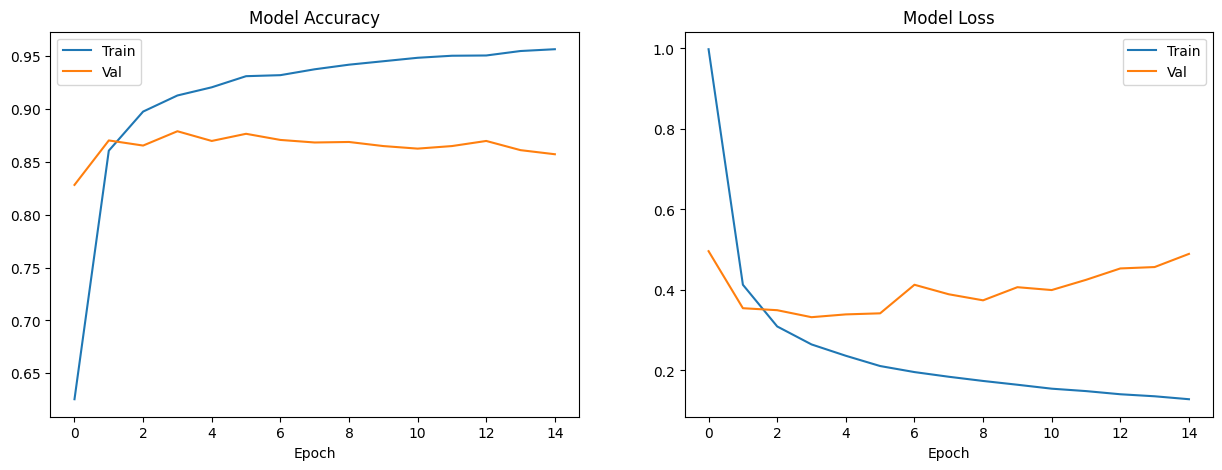

In [121]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

#### BILSTM

In [124]:
def BiLSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    blstm = Sequential(name="Bi_LSTM")
    blstm.add(Embedding(vocab_size, embedding_dim))
    blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    blstm.add(Dropout(0.4))
    blstm.add(Bidirectional(LSTM(32)))
    blstm.add(Dropout(0.2))
    blstm.add(Dense(64, activation='relu'))
    blstm.add(Dropout(0.1))
    blstm.add(Dense(5, activation='softmax'))

    blstm.build(input_shape=(None, pad_train.shape[1]))

    print(blstm.summary())

    blstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = blstm.fit(
        pad_train, 
        train_labels, 
        epochs=15,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(blstm, history, pad_test, test_labels)
    blstm.save('Models/BILSTM/BILSTM_'+ proc_type + '.pkl')

**Without Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 4631
Mean length: 90
4146


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ (None, 90, 60)         │       277,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 90, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,561 (1.48 MB)

 Trainable params: 387,561 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.4415 - loss: 1.2254 - val_accuracy: 0.8534 - val_loss: 0.4074
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.8787 - loss: 0.3309 - val_accuracy: 0.8800 - val_loss: 0.3445
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.9261 - loss: 0.2140 - val_accuracy: 0.8742 - val_loss: 0.3511
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.9481 - loss: 0.1646 - val_accuracy: 0.8810 - val_loss: 0.3535
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9587 - loss: 0.1343 - val_accuracy: 0.8839 - val_loss: 0.3753
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9640 - loss: 0.1143 - val_accuracy: 0.8829 - val_loss: 0.4516
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9648 - loss: 0.1084 - val_accuracy: 0.8902 - val_loss: 0.4091
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9716 - loss: 0.0

Loss:  0.5464988350868225
Accuracy:  0.8746976256370544


ValueError: Unable to synchronously create dataset (name already exists)

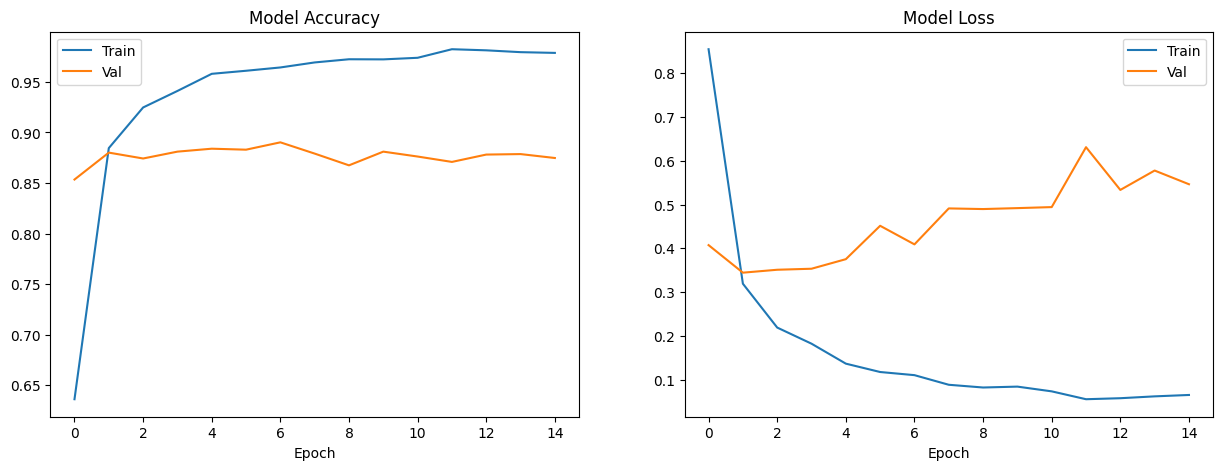

In [125]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input'], test['User_input'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

**With Preprocessing**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2970
Mean length: 62
2731


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ (None, 62, 60)         │       178,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 62, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,901 (1.10 MB)

 Trainable params: 287,901 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.4618 - loss: 1.2165 - val_accuracy: 0.8336 - val_loss: 0.4449
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.8677 - loss: 0.3617 - val_accuracy: 0.8655 - val_loss: 0.3724
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.9069 - loss: 0.2635 - val_accuracy: 0.8761 - val_loss: 0.3442
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.9305 - loss: 0.2094 - val_accuracy: 0.8771 - val_loss: 0.3569
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9395 - loss: 0.1776 - val_accuracy: 0.8761 - val_loss: 0.3894
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9452 - loss: 0.1619 - val_accuracy: 0.8858 - val_loss: 0.3454
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9538 - loss: 0.1486 - val_accuracy: 0.8757 - val_loss: 0.3886
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9506 - loss: 0.13

Loss:  0.574897825717926
Accuracy:  0.8659893274307251


ValueError: Unable to synchronously create dataset (name already exists)

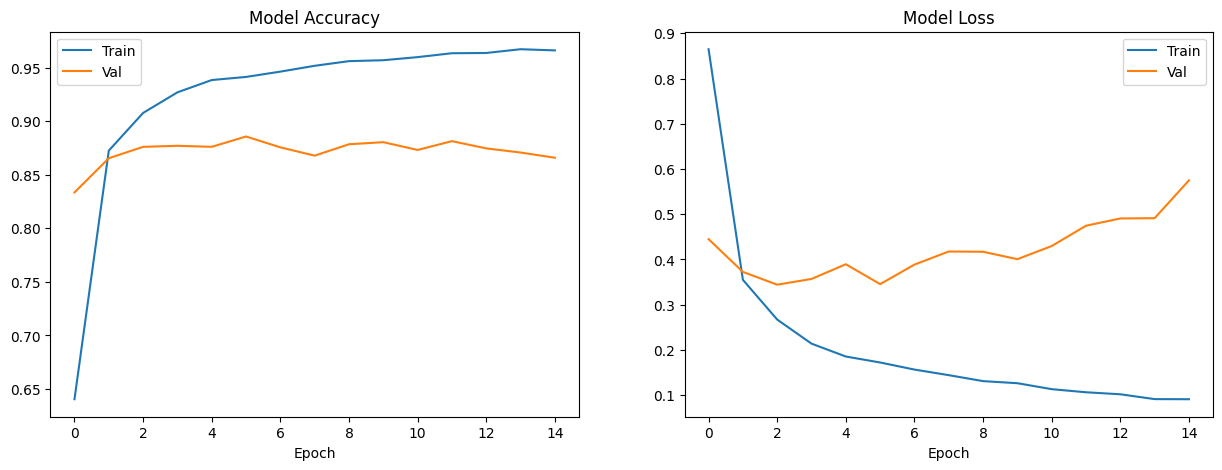

In [126]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc')

**With Lemmatization**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2751
Mean length: 61
2532


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ (None, 61, 60)         │       165,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 61, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,761 (1.05 MB)

 Trainable params: 274,761 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.4664 - loss: 1.2157 - val_accuracy: 0.8355 - val_loss: 0.4198
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8584 - loss: 0.3834 - val_accuracy: 0.8679 - val_loss: 0.3642
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9071 - loss: 0.2558 - val_accuracy: 0.8674 - val_loss: 0.3728
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9252 - loss: 0.2095 - val_accuracy: 0.8781 - val_loss: 0.3664
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9371 - loss: 0.1794 - val_accuracy: 0.8781 - val_loss: 0.3801
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9422 - loss: 0.1592 - val_accuracy: 0.8742 - val_loss: 0.4144
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9458 - loss: 0.1607 - val_accuracy: 0.8694 - val_loss: 0.4605
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9556 - loss: 0.13

Loss:  0.6106784343719482
Accuracy:  0.8577648997306824


ValueError: Unable to synchronously create dataset (name already exists)

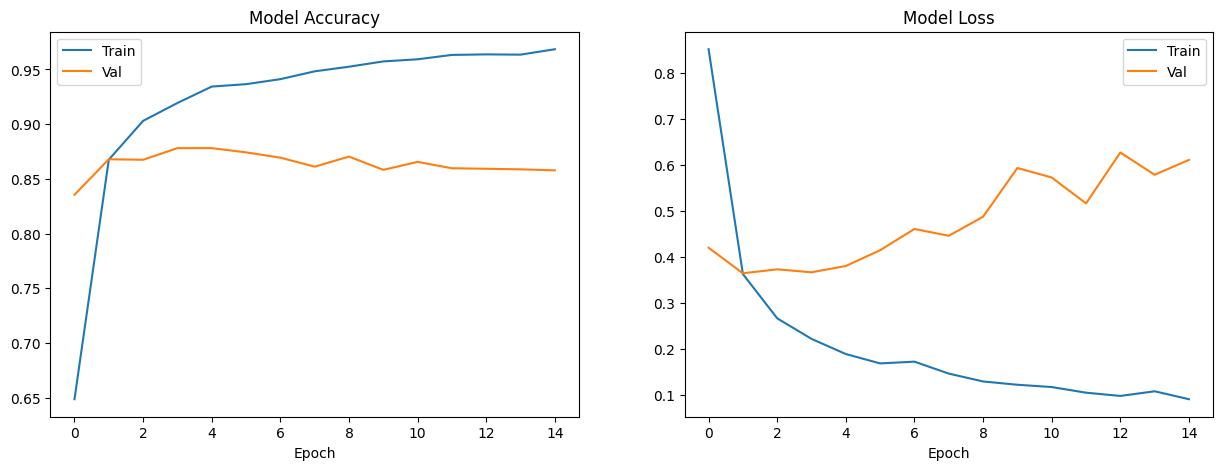

In [127]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

**With Stemming**

**BoW**

In [ ]:
tokenizer = boW

**BoW n-gram**

In [ ]:
tokenizer = bow_ngram

**TF-IDF**

In [ ]:
tokenizer = tf_idf

**TF-IDF n-gram**

In [ ]:
tokenizer = tf_idf_ngram

Number of unique words: 2016
Mean length: 52
1887


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ (None, 52, 60)         │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 52, 128)        │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,661 (901.02 KB)

 Trainable params: 230,661 (901.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4587 - loss: 1.2257 - val_accuracy: 0.8220 - val_loss: 0.4780
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8489 - loss: 0.4189 - val_accuracy: 0.8258 - val_loss: 0.4592
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8843 - loss: 0.3288 - val_accuracy: 0.8505 - val_loss: 0.4024
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8953 - loss: 0.2886 - val_accuracy: 0.8524 - val_loss: 0.4148
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9158 - loss: 0.2552 - val_accuracy: 0.8568 - val_loss: 0.4218
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9225 - loss: 0.2195 - val_accuracy: 0.8597 - val_loss: 0.4096
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9356 - loss: 0.1868 - val_accuracy: 0.8568 - val_loss: 0.4206
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9396 - loss: 0.16

Loss:  0.5107753276824951
Accuracy:  0.8519593477249146


ValueError: Unable to synchronously create dataset (name already exists)

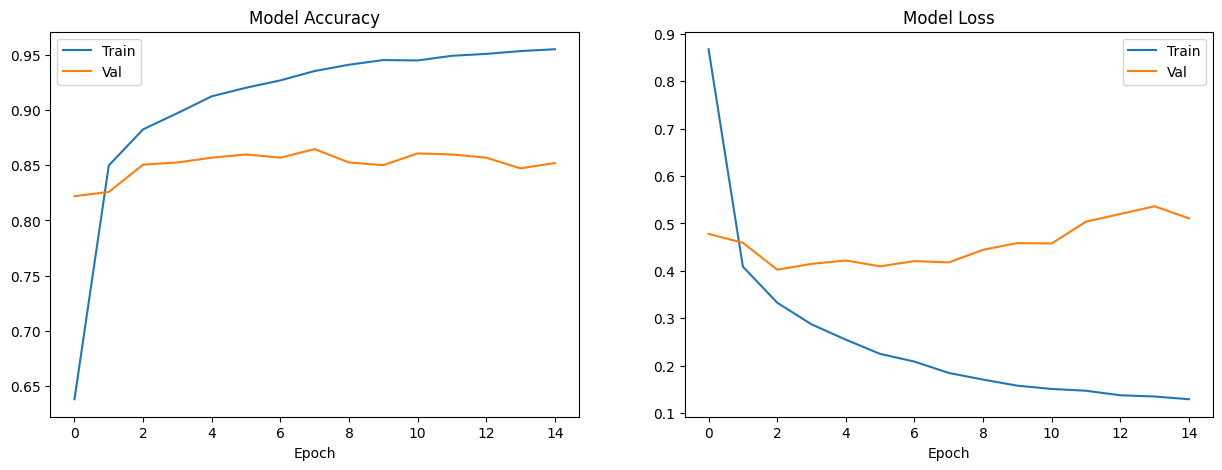

In [129]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(tokenizer, vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')